In [1]:
import random
import numpy as np
import torch
import time
import matplotlib.pyplot as plt
import learn2learn as l2l
from torch import nn, optim
start = time.time()

In [2]:
from learn2learn.data.transforms import (NWays, KShots, LoadData, RemapLabels, ConsecutiveLabels)

In [3]:
def accuracy(predictions, targets):
    predictions = predictions.argmax(dim=1).view(targets.shape)
    return (predictions == targets).sum().float() / targets.size(0)

In [4]:
def fast_adapt(batch, learner, loss, adaptation_steps, shots, ways, device):
    data, labels = batch
    data, labels = data.to(device), labels.to(device)

    # Separate data into adaptation/evalutation sets
    adaptation_indices = np.zeros(data.size(0), dtype=bool)
    adaptation_indices[np.arange(shots*ways) * 2] = True
    evaluation_indices = torch.from_numpy(~adaptation_indices)
    adaptation_indices = torch.from_numpy(adaptation_indices)
    adaptation_data, adaptation_labels = data[adaptation_indices], labels[adaptation_indices]
    evaluation_data, evaluation_labels = data[evaluation_indices], labels[evaluation_indices]

    # Adapt the model
    for step in range(adaptation_steps):
        train_error = loss(learner(adaptation_data), adaptation_labels)
        learner.adapt(train_error)

    # Evaluate the adapted model
    predictions = learner(evaluation_data)
    valid_error = loss(predictions, evaluation_labels)
    valid_accuracy = accuracy(predictions, evaluation_labels)
    return valid_error, valid_accuracy

In [5]:
ways=5
shots=5
meta_lr=0.003
fast_lr=0.5
meta_batch_size=32
adaptation_steps=1
num_iterations= 10000
cuda=True
seed=42

In [6]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
device = torch.device('cpu')
if cuda and torch.cuda.device_count():
    torch.cuda.manual_seed(seed)
    device = torch.device('cuda')
# Create Tasksets using the benchmark interface
tasksets = l2l.vision.benchmarks.get_tasksets('omniglot', train_ways=ways, train_samples=2*shots, test_ways=ways, test_samples=2*shots, num_tasks=20000, root='~/data')

Files already downloaded and verified
Files already downloaded and verified


In [7]:
model = l2l.vision.models.OmniglotFC(28 ** 2, ways)
model.to(device)
maml = l2l.algorithms.MAML(model, lr=fast_lr, first_order=True)
opt = optim.Adam(maml.parameters(), meta_lr)
loss = nn.CrossEntropyLoss(reduction='mean')

In [8]:
print(maml)

MAML(
  (module): OmniglotFC(
    (features): Sequential(
      (0): Flatten()
      (1): Sequential(
        (0): LinearBlock(
          (relu): ReLU()
          (normalize): BatchNorm1d(256, eps=0.001, momentum=0.999, affine=True, track_running_stats=False)
          (linear): Linear(in_features=784, out_features=256, bias=True)
        )
        (1): LinearBlock(
          (relu): ReLU()
          (normalize): BatchNorm1d(128, eps=0.001, momentum=0.999, affine=True, track_running_stats=False)
          (linear): Linear(in_features=256, out_features=128, bias=True)
        )
        (2): LinearBlock(
          (relu): ReLU()
          (normalize): BatchNorm1d(64, eps=0.001, momentum=0.999, affine=True, track_running_stats=False)
          (linear): Linear(in_features=128, out_features=64, bias=True)
        )
        (3): LinearBlock(
          (relu): ReLU()
          (normalize): BatchNorm1d(64, eps=0.001, momentum=0.999, affine=True, track_running_stats=False)
          (linear): 

In [9]:
no_of_iternation = []
meta_train_err = []
meta_train_acc = []
meta_val_err = []
meta_val_acc = []

for iteration in range(num_iterations):
    
    opt.zero_grad()
    meta_train_error = 0.0
    meta_train_accuracy = 0.0
    meta_valid_error = 0.0
    meta_valid_accuracy = 0.0
    for task in range(meta_batch_size):
        # Compute meta-training loss
        learner = maml.clone()
        batch = tasksets.train.sample()
        evaluation_error, evaluation_accuracy = fast_adapt(batch,
                                                           learner,
                                                           loss,
                                                           adaptation_steps,
                                                           shots,
                                                           ways,
                                                           device)
        evaluation_error.backward()
        meta_train_error += evaluation_error.item()
        meta_train_accuracy += evaluation_accuracy.item()

        # Compute meta-validation loss
        learner = maml.clone()
        batch = tasksets.validation.sample()
        evaluation_error, evaluation_accuracy = fast_adapt(batch,
                                                           learner,
                                                           loss,
                                                           adaptation_steps,
                                                           shots,
                                                           ways,
                                                           device)
        meta_valid_error += evaluation_error.item()
        meta_valid_accuracy += evaluation_accuracy.item()

    # Print some metrics
    print('\n')
    print('Iteration', iteration)
    no_of_iternation.append(iteration)
    print('Meta Train Error', meta_train_error / meta_batch_size)
    meta_train_err.append(meta_train_error / meta_batch_size)
    print('Meta Train Accuracy', meta_train_accuracy / meta_batch_size)
    meta_train_acc.append(meta_train_accuracy / meta_batch_size)
    print('Meta Valid Error', meta_valid_error / meta_batch_size)
    meta_val_err.append(meta_valid_error / meta_batch_size)
    print('Meta Valid Accuracy', meta_valid_accuracy / meta_batch_size)
    meta_val_acc.append(meta_valid_accuracy / meta_batch_size)

    # Average the accumulated gradients and optimize
    for p in maml.parameters():
        p.grad.data.mul_(1.0 / meta_batch_size)
    opt.step()

meta_test_error = 0.0
meta_test_accuracy = 0.0



Iteration 0
Meta Train Error 1.517993114888668
Meta Train Accuracy 0.38249998865649104
Meta Valid Error 1.5413377285003662
Meta Valid Accuracy 0.3462499894667417


Iteration 1
Meta Train Error 1.4666730985045433
Meta Train Accuracy 0.3149999896995723
Meta Valid Error 1.4145780466496944
Meta Valid Accuracy 0.35374999046325684


Iteration 2
Meta Train Error 1.418690450489521
Meta Train Accuracy 0.3337499920744449
Meta Valid Error 1.4026167839765549
Meta Valid Accuracy 0.3662499892525375


Iteration 3
Meta Train Error 1.3605781346559525
Meta Train Accuracy 0.4187499904073775
Meta Valid Error 1.365630466490984
Meta Valid Accuracy 0.4462499860674143


Iteration 4
Meta Train Error 1.3161916304379702
Meta Train Accuracy 0.4924999885261059
Meta Valid Error 1.331178866326809
Meta Valid Accuracy 0.439999985974282


Iteration 5
Meta Train Error 1.219532247632742
Meta Train Accuracy 0.49374998826533556
Meta Valid Error 1.269577719271183
Meta Valid Accuracy 0.46874998789280653


Iteration 6
Meta 



Iteration 50
Meta Train Error 0.9400427173823118
Meta Train Accuracy 0.6599999824538827
Meta Valid Error 0.885778215713799
Meta Valid Accuracy 0.6799999782815576


Iteration 51
Meta Train Error 0.7927127461880445
Meta Train Accuracy 0.7174999853596091
Meta Valid Error 0.8351503945887089
Meta Valid Accuracy 0.6874999850988388


Iteration 52
Meta Train Error 0.8441891185939312
Meta Train Accuracy 0.7037499817088246
Meta Valid Error 0.8425578363239765
Meta Valid Accuracy 0.6874999841675162


Iteration 53
Meta Train Error 0.8806708408519626
Meta Train Accuracy 0.6937499782070518
Meta Valid Error 0.8740488439798355
Meta Valid Accuracy 0.6649999897927046


Iteration 54
Meta Train Error 0.8779397085309029
Meta Train Accuracy 0.6787499841302633
Meta Valid Error 0.7931066108867526
Meta Valid Accuracy 0.7174999816343188


Iteration 55
Meta Train Error 0.8281784728169441
Meta Train Accuracy 0.7187499813735485
Meta Valid Error 0.8536814376711845
Meta Valid Accuracy 0.6937499810010195


Iteration



Iteration 100
Meta Train Error 0.6495232512243092
Meta Train Accuracy 0.7749999742954969
Meta Valid Error 0.6271286923438311
Meta Valid Accuracy 0.7712499778717756


Iteration 101
Meta Train Error 0.5380211723968387
Meta Train Accuracy 0.8137499783188105
Meta Valid Error 0.5999065963551402
Meta Valid Accuracy 0.7912499811500311


Iteration 102
Meta Train Error 0.5997670996002853
Meta Train Accuracy 0.796249981969595
Meta Valid Error 0.5998765579424798
Meta Valid Accuracy 0.784999979659915


Iteration 103
Meta Train Error 0.5344302407465875
Meta Train Accuracy 0.8124999785795808
Meta Valid Error 0.6409548725932837
Meta Valid Accuracy 0.7799999807029963


Iteration 104
Meta Train Error 0.6412463346496224
Meta Train Accuracy 0.7912499755620956
Meta Valid Error 0.6303399694152176
Meta Valid Accuracy 0.7762499805539846


Iteration 105
Meta Train Error 0.5788299487903714
Meta Train Accuracy 0.798749977722764
Meta Valid Error 0.5947708892636001
Meta Valid Accuracy 0.7987499814480543


Itera



Iteration 150
Meta Train Error 0.4922641108278185
Meta Train Accuracy 0.824999975040555
Meta Valid Error 0.47197757521644235
Meta Valid Accuracy 0.829999977722764


Iteration 151
Meta Train Error 0.5335386185906827
Meta Train Accuracy 0.8174999728798866
Meta Valid Error 0.6414615008980036
Meta Valid Accuracy 0.7787499818950891


Iteration 152
Meta Train Error 0.4414153716061264
Meta Train Accuracy 0.8612499739974737
Meta Valid Error 0.46289900690317154
Meta Valid Accuracy 0.8399999737739563


Iteration 153
Meta Train Error 0.47418583603575826
Meta Train Accuracy 0.8312499802559614
Meta Valid Error 0.47837629867717624
Meta Valid Accuracy 0.8412499763071537


Iteration 154
Meta Train Error 0.5006376570090652
Meta Train Accuracy 0.8237499762326479
Meta Valid Error 0.5052735910285264
Meta Valid Accuracy 0.8324999716132879


Iteration 155
Meta Train Error 0.5520681450143456
Meta Train Accuracy 0.8087499774992466
Meta Valid Error 0.4903657017275691
Meta Valid Accuracy 0.8262499831616879






Iteration 200
Meta Train Error 0.440297789638862
Meta Train Accuracy 0.8599999770522118
Meta Valid Error 0.42481828248128295
Meta Valid Accuracy 0.8674999754875898


Iteration 201
Meta Train Error 0.40775682986713946
Meta Train Accuracy 0.8712499812245369
Meta Valid Error 0.494285344844684
Meta Valid Accuracy 0.8412499763071537


Iteration 202
Meta Train Error 0.38604237767867744
Meta Train Accuracy 0.8874999806284904
Meta Valid Error 0.45014530420303345
Meta Valid Accuracy 0.8562499787658453


Iteration 203
Meta Train Error 0.3555441094795242
Meta Train Accuracy 0.8812499716877937
Meta Valid Error 0.46231709769926965
Meta Valid Accuracy 0.8437499757856131


Iteration 204
Meta Train Error 0.3885823239106685
Meta Train Accuracy 0.881249975413084
Meta Valid Error 0.3782281402964145
Meta Valid Accuracy 0.8724999725818634


Iteration 205
Meta Train Error 0.518297245260328
Meta Train Accuracy 0.8212499767541885
Meta Valid Error 0.4615041729994118
Meta Valid Accuracy 0.8399999793618917


I



Iteration 250
Meta Train Error 0.2883607057156041
Meta Train Accuracy 0.903749980032444
Meta Valid Error 0.44834301876835525
Meta Valid Accuracy 0.8487499747425318


Iteration 251
Meta Train Error 0.3701819672714919
Meta Train Accuracy 0.8874999787658453
Meta Valid Error 0.38580661779269576
Meta Valid Accuracy 0.8712499737739563


Iteration 252
Meta Train Error 0.4833531714975834
Meta Train Accuracy 0.8524999814108014
Meta Valid Error 0.39012848655693233
Meta Valid Accuracy 0.862499974668026


Iteration 253
Meta Train Error 0.2848150064237416
Meta Train Accuracy 0.9024999756366014
Meta Valid Error 0.36241752258501947
Meta Valid Accuracy 0.8862499818205833


Iteration 254
Meta Train Error 0.29650721908546984
Meta Train Accuracy 0.8949999790638685
Meta Valid Error 0.3246186291798949
Meta Valid Accuracy 0.8849999792873859


Iteration 255
Meta Train Error 0.34900877566542476
Meta Train Accuracy 0.876249972730875
Meta Valid Error 0.41135640582069755
Meta Valid Accuracy 0.8637499716132879




Iteration 300
Meta Train Error 0.39843365061096847
Meta Train Accuracy 0.8762499783188105
Meta Valid Error 0.3220573349390179
Meta Valid Accuracy 0.9024999793618917


Iteration 301
Meta Train Error 0.35303948167711496
Meta Train Accuracy 0.8762499820441008
Meta Valid Error 0.29663903068285435
Meta Valid Accuracy 0.8937499783933163


Iteration 302
Meta Train Error 0.2792175228241831
Meta Train Accuracy 0.9112499766051769
Meta Valid Error 0.3780484045855701
Meta Valid Accuracy 0.8712499793618917


Iteration 303
Meta Train Error 0.3651509105693549
Meta Train Accuracy 0.8812499735504389
Meta Valid Error 0.2990224133245647
Meta Valid Accuracy 0.9062499757856131


Iteration 304
Meta Train Error 0.2401664456119761
Meta Train Accuracy 0.9262499827891588
Meta Valid Error 0.34877375490032136
Meta Valid Accuracy 0.8874999787658453


Iteration 305
Meta Train Error 0.3461516301613301
Meta Train Accuracy 0.8937499765306711
Meta Valid Error 0.2661258091684431
Meta Valid Accuracy 0.9087499789893627




Iteration 350
Meta Train Error 0.3391695024911314
Meta Train Accuracy 0.8799999747425318
Meta Valid Error 0.34516910335514694
Meta Valid Accuracy 0.8912499696016312


Iteration 351
Meta Train Error 0.3345717759220861
Meta Train Accuracy 0.9012499768286943
Meta Valid Error 0.366851320839487
Meta Valid Accuracy 0.898749977350235


Iteration 352
Meta Train Error 0.3332695055869408
Meta Train Accuracy 0.8949999753385782
Meta Valid Error 0.3070056368596852
Meta Valid Accuracy 0.8874999769032001


Iteration 353
Meta Train Error 0.2941665875259787
Meta Train Accuracy 0.9087499771267176
Meta Valid Error 0.31167962384643033
Meta Valid Accuracy 0.892499977722764


Iteration 354
Meta Train Error 0.280551727861166
Meta Train Accuracy 0.9037499781697989
Meta Valid Error 0.30226695525925606
Meta Valid Accuracy 0.8999999817460775


Iteration 355
Meta Train Error 0.3168373545340728
Meta Train Accuracy 0.8987499754875898
Meta Valid Error 0.3305784744443372
Meta Valid Accuracy 0.8899999782443047


Ite



Iteration 400
Meta Train Error 0.26062586170155555
Meta Train Accuracy 0.9137499704957008
Meta Valid Error 0.2516562342643738
Meta Valid Accuracy 0.9249999802559614


Iteration 401
Meta Train Error 0.2661856667837128
Meta Train Accuracy 0.9162499848753214
Meta Valid Error 0.326904805842787
Meta Valid Accuracy 0.8962499741464853


Iteration 402
Meta Train Error 0.25461526989238337
Meta Train Accuracy 0.9187499806284904
Meta Valid Error 0.2795734931714833
Meta Valid Accuracy 0.8974999729543924


Iteration 403
Meta Train Error 0.22990146541269496
Meta Train Accuracy 0.9262499809265137
Meta Valid Error 0.2737780779134482
Meta Valid Accuracy 0.9024999774992466


Iteration 404
Meta Train Error 0.379589069634676
Meta Train Accuracy 0.8749999757856131
Meta Valid Error 0.24223395681474358
Meta Valid Accuracy 0.9349999837577343


Iteration 405
Meta Train Error 0.34343668742803857
Meta Train Accuracy 0.8987499792128801
Meta Valid Error 0.3131013867678121
Meta Valid Accuracy 0.8999999780207872





Iteration 450
Meta Train Error 0.27197164471726865
Meta Train Accuracy 0.9087499771267176
Meta Valid Error 0.24164861493045464
Meta Valid Accuracy 0.9187499731779099


Iteration 451
Meta Train Error 0.31223607069114223
Meta Train Accuracy 0.9074999801814556
Meta Valid Error 0.27446921411319636
Meta Valid Accuracy 0.9149999804794788


Iteration 452
Meta Train Error 0.25052896817214787
Meta Train Accuracy 0.9249999783933163
Meta Valid Error 0.28485498460941017
Meta Valid Accuracy 0.9062499776482582


Iteration 453
Meta Train Error 0.23731516831321642
Meta Train Accuracy 0.9262499772012234
Meta Valid Error 0.29045108251739293
Meta Valid Accuracy 0.9112499728798866


Iteration 454
Meta Train Error 0.25411246943986043
Meta Train Accuracy 0.9149999786168337
Meta Valid Error 0.3504993946989998
Meta Valid Accuracy 0.8887499775737524


Iteration 455
Meta Train Error 0.2707962648710236
Meta Train Accuracy 0.914999982342124
Meta Valid Error 0.28418330289423466
Meta Valid Accuracy 0.908749977126



Iteration 500
Meta Train Error 0.2697667087195441
Meta Train Accuracy 0.9062499757856131
Meta Valid Error 0.2006304043752607
Meta Valid Accuracy 0.9424999821931124


Iteration 501
Meta Train Error 0.24270322790835053
Meta Train Accuracy 0.9212499838322401
Meta Valid Error 0.22953101445455104
Meta Valid Accuracy 0.928749980404973


Iteration 502
Meta Train Error 0.23772193916374817
Meta Train Accuracy 0.9199999794363976
Meta Valid Error 0.24340000108350068
Meta Valid Accuracy 0.9162499811500311


Iteration 503
Meta Train Error 0.28764453454641625
Meta Train Accuracy 0.9137499798089266
Meta Valid Error 0.3262571881059557
Meta Valid Accuracy 0.8949999753385782


Iteration 504
Meta Train Error 0.24472502165008336
Meta Train Accuracy 0.9149999730288982
Meta Valid Error 0.27180878922808915
Meta Valid Accuracy 0.9124999791383743


Iteration 505
Meta Train Error 0.334510947635863
Meta Train Accuracy 0.897499980404973
Meta Valid Error 0.2539410933968611
Meta Valid Accuracy 0.9087499771267176




Iteration 550
Meta Train Error 0.2635398519632872
Meta Train Accuracy 0.9099999833852053
Meta Valid Error 0.26767314519383945
Meta Valid Accuracy 0.9212499745190144


Iteration 551
Meta Train Error 0.21456521400250494
Meta Train Accuracy 0.9212499782443047
Meta Valid Error 0.2597584356262814
Meta Valid Accuracy 0.9199999812990427


Iteration 552
Meta Train Error 0.2665880409767851
Meta Train Accuracy 0.9112499784678221
Meta Valid Error 0.2723827360023279
Meta Valid Accuracy 0.9037499809637666


Iteration 553
Meta Train Error 0.2534287419402972
Meta Train Accuracy 0.9062499795109034
Meta Valid Error 0.23730374268779997
Meta Valid Accuracy 0.921249981969595


Iteration 554
Meta Train Error 0.25554390414617956
Meta Train Accuracy 0.9199999812990427
Meta Valid Error 0.25664946786127985
Meta Valid Accuracy 0.9024999812245369


Iteration 555
Meta Train Error 0.1777108519745525
Meta Train Accuracy 0.934999980032444
Meta Valid Error 0.2759974088985473
Meta Valid Accuracy 0.9112499803304672





Iteration 600
Meta Train Error 0.31429097428917885
Meta Train Accuracy 0.8962499760091305
Meta Valid Error 0.2314134269254282
Meta Valid Accuracy 0.923749977722764


Iteration 601
Meta Train Error 0.2165938012767583
Meta Train Accuracy 0.9262499753385782
Meta Valid Error 0.28361918227165006
Meta Valid Accuracy 0.9137499798089266


Iteration 602
Meta Train Error 0.21829347615130246
Meta Train Accuracy 0.9362499825656414
Meta Valid Error 0.2279512956738472
Meta Valid Accuracy 0.9174999818205833


Iteration 603
Meta Train Error 0.2201498111244291
Meta Train Accuracy 0.9312499817460775
Meta Valid Error 0.22284587580361404
Meta Valid Accuracy 0.9374999850988388


Iteration 604
Meta Train Error 0.28456003131577745
Meta Train Accuracy 0.9099999777972698
Meta Valid Error 0.27399394870735705
Meta Valid Accuracy 0.9162499774247408


Iteration 605
Meta Train Error 0.2892997022718191
Meta Train Accuracy 0.9049999807029963
Meta Valid Error 0.29458949773106724
Meta Valid Accuracy 0.901249978691339



Iteration 649
Meta Train Error 0.19326698465738446
Meta Train Accuracy 0.9362499825656414
Meta Valid Error 0.2312618923606351
Meta Valid Accuracy 0.9249999765306711


Iteration 650
Meta Train Error 0.22267333656782284
Meta Train Accuracy 0.9199999812990427
Meta Valid Error 0.2450243253260851
Meta Valid Accuracy 0.9212499782443047


Iteration 651
Meta Train Error 0.1955395295517519
Meta Train Accuracy 0.9374999776482582
Meta Valid Error 0.25406145019223914
Meta Valid Accuracy 0.9162499774247408


Iteration 652
Meta Train Error 0.25593552441569045
Meta Train Accuracy 0.9224999826401472
Meta Valid Error 0.24544417893048376
Meta Valid Accuracy 0.9124999772757292


Iteration 653
Meta Train Error 0.19298441760474816
Meta Train Accuracy 0.936249976977706
Meta Valid Error 0.18209241397562437
Meta Valid Accuracy 0.9399999789893627


Iteration 654
Meta Train Error 0.22121959942160174
Meta Train Accuracy 0.9299999792128801
Meta Valid Error 0.2748455011751503
Meta Valid Accuracy 0.90249997563660



Iteration 699
Meta Train Error 0.22355460275139194
Meta Train Accuracy 0.9199999812990427
Meta Valid Error 0.197125591133954
Meta Valid Accuracy 0.9337499812245369


Iteration 700
Meta Train Error 0.16516783577390015
Meta Train Accuracy 0.9499999843537807
Meta Valid Error 0.24936771701322868
Meta Valid Accuracy 0.918749975040555


Iteration 701
Meta Train Error 0.21392353239934891
Meta Train Accuracy 0.9349999781697989
Meta Valid Error 0.20327563537284732
Meta Valid Accuracy 0.9299999829381704


Iteration 702
Meta Train Error 0.20310262590646744
Meta Train Accuracy 0.9212499801069498
Meta Valid Error 0.2581616901734378
Meta Valid Accuracy 0.9237499814480543


Iteration 703
Meta Train Error 0.24459088291041553
Meta Train Accuracy 0.9224999826401472
Meta Valid Error 0.25374446786008775
Meta Valid Accuracy 0.9149999767541885


Iteration 704
Meta Train Error 0.18969257071148604
Meta Train Accuracy 0.9399999808520079
Meta Valid Error 0.18252703428152017
Meta Valid Accuracy 0.9449999798089



Iteration 749
Meta Train Error 0.16780322798877023
Meta Train Accuracy 0.9474999848753214
Meta Valid Error 0.2108518789318623
Meta Valid Accuracy 0.9312499817460775


Iteration 750
Meta Train Error 0.1767874655779451
Meta Train Accuracy 0.9374999776482582
Meta Valid Error 0.2201995930809062
Meta Valid Accuracy 0.9337499868124723


Iteration 751
Meta Train Error 0.17008450781577267
Meta Train Accuracy 0.9387499839067459
Meta Valid Error 0.1913554742350243
Meta Valid Accuracy 0.933749983087182


Iteration 752
Meta Train Error 0.23873183406249154
Meta Train Accuracy 0.9212499782443047
Meta Valid Error 0.22041371851810254
Meta Valid Accuracy 0.9312499798834324


Iteration 753
Meta Train Error 0.20879951800452545
Meta Train Accuracy 0.9287499822676182
Meta Valid Error 0.20506018123705871
Meta Valid Accuracy 0.9299999829381704


Iteration 754
Meta Train Error 0.24515194917330518
Meta Train Accuracy 0.9262499809265137
Meta Valid Error 0.22001192794414237
Meta Valid Accuracy 0.92499998211860



Iteration 799
Meta Train Error 0.19145721642416902
Meta Train Accuracy 0.9437499791383743
Meta Valid Error 0.21010826571728103
Meta Valid Accuracy 0.9337499812245369


Iteration 800
Meta Train Error 0.20090376837470103
Meta Train Accuracy 0.923749977722764
Meta Valid Error 0.22197665023850277
Meta Valid Accuracy 0.9174999743700027


Iteration 801
Meta Train Error 0.16991272493032739
Meta Train Accuracy 0.9349999818950891
Meta Valid Error 0.17870460719859693
Meta Valid Accuracy 0.9449999835342169


Iteration 802
Meta Train Error 0.19954805437009782
Meta Train Accuracy 0.9362499825656414
Meta Valid Error 0.2248629913374316
Meta Valid Accuracy 0.9262499790638685


Iteration 803
Meta Train Error 0.21683686325559393
Meta Train Accuracy 0.9287499785423279
Meta Valid Error 0.21255850032321177
Meta Valid Accuracy 0.9262499809265137


Iteration 804
Meta Train Error 0.1849052386241965
Meta Train Accuracy 0.9312499836087227
Meta Valid Error 0.2499603957112413
Meta Valid Accuracy 0.9124999772757



Iteration 849
Meta Train Error 0.19415080512408167
Meta Train Accuracy 0.9324999768286943
Meta Valid Error 0.1869335277879145
Meta Valid Accuracy 0.9412499852478504


Iteration 850
Meta Train Error 0.20647689298493788
Meta Train Accuracy 0.9424999821931124
Meta Valid Error 0.2111735818325542
Meta Valid Accuracy 0.9412499815225601


Iteration 851
Meta Train Error 0.17135188303655013
Meta Train Accuracy 0.9399999808520079
Meta Valid Error 0.1919931336888112
Meta Valid Accuracy 0.9337499812245369


Iteration 852
Meta Train Error 0.24790611927164719
Meta Train Accuracy 0.9174999855458736
Meta Valid Error 0.18156418501166627
Meta Valid Accuracy 0.934999980032444


Iteration 853
Meta Train Error 0.2015649511886295
Meta Train Accuracy 0.9274999797344208
Meta Valid Error 0.18438653007615358
Meta Valid Accuracy 0.9424999803304672


Iteration 854
Meta Train Error 0.21918146827374585
Meta Train Accuracy 0.9299999829381704
Meta Valid Error 0.1614960211154539
Meta Valid Accuracy 0.953749984502792



Iteration 899
Meta Train Error 0.17785196300246753
Meta Train Accuracy 0.9337499774992466
Meta Valid Error 0.17988598349620588
Meta Valid Accuracy 0.9424999803304672


Iteration 900
Meta Train Error 0.17550270754145458
Meta Train Accuracy 0.9399999789893627
Meta Valid Error 0.2574553623126121
Meta Valid Accuracy 0.9149999804794788


Iteration 901
Meta Train Error 0.17240949865663424
Meta Train Accuracy 0.9424999821931124
Meta Valid Error 0.15969134034821764
Meta Valid Accuracy 0.9512499812990427


Iteration 902
Meta Train Error 0.22860109191969968
Meta Train Accuracy 0.9312499798834324
Meta Valid Error 0.2338111548742745
Meta Valid Accuracy 0.9312499836087227


Iteration 903
Meta Train Error 0.17761545884422958
Meta Train Accuracy 0.9449999816715717
Meta Valid Error 0.22026405652286485
Meta Valid Accuracy 0.9399999789893627


Iteration 904
Meta Train Error 0.14688968315022066
Meta Train Accuracy 0.9612499866634607
Meta Valid Error 0.20900580717716366
Meta Valid Accuracy 0.93999998271



Iteration 948
Meta Train Error 0.17328543437179178
Meta Train Accuracy 0.9424999840557575
Meta Valid Error 0.19224579335423186
Meta Valid Accuracy 0.9362499807029963


Iteration 949
Meta Train Error 0.1606799733126536
Meta Train Accuracy 0.9412499815225601
Meta Valid Error 0.16904598020482808
Meta Valid Accuracy 0.9412499833852053


Iteration 950
Meta Train Error 0.17671471028006636
Meta Train Accuracy 0.9462499786168337
Meta Valid Error 0.23033376786042936
Meta Valid Accuracy 0.9162499792873859


Iteration 951
Meta Train Error 0.15395917920977809
Meta Train Accuracy 0.9499999787658453
Meta Valid Error 0.24219465616624802
Meta Valid Accuracy 0.9224999770522118


Iteration 952
Meta Train Error 0.1479744903044775
Meta Train Accuracy 0.946249982342124
Meta Valid Error 0.2625491909129778
Meta Valid Accuracy 0.9124999791383743


Iteration 953
Meta Train Error 0.21952136483741924
Meta Train Accuracy 0.9299999848008156
Meta Valid Error 0.17535084539849777
Meta Valid Accuracy 0.9324999842792



Iteration 998
Meta Train Error 0.17393400889704935
Meta Train Accuracy 0.951249985024333
Meta Valid Error 0.1897125645482447
Meta Valid Accuracy 0.9362499788403511


Iteration 999
Meta Train Error 0.1640726598270703
Meta Train Accuracy 0.9537499863654375
Meta Valid Error 0.26377223365125246
Meta Valid Accuracy 0.9062499776482582


Iteration 1000
Meta Train Error 0.16948093014070764
Meta Train Accuracy 0.9449999779462814
Meta Valid Error 0.2054864983074367
Meta Valid Accuracy 0.9374999813735485


Iteration 1001
Meta Train Error 0.1741381689789705
Meta Train Accuracy 0.9474999867379665
Meta Valid Error 0.2698404953989666
Meta Valid Accuracy 0.9149999748915434


Iteration 1002
Meta Train Error 0.2273955955170095
Meta Train Accuracy 0.9312499798834324
Meta Valid Error 0.18654371032607742
Meta Valid Accuracy 0.9349999781697989


Iteration 1003
Meta Train Error 0.22296531015308574
Meta Train Accuracy 0.9174999818205833
Meta Valid Error 0.22954963729716837
Meta Valid Accuracy 0.918749976903



Iteration 1047
Meta Train Error 0.18537982751149684
Meta Train Accuracy 0.9449999798089266
Meta Valid Error 0.23651696906017605
Meta Valid Accuracy 0.9224999807775021


Iteration 1048
Meta Train Error 0.19973806237976532
Meta Train Accuracy 0.9262499790638685
Meta Valid Error 0.18809950299328193
Meta Valid Accuracy 0.9499999824911356


Iteration 1049
Meta Train Error 0.11449889052892104
Meta Train Accuracy 0.9662499874830246
Meta Valid Error 0.19062147501972504
Meta Valid Accuracy 0.9374999795109034


Iteration 1050
Meta Train Error 0.16381033367360942
Meta Train Accuracy 0.9474999830126762
Meta Valid Error 0.2053067929809913
Meta Valid Accuracy 0.9299999792128801


Iteration 1051
Meta Train Error 0.11686075633042492
Meta Train Accuracy 0.9587499853223562
Meta Valid Error 0.22726084699388593
Meta Valid Accuracy 0.9199999775737524


Iteration 1052
Meta Train Error 0.19504611293086782
Meta Train Accuracy 0.9349999818950891
Meta Valid Error 0.2289722861314658
Meta Valid Accuracy 0.92749



Iteration 1096
Meta Train Error 0.13274665843346156
Meta Train Accuracy 0.9612499885261059
Meta Valid Error 0.24258724105311558
Meta Valid Accuracy 0.9174999836832285


Iteration 1097
Meta Train Error 0.15287305726087652
Meta Train Accuracy 0.9462499786168337
Meta Valid Error 0.19654289149912074
Meta Valid Accuracy 0.944999985396862


Iteration 1098
Meta Train Error 0.18496285093715414
Meta Train Accuracy 0.9399999864399433
Meta Valid Error 0.14245780764031224
Meta Valid Accuracy 0.9562499821186066


Iteration 1099
Meta Train Error 0.17071302537806332
Meta Train Accuracy 0.9424999803304672
Meta Valid Error 0.21321484388317913
Meta Valid Accuracy 0.9374999795109034


Iteration 1100
Meta Train Error 0.13287486242188606
Meta Train Accuracy 0.9512499831616879
Meta Valid Error 0.1468637580401264
Meta Valid Accuracy 0.9474999830126762


Iteration 1101
Meta Train Error 0.1650833011372015
Meta Train Accuracy 0.9512499831616879
Meta Valid Error 0.22217834502225742
Meta Valid Accuracy 0.931249



Iteration 1145
Meta Train Error 0.11804377045336878
Meta Train Accuracy 0.9587499834597111
Meta Valid Error 0.2112357860605698
Meta Valid Accuracy 0.9349999818950891


Iteration 1146
Meta Train Error 0.1981207194039598
Meta Train Accuracy 0.941249979659915
Meta Valid Error 0.2310934625857044
Meta Valid Accuracy 0.921249981969595


Iteration 1147
Meta Train Error 0.1447078151977621
Meta Train Accuracy 0.9424999821931124
Meta Valid Error 0.18237036099890247
Meta Valid Accuracy 0.9399999789893627


Iteration 1148
Meta Train Error 0.15522822193452157
Meta Train Accuracy 0.9537499863654375
Meta Valid Error 0.16770893466309644
Meta Valid Accuracy 0.9499999843537807


Iteration 1149
Meta Train Error 0.15003673173487186
Meta Train Accuracy 0.9499999806284904
Meta Valid Error 0.22645750662195496
Meta Valid Accuracy 0.9199999775737524


Iteration 1150
Meta Train Error 0.1790504679956939
Meta Train Accuracy 0.9449999835342169
Meta Valid Error 0.20691419979266357
Meta Valid Accuracy 0.9374999813



Iteration 1194
Meta Train Error 0.1264911947073415
Meta Train Accuracy 0.9624999854713678
Meta Valid Error 0.183465720503591
Meta Valid Accuracy 0.9499999824911356


Iteration 1195
Meta Train Error 0.1591698717820691
Meta Train Accuracy 0.952499981969595
Meta Valid Error 0.20793161820620298
Meta Valid Accuracy 0.9312499798834324


Iteration 1196
Meta Train Error 0.17354102166427765
Meta Train Accuracy 0.9487499836832285
Meta Valid Error 0.2298354093800299
Meta Valid Accuracy 0.9187499787658453


Iteration 1197
Meta Train Error 0.15463541832286865
Meta Train Accuracy 0.9537499807775021
Meta Valid Error 0.17256902626832016
Meta Valid Accuracy 0.9412499871104956


Iteration 1198
Meta Train Error 0.17668775808124337
Meta Train Accuracy 0.9449999779462814
Meta Valid Error 0.19536097662057728
Meta Valid Accuracy 0.946249982342124


Iteration 1199
Meta Train Error 0.1499130932643311
Meta Train Accuracy 0.9474999830126762
Meta Valid Error 0.17166710643505212
Meta Valid Accuracy 0.94249998591



Iteration 1243
Meta Train Error 0.1536970099696191
Meta Train Accuracy 0.9524999856948853
Meta Valid Error 0.24796238364069723
Meta Valid Accuracy 0.9174999818205833


Iteration 1244
Meta Train Error 0.1596564342326019
Meta Train Accuracy 0.9524999838322401
Meta Valid Error 0.20027480542194098
Meta Valid Accuracy 0.929999977350235


Iteration 1245
Meta Train Error 0.14197606637026183
Meta Train Accuracy 0.9537499845027924
Meta Valid Error 0.16050239352625795
Meta Valid Accuracy 0.9474999774247408


Iteration 1246
Meta Train Error 0.1621244408597704
Meta Train Accuracy 0.9487499818205833
Meta Valid Error 0.15206691401544958
Meta Valid Accuracy 0.9537499845027924


Iteration 1247
Meta Train Error 0.1884068765793927
Meta Train Accuracy 0.9437499791383743
Meta Valid Error 0.22156802071549464
Meta Valid Accuracy 0.9324999805539846


Iteration 1248
Meta Train Error 0.12744950529304333
Meta Train Accuracy 0.9562499839812517
Meta Valid Error 0.21374867961276323
Meta Valid Accuracy 0.92874998



Iteration 1292
Meta Train Error 0.12833226859220304
Meta Train Accuracy 0.9587499871850014
Meta Valid Error 0.19449024938512594
Meta Valid Accuracy 0.9324999768286943


Iteration 1293
Meta Train Error 0.12802515568910167
Meta Train Accuracy 0.9599999841302633
Meta Valid Error 0.2038965671963524
Meta Valid Accuracy 0.9337499774992466


Iteration 1294
Meta Train Error 0.13134082316537388
Meta Train Accuracy 0.9524999875575304
Meta Valid Error 0.20828072977019474
Meta Valid Accuracy 0.9337499793618917


Iteration 1295
Meta Train Error 0.18780512356897816
Meta Train Accuracy 0.9437499791383743
Meta Valid Error 0.22831886570202187
Meta Valid Accuracy 0.9274999797344208


Iteration 1296
Meta Train Error 0.1625699644064298
Meta Train Accuracy 0.9324999805539846
Meta Valid Error 0.18754688181797974
Meta Valid Accuracy 0.9424999840557575


Iteration 1297
Meta Train Error 0.09764140108018182
Meta Train Accuracy 0.9687499888241291
Meta Valid Error 0.11789298549410887
Meta Valid Accuracy 0.95999



Iteration 1341
Meta Train Error 0.12843723632977344
Meta Train Accuracy 0.9624999836087227
Meta Valid Error 0.17705965554341674
Meta Valid Accuracy 0.9362499862909317


Iteration 1342
Meta Train Error 0.12444637904991396
Meta Train Accuracy 0.9637499842792749
Meta Valid Error 0.16380771351396106
Meta Valid Accuracy 0.9474999792873859


Iteration 1343
Meta Train Error 0.15255067648831755
Meta Train Accuracy 0.9487499818205833
Meta Valid Error 0.2219926003308501
Meta Valid Accuracy 0.9224999751895666


Iteration 1344
Meta Train Error 0.20299793404410593
Meta Train Accuracy 0.9499999824911356
Meta Valid Error 0.2298167696571909
Meta Valid Accuracy 0.9337499774992466


Iteration 1345
Meta Train Error 0.14053952870017383
Meta Train Accuracy 0.9499999824911356
Meta Valid Error 0.14643928458099253
Meta Valid Accuracy 0.9474999811500311


Iteration 1346
Meta Train Error 0.1314932205423247
Meta Train Accuracy 0.9599999859929085
Meta Valid Error 0.17424003445194103
Meta Valid Accuracy 0.938749



Iteration 1390
Meta Train Error 0.1756219207891263
Meta Train Accuracy 0.9424999821931124
Meta Valid Error 0.19548126560403034
Meta Valid Accuracy 0.9274999760091305


Iteration 1391
Meta Train Error 0.14606730570085347
Meta Train Accuracy 0.9499999843537807
Meta Valid Error 0.15462927680346183
Meta Valid Accuracy 0.944999985396862


Iteration 1392
Meta Train Error 0.11292890817276202
Meta Train Accuracy 0.9687499925494194
Meta Valid Error 0.14061485847923905
Meta Valid Accuracy 0.9524999856948853


Iteration 1393
Meta Train Error 0.14189831267867703
Meta Train Accuracy 0.951249985024333
Meta Valid Error 0.19575243174040224
Meta Valid Accuracy 0.933749983087182


Iteration 1394
Meta Train Error 0.11464509070356144
Meta Train Accuracy 0.9649999868124723
Meta Valid Error 0.16374803869257448
Meta Valid Accuracy 0.9562499839812517


Iteration 1395
Meta Train Error 0.1603318589477567
Meta Train Accuracy 0.946249982342124
Meta Valid Error 0.19944617938017473
Meta Valid Accuracy 0.939999980



Iteration 1439
Meta Train Error 0.15304558293428272
Meta Train Accuracy 0.9512499794363976
Meta Valid Error 0.15866653918055817
Meta Valid Accuracy 0.9487499836832285


Iteration 1440
Meta Train Error 0.1807928553025704
Meta Train Accuracy 0.9349999856203794
Meta Valid Error 0.22626125771785155
Meta Valid Accuracy 0.9274999797344208


Iteration 1441
Meta Train Error 0.12084150672308169
Meta Train Accuracy 0.9512499812990427
Meta Valid Error 0.17121722022420727
Meta Valid Accuracy 0.9399999789893627


Iteration 1442
Meta Train Error 0.10896806660457514
Meta Train Accuracy 0.9624999817460775
Meta Valid Error 0.1710730874183355
Meta Valid Accuracy 0.9499999824911356


Iteration 1443
Meta Train Error 0.10693370454828255
Meta Train Accuracy 0.9637499861419201
Meta Valid Error 0.14821374033635948
Meta Valid Accuracy 0.9374999850988388


Iteration 1444
Meta Train Error 0.1592142245208379
Meta Train Accuracy 0.9449999816715717
Meta Valid Error 0.16136349920998327
Meta Valid Accuracy 0.947499



Iteration 1488
Meta Train Error 0.15633416961645707
Meta Train Accuracy 0.9537499863654375
Meta Valid Error 0.24364078053622507
Meta Valid Accuracy 0.9324999805539846


Iteration 1489
Meta Train Error 0.11141138125094585
Meta Train Accuracy 0.9587499815970659
Meta Valid Error 0.12330579686386045
Meta Valid Accuracy 0.9662499856203794


Iteration 1490
Meta Train Error 0.15183714299928397
Meta Train Accuracy 0.9549999833106995
Meta Valid Error 0.16430322569794953
Meta Valid Accuracy 0.9424999803304672


Iteration 1491
Meta Train Error 0.15910353933577426
Meta Train Accuracy 0.9462499860674143
Meta Valid Error 0.21551758811983746
Meta Valid Accuracy 0.9312499891966581


Iteration 1492
Meta Train Error 0.13170415654894896
Meta Train Accuracy 0.9549999870359898
Meta Valid Error 0.17742487394571071
Meta Valid Accuracy 0.934999980032444


Iteration 1493
Meta Train Error 0.14682091103168204
Meta Train Accuracy 0.9487499855458736
Meta Valid Error 0.18170683467178605
Meta Valid Accuracy 0.9399



Iteration 1537
Meta Train Error 0.1648233260057168
Meta Train Accuracy 0.9424999803304672
Meta Valid Error 0.19356483229785226
Meta Valid Accuracy 0.9399999789893627


Iteration 1538
Meta Train Error 0.15626096868072636
Meta Train Accuracy 0.9437499847263098
Meta Valid Error 0.15657526810537092
Meta Valid Accuracy 0.9487499874085188


Iteration 1539
Meta Train Error 0.16772680187568767
Meta Train Accuracy 0.9437499810010195
Meta Valid Error 0.1910931440652348
Meta Valid Accuracy 0.9412499815225601


Iteration 1540
Meta Train Error 0.11822246080555487
Meta Train Accuracy 0.9649999849498272
Meta Valid Error 0.15344983659451827
Meta Valid Accuracy 0.9512499831616879


Iteration 1541
Meta Train Error 0.12467326340265572
Meta Train Accuracy 0.957499984651804
Meta Valid Error 0.19324116595089436
Meta Valid Accuracy 0.9312499836087227


Iteration 1542
Meta Train Error 0.13352292282797862
Meta Train Accuracy 0.962499987334013
Meta Valid Error 0.22855830506887287
Meta Valid Accuracy 0.9199999



Iteration 1586
Meta Train Error 0.2303632803086657
Meta Train Accuracy 0.9337499812245369
Meta Valid Error 0.16636332153575495
Meta Valid Accuracy 0.9462499804794788


Iteration 1587
Meta Train Error 0.1329903498844942
Meta Train Accuracy 0.9462499804794788
Meta Valid Error 0.1655675024667289
Meta Valid Accuracy 0.9424999821931124


Iteration 1588
Meta Train Error 0.14026202018430922
Meta Train Accuracy 0.9537499789148569
Meta Valid Error 0.19798543897923082
Meta Valid Accuracy 0.9287499785423279


Iteration 1589
Meta Train Error 0.15745003306074068
Meta Train Accuracy 0.9437499772757292
Meta Valid Error 0.16674506416893564
Meta Valid Accuracy 0.9487499836832285


Iteration 1590
Meta Train Error 0.14427669312499347
Meta Train Accuracy 0.9449999835342169
Meta Valid Error 0.1600849921524059
Meta Valid Accuracy 0.9474999886006117


Iteration 1591
Meta Train Error 0.14836731877585407
Meta Train Accuracy 0.9537499845027924
Meta Valid Error 0.1822164695331594
Meta Valid Accuracy 0.93999998



Iteration 1635
Meta Train Error 0.15955611027311534
Meta Train Accuracy 0.9399999789893627
Meta Valid Error 0.1581715112697566
Meta Valid Accuracy 0.9574999809265137


Iteration 1636
Meta Train Error 0.24974414944881573
Meta Train Accuracy 0.9187499787658453
Meta Valid Error 0.14026774957892485
Meta Valid Accuracy 0.9549999870359898


Iteration 1637
Meta Train Error 0.15136825336230686
Meta Train Accuracy 0.9487499818205833
Meta Valid Error 0.14971150527708232
Meta Valid Accuracy 0.9474999830126762


Iteration 1638
Meta Train Error 0.10865948756691068
Meta Train Accuracy 0.9612499829381704
Meta Valid Error 0.22213912743609399
Meta Valid Accuracy 0.9387499801814556


Iteration 1639
Meta Train Error 0.16911144059849903
Meta Train Accuracy 0.9474999811500311
Meta Valid Error 0.15310873657290358
Meta Valid Accuracy 0.9487499836832285


Iteration 1640
Meta Train Error 0.12645265212631784
Meta Train Accuracy 0.9599999785423279
Meta Valid Error 0.24143985548289493
Meta Valid Accuracy 0.9287



Iteration 1684
Meta Train Error 0.14855979183630552
Meta Train Accuracy 0.9549999814480543
Meta Valid Error 0.13002912321098847
Meta Valid Accuracy 0.9637499861419201


Iteration 1685
Meta Train Error 0.1846002054226119
Meta Train Accuracy 0.939999982714653
Meta Valid Error 0.14093017957202392
Meta Valid Accuracy 0.9512499794363976


Iteration 1686
Meta Train Error 0.09291180528816767
Meta Train Accuracy 0.9712499864399433
Meta Valid Error 0.13295585854939418
Meta Valid Accuracy 0.952499981969595


Iteration 1687
Meta Train Error 0.12501397528103553
Meta Train Accuracy 0.9637499880045652
Meta Valid Error 0.1953072210017126
Meta Valid Accuracy 0.9399999808520079


Iteration 1688
Meta Train Error 0.09502402192447335
Meta Train Accuracy 0.9674999862909317
Meta Valid Error 0.19118476250150707
Meta Valid Accuracy 0.9424999840557575


Iteration 1689
Meta Train Error 0.09896159253548831
Meta Train Accuracy 0.9662499874830246
Meta Valid Error 0.16428427335631568
Meta Valid Accuracy 0.9437499



Iteration 1733
Meta Train Error 0.1067013264837442
Meta Train Accuracy 0.9649999868124723
Meta Valid Error 0.14574100248864852
Meta Valid Accuracy 0.9462499804794788


Iteration 1734
Meta Train Error 0.18429255788214505
Meta Train Accuracy 0.9449999835342169
Meta Valid Error 0.1552991985809058
Meta Valid Accuracy 0.9474999811500311


Iteration 1735
Meta Train Error 0.10062492424913216
Meta Train Accuracy 0.9699999894946814
Meta Valid Error 0.22242304499377497
Meta Valid Accuracy 0.9324999786913395


Iteration 1736
Meta Train Error 0.14997043565381318
Meta Train Accuracy 0.9562499821186066
Meta Valid Error 0.1609385471965652
Meta Valid Accuracy 0.9549999851733446


Iteration 1737
Meta Train Error 0.12171820446383208
Meta Train Accuracy 0.9612499866634607
Meta Valid Error 0.13042364944703877
Meta Valid Accuracy 0.962499987334013


Iteration 1738
Meta Train Error 0.15283753618132323
Meta Train Accuracy 0.9474999830126762
Meta Valid Error 0.18965737655526027
Meta Valid Accuracy 0.9399999



Iteration 1782
Meta Train Error 0.11247138639737386
Meta Train Accuracy 0.957499984651804
Meta Valid Error 0.15652677914476953
Meta Valid Accuracy 0.9499999787658453


Iteration 1783
Meta Train Error 0.13741558454057667
Meta Train Accuracy 0.9524999838322401
Meta Valid Error 0.10419629716488998
Meta Valid Accuracy 0.9649999868124723


Iteration 1784
Meta Train Error 0.12010903049667832
Meta Train Accuracy 0.9649999868124723
Meta Valid Error 0.10997495806077495
Meta Valid Accuracy 0.9612499866634607


Iteration 1785
Meta Train Error 0.10233602707012324
Meta Train Accuracy 0.9649999849498272
Meta Valid Error 0.1624655760533642
Meta Valid Accuracy 0.9487499836832285


Iteration 1786
Meta Train Error 0.16479166700446513
Meta Train Accuracy 0.9449999835342169
Meta Valid Error 0.13161251723067835
Meta Valid Accuracy 0.9562499821186066


Iteration 1787
Meta Train Error 0.1418078261485789
Meta Train Accuracy 0.9462499842047691
Meta Valid Error 0.17688558722147718
Meta Valid Accuracy 0.942499



Iteration 1831
Meta Train Error 0.1567008520505624
Meta Train Accuracy 0.9512499775737524
Meta Valid Error 0.13627436333626974
Meta Valid Accuracy 0.9574999865144491


Iteration 1832
Meta Train Error 0.11187733092447161
Meta Train Accuracy 0.9624999854713678
Meta Valid Error 0.1293830390131916
Meta Valid Accuracy 0.9512499831616879


Iteration 1833
Meta Train Error 0.08583925692073535
Meta Train Accuracy 0.9687499888241291
Meta Valid Error 0.1345355556695722
Meta Valid Accuracy 0.9637499842792749


Iteration 1834
Meta Train Error 0.13247327474527992
Meta Train Accuracy 0.9612499866634607
Meta Valid Error 0.1912865633785259
Meta Valid Accuracy 0.9387499820441008


Iteration 1835
Meta Train Error 0.09519859790452756
Meta Train Accuracy 0.9699999876320362
Meta Valid Error 0.19565930085082073
Meta Valid Accuracy 0.9374999813735485


Iteration 1836
Meta Train Error 0.12386762379901484
Meta Train Accuracy 0.9637499861419201
Meta Valid Error 0.14233767385303508
Meta Valid Accuracy 0.9512499



Iteration 1880
Meta Train Error 0.13910622542607598
Meta Train Accuracy 0.9524999875575304
Meta Valid Error 0.14864019071683288
Meta Valid Accuracy 0.9462499842047691


Iteration 1881
Meta Train Error 0.07947523273469415
Meta Train Accuracy 0.9724999871104956
Meta Valid Error 0.11354728412698023
Meta Valid Accuracy 0.9699999857693911


Iteration 1882
Meta Train Error 0.1302403944719117
Meta Train Accuracy 0.9662499856203794
Meta Valid Error 0.15089386150066275
Meta Valid Accuracy 0.9462499860674143


Iteration 1883
Meta Train Error 0.07369069692504127
Meta Train Accuracy 0.9762499909847975
Meta Valid Error 0.21518349388497882
Meta Valid Accuracy 0.9287499859929085


Iteration 1884
Meta Train Error 0.08741896135325078
Meta Train Accuracy 0.9699999932199717
Meta Valid Error 0.12404900043475209
Meta Valid Accuracy 0.9549999851733446


Iteration 1885
Meta Train Error 0.11017632865696214
Meta Train Accuracy 0.9637499842792749
Meta Valid Error 0.17507042811485007
Meta Valid Accuracy 0.9512



Iteration 1929
Meta Train Error 0.12249518671887927
Meta Train Accuracy 0.9587499834597111
Meta Valid Error 0.16900292220816482
Meta Valid Accuracy 0.9524999838322401


Iteration 1930
Meta Train Error 0.1518587402824778
Meta Train Accuracy 0.9537499845027924
Meta Valid Error 0.12767776170221623
Meta Valid Accuracy 0.9612499866634607


Iteration 1931
Meta Train Error 0.14114775371854194
Meta Train Accuracy 0.9524999875575304
Meta Valid Error 0.15104695774789434
Meta Valid Accuracy 0.9524999801069498


Iteration 1932
Meta Train Error 0.12834537828166503
Meta Train Accuracy 0.9587499834597111
Meta Valid Error 0.10605678099091165
Meta Valid Accuracy 0.9662499874830246


Iteration 1933
Meta Train Error 0.06870841697673313
Meta Train Accuracy 0.9799999911338091
Meta Valid Error 0.15263041766593233
Meta Valid Accuracy 0.9537499845027924


Iteration 1934
Meta Train Error 0.2197984893573448
Meta Train Accuracy 0.9412499889731407
Meta Valid Error 0.1604901207247167
Meta Valid Accuracy 0.942499



Iteration 1978
Meta Train Error 0.15550814439484384
Meta Train Accuracy 0.9487499799579382
Meta Valid Error 0.17648517317138612
Meta Valid Accuracy 0.9362499844282866


Iteration 1979
Meta Train Error 0.1138438374036923
Meta Train Accuracy 0.9549999833106995
Meta Valid Error 0.1585255059035262
Meta Valid Accuracy 0.9462499860674143


Iteration 1980
Meta Train Error 0.10535097731917631
Meta Train Accuracy 0.9737499859184027
Meta Valid Error 0.1794052933983039
Meta Valid Accuracy 0.9362499788403511


Iteration 1981
Meta Train Error 0.11303133286128286
Meta Train Accuracy 0.962499987334013
Meta Valid Error 0.1708793191355653
Meta Valid Accuracy 0.9487499818205833


Iteration 1982
Meta Train Error 0.09254663155661547
Meta Train Accuracy 0.9662499893456697
Meta Valid Error 0.14892777691420633
Meta Valid Accuracy 0.9562499821186066


Iteration 1983
Meta Train Error 0.11481864421512
Meta Train Accuracy 0.9662499856203794
Meta Valid Error 0.12770054161956068
Meta Valid Accuracy 0.95124998316



Iteration 2027
Meta Train Error 0.09992331349349115
Meta Train Accuracy 0.9637499861419201
Meta Valid Error 0.19013520004227757
Meta Valid Accuracy 0.9437499810010195


Iteration 2028
Meta Train Error 0.1417978119388863
Meta Train Accuracy 0.957499984651804
Meta Valid Error 0.11315203584672417
Meta Valid Accuracy 0.9662499837577343


Iteration 2029
Meta Train Error 0.10305492748739198
Meta Train Accuracy 0.9587499834597111
Meta Valid Error 0.15246447321260348
Meta Valid Accuracy 0.9499999862164259


Iteration 2030
Meta Train Error 0.15109995604143478
Meta Train Accuracy 0.9524999782443047
Meta Valid Error 0.178835275786696
Meta Valid Accuracy 0.9424999821931124


Iteration 2031
Meta Train Error 0.09725515327590983
Meta Train Accuracy 0.9674999881535769
Meta Valid Error 0.15076053353550378
Meta Valid Accuracy 0.9487499818205833


Iteration 2032
Meta Train Error 0.09571789704205003
Meta Train Accuracy 0.964999983087182
Meta Valid Error 0.14527659209852573
Meta Valid Accuracy 0.95624998



Iteration 2076
Meta Train Error 0.11499404157802928
Meta Train Accuracy 0.9637499898672104
Meta Valid Error 0.16210857404803392
Meta Valid Accuracy 0.9449999816715717


Iteration 2077
Meta Train Error 0.13467721724009607
Meta Train Accuracy 0.9549999888986349
Meta Valid Error 0.11814486928051338
Meta Valid Accuracy 0.9649999886751175


Iteration 2078
Meta Train Error 0.10504600318381563
Meta Train Accuracy 0.9662499837577343
Meta Valid Error 0.1427192879782524
Meta Valid Accuracy 0.9587499871850014


Iteration 2079
Meta Train Error 0.12394401900382945
Meta Train Accuracy 0.9612499848008156
Meta Valid Error 0.12092610333638731
Meta Valid Accuracy 0.9649999886751175


Iteration 2080
Meta Train Error 0.1037491997849429
Meta Train Accuracy 0.9687499850988388
Meta Valid Error 0.11466230750374962
Meta Valid Accuracy 0.9674999881535769


Iteration 2081
Meta Train Error 0.09262080493499525
Meta Train Accuracy 0.9637499842792749
Meta Valid Error 0.10321585417841561
Meta Valid Accuracy 0.96999



Iteration 2125
Meta Train Error 0.11529224181140307
Meta Train Accuracy 0.9649999849498272
Meta Valid Error 0.11444727769412566
Meta Valid Accuracy 0.9637499880045652


Iteration 2126
Meta Train Error 0.10534504367387854
Meta Train Accuracy 0.9737499915063381
Meta Valid Error 0.11023275664774701
Meta Valid Accuracy 0.9624999891966581


Iteration 2127
Meta Train Error 0.1385653023608029
Meta Train Accuracy 0.9549999851733446
Meta Valid Error 0.19190309787518345
Meta Valid Accuracy 0.9399999845772982


Iteration 2128
Meta Train Error 0.12202373209584039
Meta Train Accuracy 0.9637499861419201
Meta Valid Error 0.18273106633569114
Meta Valid Accuracy 0.9362499807029963


Iteration 2129
Meta Train Error 0.09231498013832606
Meta Train Accuracy 0.9662499837577343
Meta Valid Error 0.18346941365598468
Meta Valid Accuracy 0.9374999813735485


Iteration 2130
Meta Train Error 0.09827468832372688
Meta Train Accuracy 0.9637499861419201
Meta Valid Error 0.13117617992247688
Meta Valid Accuracy 0.9537



Iteration 2174
Meta Train Error 0.12069581421383191
Meta Train Accuracy 0.9637499880045652
Meta Valid Error 0.11408395346370526
Meta Valid Accuracy 0.9649999812245369


Iteration 2175
Meta Train Error 0.13127911118863267
Meta Train Accuracy 0.9537499845027924
Meta Valid Error 0.1125644222702249
Meta Valid Accuracy 0.9624999836087227


Iteration 2176
Meta Train Error 0.12402397837286117
Meta Train Accuracy 0.9574999827891588
Meta Valid Error 0.1430994824404479
Meta Valid Accuracy 0.9562499858438969


Iteration 2177
Meta Train Error 0.13903730009042192
Meta Train Accuracy 0.9674999881535769
Meta Valid Error 0.12782962343771942
Meta Valid Accuracy 0.9624999854713678


Iteration 2178
Meta Train Error 0.11274224911176134
Meta Train Accuracy 0.9587499890476465
Meta Valid Error 0.13341678079450503
Meta Valid Accuracy 0.9537499789148569


Iteration 2179
Meta Train Error 0.10582117407466285
Meta Train Accuracy 0.9649999849498272
Meta Valid Error 0.14519159616611432
Meta Valid Accuracy 0.95749



Iteration 2223
Meta Train Error 0.0839769560698187
Meta Train Accuracy 0.9699999876320362
Meta Valid Error 0.11110533504688647
Meta Valid Accuracy 0.9587499815970659


Iteration 2224
Meta Train Error 0.06944079420281923
Meta Train Accuracy 0.9799999911338091
Meta Valid Error 0.16100665257545188
Meta Valid Accuracy 0.9449999816715717


Iteration 2225
Meta Train Error 0.11763849763519829
Meta Train Accuracy 0.9662499856203794
Meta Valid Error 0.1539834827890445
Meta Valid Accuracy 0.9487499836832285


Iteration 2226
Meta Train Error 0.08179578613999183
Meta Train Accuracy 0.9712499901652336
Meta Valid Error 0.13891560369665967
Meta Valid Accuracy 0.952499981969595


Iteration 2227
Meta Train Error 0.08532185533476877
Meta Train Accuracy 0.9687499888241291
Meta Valid Error 0.1532776462554466
Meta Valid Accuracy 0.9487499799579382


Iteration 2228
Meta Train Error 0.08571726935042534
Meta Train Accuracy 0.967499990016222
Meta Valid Error 0.12855668123665964
Meta Valid Accuracy 0.95249998



Iteration 2272
Meta Train Error 0.10814022856357042
Meta Train Accuracy 0.9599999878555536
Meta Valid Error 0.13749049922626
Meta Valid Accuracy 0.9587499797344208


Iteration 2273
Meta Train Error 0.08824734427616931
Meta Train Accuracy 0.9737499877810478
Meta Valid Error 0.12331984381307848
Meta Valid Accuracy 0.9574999865144491


Iteration 2274
Meta Train Error 0.09522834347444586
Meta Train Accuracy 0.9699999876320362
Meta Valid Error 0.12642484603566118
Meta Valid Accuracy 0.9562499821186066


Iteration 2275
Meta Train Error 0.1108529374396312
Meta Train Accuracy 0.9662499874830246
Meta Valid Error 0.0944323826697655
Meta Valid Accuracy 0.9649999849498272


Iteration 2276
Meta Train Error 0.10805685992818326
Meta Train Accuracy 0.9612499866634607
Meta Valid Error 0.14958558818034362
Meta Valid Accuracy 0.9437499791383743


Iteration 2277
Meta Train Error 0.09500884091539774
Meta Train Accuracy 0.9687499850988388
Meta Valid Error 0.14624724586610682
Meta Valid Accuracy 0.94999998



Iteration 2321
Meta Train Error 0.10132013863039901
Meta Train Accuracy 0.9687499850988388
Meta Valid Error 0.18813373101875186
Meta Valid Accuracy 0.9374999813735485


Iteration 2322
Meta Train Error 0.13892483164090663
Meta Train Accuracy 0.9599999878555536
Meta Valid Error 0.13600368978950428
Meta Valid Accuracy 0.9612499866634607


Iteration 2323
Meta Train Error 0.08597219667353784
Meta Train Accuracy 0.9774999916553497
Meta Valid Error 0.20119440052076243
Meta Valid Accuracy 0.9299999810755253


Iteration 2324
Meta Train Error 0.11007356729533058
Meta Train Accuracy 0.957499984651804
Meta Valid Error 0.14107726959628053
Meta Valid Accuracy 0.9512499831616879


Iteration 2325
Meta Train Error 0.08105265941412654
Meta Train Accuracy 0.9749999903142452
Meta Valid Error 0.15400829941791017
Meta Valid Accuracy 0.9549999851733446


Iteration 2326
Meta Train Error 0.0828909235278843
Meta Train Accuracy 0.9737499915063381
Meta Valid Error 0.12220222686119087
Meta Valid Accuracy 0.96624



Iteration 2370
Meta Train Error 0.08516212004906265
Meta Train Accuracy 0.9724999871104956
Meta Valid Error 0.14801670538872713
Meta Valid Accuracy 0.9537499826401472


Iteration 2371
Meta Train Error 0.10882134782150388
Meta Train Accuracy 0.9662499874830246
Meta Valid Error 0.14848309040098684
Meta Valid Accuracy 0.9562499858438969


Iteration 2372
Meta Train Error 0.1019591470976593
Meta Train Accuracy 0.964999983087182
Meta Valid Error 0.16742407047422603
Meta Valid Accuracy 0.9387499839067459


Iteration 2373
Meta Train Error 0.09393383718997939
Meta Train Accuracy 0.9749999903142452
Meta Valid Error 0.15282417703565443
Meta Valid Accuracy 0.9487499818205833


Iteration 2374
Meta Train Error 0.0957462273654528
Meta Train Accuracy 0.9737499877810478
Meta Valid Error 0.16639458353165537
Meta Valid Accuracy 0.9487499818205833


Iteration 2375
Meta Train Error 0.17911305000598077
Meta Train Accuracy 0.9487499855458736
Meta Valid Error 0.13455956132384017
Meta Valid Accuracy 0.958749



Iteration 2419
Meta Train Error 0.06723429838893935
Meta Train Accuracy 0.9737499859184027
Meta Valid Error 0.12269334036682267
Meta Valid Accuracy 0.957499984651804


Iteration 2420
Meta Train Error 0.10284901134582469
Meta Train Accuracy 0.9674999881535769
Meta Valid Error 0.18724314158316702
Meta Valid Accuracy 0.9449999835342169


Iteration 2421
Meta Train Error 0.09763318121986231
Meta Train Accuracy 0.9637499842792749
Meta Valid Error 0.11018844544742024
Meta Valid Accuracy 0.9637499861419201


Iteration 2422
Meta Train Error 0.07855189773545135
Meta Train Accuracy 0.9724999852478504
Meta Valid Error 0.11243900905537885
Meta Valid Accuracy 0.9574999827891588


Iteration 2423
Meta Train Error 0.0871656105882721
Meta Train Accuracy 0.9662499856203794
Meta Valid Error 0.13039199636841659
Meta Valid Accuracy 0.9624999836087227


Iteration 2424
Meta Train Error 0.06400554555875715
Meta Train Accuracy 0.9787499886006117
Meta Valid Error 0.1448509220062988
Meta Valid Accuracy 0.956249



Iteration 2468
Meta Train Error 0.08276873732029344
Meta Train Accuracy 0.9712499883025885
Meta Valid Error 0.12060297519201413
Meta Valid Accuracy 0.9537499826401472


Iteration 2469
Meta Train Error 0.09752983463840792
Meta Train Accuracy 0.9637499880045652
Meta Valid Error 0.12840419364511035
Meta Valid Accuracy 0.9587499815970659


Iteration 2470
Meta Train Error 0.11820489987439942
Meta Train Accuracy 0.9612499810755253
Meta Valid Error 0.15896945873100776
Meta Valid Accuracy 0.9424999784678221


Iteration 2471
Meta Train Error 0.1105120652646292
Meta Train Accuracy 0.9587499834597111
Meta Valid Error 0.13874318658781704
Meta Valid Accuracy 0.9599999859929085


Iteration 2472
Meta Train Error 0.07665789681777824
Meta Train Accuracy 0.9737499877810478
Meta Valid Error 0.17766098223728477
Meta Valid Accuracy 0.9474999848753214


Iteration 2473
Meta Train Error 0.06566494684375357
Meta Train Accuracy 0.9824999906122684
Meta Valid Error 0.13167563000752125
Meta Valid Accuracy 0.9662



Iteration 2517
Meta Train Error 0.1259266825945815
Meta Train Accuracy 0.9537499863654375
Meta Valid Error 0.1808295860682847
Meta Valid Accuracy 0.9462499842047691


Iteration 2518
Meta Train Error 0.08918673115840647
Meta Train Accuracy 0.9674999862909317
Meta Valid Error 0.12419348363619065
Meta Valid Accuracy 0.952499981969595


Iteration 2519
Meta Train Error 0.11647573148366064
Meta Train Accuracy 0.9587499871850014
Meta Valid Error 0.1237630418399931
Meta Valid Accuracy 0.9574999865144491


Iteration 2520
Meta Train Error 0.11291260109646828
Meta Train Accuracy 0.9637499861419201
Meta Valid Error 0.1677203489598469
Meta Valid Accuracy 0.944999985396862


Iteration 2521
Meta Train Error 0.14652872041915543
Meta Train Accuracy 0.9499999806284904
Meta Valid Error 0.13664578726456966
Meta Valid Accuracy 0.9587499871850014


Iteration 2522
Meta Train Error 0.09893241727695568
Meta Train Accuracy 0.9662499856203794
Meta Valid Error 0.11677655596577097
Meta Valid Accuracy 0.962499985



Iteration 2566
Meta Train Error 0.10912145931069972
Meta Train Accuracy 0.9624999854713678
Meta Valid Error 0.15906816581264138
Meta Valid Accuracy 0.9449999816715717


Iteration 2567
Meta Train Error 0.07462459641101304
Meta Train Accuracy 0.9762499891221523
Meta Valid Error 0.16205100341903744
Meta Valid Accuracy 0.9437499810010195


Iteration 2568
Meta Train Error 0.15071324174641632
Meta Train Accuracy 0.951249985024333
Meta Valid Error 0.12728280200099107
Meta Valid Accuracy 0.9612499866634607


Iteration 2569
Meta Train Error 0.11984747534734197
Meta Train Accuracy 0.9612499829381704
Meta Valid Error 0.13516593560780166
Meta Valid Accuracy 0.9562499895691872


Iteration 2570
Meta Train Error 0.08500024160457542
Meta Train Accuracy 0.9624999891966581
Meta Valid Error 0.13735155209360528
Meta Valid Accuracy 0.9524999838322401


Iteration 2571
Meta Train Error 0.09876666170748649
Meta Train Accuracy 0.9649999868124723
Meta Valid Error 0.11938028159056557
Meta Valid Accuracy 0.9524



Iteration 2615
Meta Train Error 0.06469118429959053
Meta Train Accuracy 0.9799999892711639
Meta Valid Error 0.09929184796055779
Meta Valid Accuracy 0.9599999822676182


Iteration 2616
Meta Train Error 0.08472990262089297
Meta Train Accuracy 0.9774999916553497
Meta Valid Error 0.1740577669479535
Meta Valid Accuracy 0.9487499836832285


Iteration 2617
Meta Train Error 0.10497813286929158
Meta Train Accuracy 0.9612499885261059
Meta Valid Error 0.1195752913627075
Meta Valid Accuracy 0.9612499848008156


Iteration 2618
Meta Train Error 0.10325376822584076
Meta Train Accuracy 0.9674999881535769
Meta Valid Error 0.16725587332621217
Meta Valid Accuracy 0.9512499868869781


Iteration 2619
Meta Train Error 0.08958946603524964
Meta Train Accuracy 0.9662499856203794
Meta Valid Error 0.1667608740972355
Meta Valid Accuracy 0.9462499804794788


Iteration 2620
Meta Train Error 0.07355586159974337
Meta Train Accuracy 0.9724999871104956
Meta Valid Error 0.1594944695934828
Meta Valid Accuracy 0.9487499



Iteration 2664
Meta Train Error 0.07398862049012678
Meta Train Accuracy 0.9774999916553497
Meta Valid Error 0.14629998838790925
Meta Valid Accuracy 0.9562499858438969


Iteration 2665
Meta Train Error 0.11374072240869282
Meta Train Accuracy 0.9624999854713678
Meta Valid Error 0.15114035904116463
Meta Valid Accuracy 0.9562499821186066


Iteration 2666
Meta Train Error 0.06531153091054875
Meta Train Accuracy 0.9774999916553497
Meta Valid Error 0.10718077175260987
Meta Valid Accuracy 0.9637499824166298


Iteration 2667
Meta Train Error 0.09953864609997254
Meta Train Accuracy 0.9674999862909317
Meta Valid Error 0.15735579145984957
Meta Valid Accuracy 0.9474999867379665


Iteration 2668
Meta Train Error 0.13049115780449938
Meta Train Accuracy 0.9537499845027924
Meta Valid Error 0.13743445436557522
Meta Valid Accuracy 0.9637499861419201


Iteration 2669
Meta Train Error 0.08780594722338719
Meta Train Accuracy 0.9699999913573265
Meta Valid Error 0.09505901416196139
Meta Valid Accuracy 0.972



Iteration 2713
Meta Train Error 0.09383437000360573
Meta Train Accuracy 0.9687499850988388
Meta Valid Error 0.16444303472235333
Meta Valid Accuracy 0.944999985396862


Iteration 2714
Meta Train Error 0.07883518010930857
Meta Train Accuracy 0.9749999903142452
Meta Valid Error 0.11157308774272678
Meta Valid Accuracy 0.9649999886751175


Iteration 2715
Meta Train Error 0.11270862747915089
Meta Train Accuracy 0.9674999862909317
Meta Valid Error 0.11287628153877449
Meta Valid Accuracy 0.957499984651804


Iteration 2716
Meta Train Error 0.0917780167364981
Meta Train Accuracy 0.9662499837577343
Meta Valid Error 0.13250714712194167
Meta Valid Accuracy 0.9574999883770943


Iteration 2717
Meta Train Error 0.08863196150923613
Meta Train Accuracy 0.9649999886751175
Meta Valid Error 0.1204539320024196
Meta Valid Accuracy 0.9699999857693911


Iteration 2718
Meta Train Error 0.09617483737019938
Meta Train Accuracy 0.962499987334013
Meta Valid Error 0.13207673675060505
Meta Valid Accuracy 0.95874998



Iteration 2762
Meta Train Error 0.07020190752518829
Meta Train Accuracy 0.9749999865889549
Meta Valid Error 0.14171561109469621
Meta Valid Accuracy 0.961249990388751


Iteration 2763
Meta Train Error 0.08495823521661805
Meta Train Accuracy 0.967499990016222
Meta Valid Error 0.13016741723549785
Meta Valid Accuracy 0.9537499826401472


Iteration 2764
Meta Train Error 0.10671940416796133
Meta Train Accuracy 0.9687499850988388
Meta Valid Error 0.12007012737740297
Meta Valid Accuracy 0.9649999812245369


Iteration 2765
Meta Train Error 0.09712561274500331
Meta Train Accuracy 0.9712499901652336
Meta Valid Error 0.0941527566392324
Meta Valid Accuracy 0.9674999862909317


Iteration 2766
Meta Train Error 0.06466464918048587
Meta Train Accuracy 0.9812499936670065
Meta Valid Error 0.10705274602514692
Meta Valid Accuracy 0.9637499861419201


Iteration 2767
Meta Train Error 0.05271410199202364
Meta Train Accuracy 0.9774999916553497
Meta Valid Error 0.11596122637274675
Meta Valid Accuracy 0.954999



Iteration 2811
Meta Train Error 0.12923880916059716
Meta Train Accuracy 0.9562499858438969
Meta Valid Error 0.12686348862189334
Meta Valid Accuracy 0.957499984651804


Iteration 2812
Meta Train Error 0.08022435198472522
Meta Train Accuracy 0.9749999921768904
Meta Valid Error 0.1480961206543725
Meta Valid Accuracy 0.9474999792873859


Iteration 2813
Meta Train Error 0.07904997021250892
Meta Train Accuracy 0.9749999884516001
Meta Valid Error 0.15258174239716027
Meta Valid Accuracy 0.9424999766051769


Iteration 2814
Meta Train Error 0.0966429624822922
Meta Train Accuracy 0.9762499909847975
Meta Valid Error 0.12534662003599806
Meta Valid Accuracy 0.9599999859929085


Iteration 2815
Meta Train Error 0.07398356478734058
Meta Train Accuracy 0.9774999897927046
Meta Valid Error 0.09337594197859289
Meta Valid Accuracy 0.9687499850988388


Iteration 2816
Meta Train Error 0.10308345608791569
Meta Train Accuracy 0.9662499856203794
Meta Valid Error 0.15785924168449128
Meta Valid Accuracy 0.947499



Iteration 2860
Meta Train Error 0.07591969324857928
Meta Train Accuracy 0.9787499886006117
Meta Valid Error 0.1382424976764014
Meta Valid Accuracy 0.9537499826401472


Iteration 2861
Meta Train Error 0.08917270900201402
Meta Train Accuracy 0.9662499837577343
Meta Valid Error 0.1508680997794727
Meta Valid Accuracy 0.9574999865144491


Iteration 2862
Meta Train Error 0.09141725681547541
Meta Train Accuracy 0.9699999876320362
Meta Valid Error 0.12988102217786945
Meta Valid Accuracy 0.9637499880045652


Iteration 2863
Meta Train Error 0.13212606470187893
Meta Train Accuracy 0.9562499858438969
Meta Valid Error 0.14251460378000047
Meta Valid Accuracy 0.9499999787658453


Iteration 2864
Meta Train Error 0.0887400354113197
Meta Train Accuracy 0.9724999852478504
Meta Valid Error 0.125555645689019
Meta Valid Accuracy 0.957499984651804


Iteration 2865
Meta Train Error 0.07739185982791241
Meta Train Accuracy 0.9737499859184027
Meta Valid Error 0.13120801233162638
Meta Valid Accuracy 0.961249986



Iteration 2909
Meta Train Error 0.07624925945856376
Meta Train Accuracy 0.9724999871104956
Meta Valid Error 0.1288222488219617
Meta Valid Accuracy 0.9574999809265137


Iteration 2910
Meta Train Error 0.08904534274188336
Meta Train Accuracy 0.9749999865889549
Meta Valid Error 0.10309968729416141
Meta Valid Accuracy 0.9612499848008156


Iteration 2911
Meta Train Error 0.11416813883988652
Meta Train Accuracy 0.9662499856203794
Meta Valid Error 0.1319359364133561
Meta Valid Accuracy 0.9574999902397394


Iteration 2912
Meta Train Error 0.09244957567716483
Meta Train Accuracy 0.968749986961484
Meta Valid Error 0.1631259990244871
Meta Valid Accuracy 0.9487499836832285


Iteration 2913
Meta Train Error 0.14345640933606774
Meta Train Accuracy 0.9562499839812517
Meta Valid Error 0.11441544260742376
Meta Valid Accuracy 0.9674999881535769


Iteration 2914
Meta Train Error 0.11183002668985864
Meta Train Accuracy 0.968749986961484
Meta Valid Error 0.06651212773431325
Meta Valid Accuracy 0.97749999



Iteration 2958
Meta Train Error 0.09937235204779427
Meta Train Accuracy 0.9699999876320362
Meta Valid Error 0.10377408866770566
Meta Valid Accuracy 0.9637499842792749


Iteration 2959
Meta Train Error 0.12404342364243348
Meta Train Accuracy 0.962499987334013
Meta Valid Error 0.13171240880910773
Meta Valid Accuracy 0.9624999854713678


Iteration 2960
Meta Train Error 0.1175345217125141
Meta Train Accuracy 0.9624999854713678
Meta Valid Error 0.12678420661541168
Meta Valid Accuracy 0.9562499821186066


Iteration 2961
Meta Train Error 0.051396185474004596
Meta Train Accuracy 0.9799999892711639
Meta Valid Error 0.08378427336720051
Meta Valid Accuracy 0.9662499874830246


Iteration 2962
Meta Train Error 0.08505018749565352
Meta Train Accuracy 0.9699999876320362
Meta Valid Error 0.15410345497366507
Meta Valid Accuracy 0.9574999883770943


Iteration 2963
Meta Train Error 0.09128779077036597
Meta Train Accuracy 0.9699999857693911
Meta Valid Error 0.0953502940828912
Meta Valid Accuracy 0.96999



Iteration 3007
Meta Train Error 0.06651894209790044
Meta Train Accuracy 0.9787499904632568
Meta Valid Error 0.10622571146814153
Meta Valid Accuracy 0.9712499864399433


Iteration 3008
Meta Train Error 0.08996201353147626
Meta Train Accuracy 0.9637499842792749
Meta Valid Error 0.12190093244134914
Meta Valid Accuracy 0.962499987334013


Iteration 3009
Meta Train Error 0.09245057180669392
Meta Train Accuracy 0.9687499888241291
Meta Valid Error 0.08435193591503776
Meta Valid Accuracy 0.967499990016222


Iteration 3010
Meta Train Error 0.08093167959304992
Meta Train Accuracy 0.9699999876320362
Meta Valid Error 0.15951381235936424
Meta Valid Accuracy 0.9499999806284904


Iteration 3011
Meta Train Error 0.0776946897021844
Meta Train Accuracy 0.9762499928474426
Meta Valid Error 0.12686054463483742
Meta Valid Accuracy 0.957499984651804


Iteration 3012
Meta Train Error 0.0971619749761885
Meta Train Accuracy 0.9612499885261059
Meta Valid Error 0.1583908395259641
Meta Valid Accuracy 0.948749987



Iteration 3056
Meta Train Error 0.09282441410323372
Meta Train Accuracy 0.9712499883025885
Meta Valid Error 0.1168443809983728
Meta Valid Accuracy 0.9612499829381704


Iteration 3057
Meta Train Error 0.06588848009414505
Meta Train Accuracy 0.9737499877810478
Meta Valid Error 0.12018261936464114
Meta Valid Accuracy 0.957499984651804


Iteration 3058
Meta Train Error 0.10921998416597489
Meta Train Accuracy 0.9662499893456697
Meta Valid Error 0.11865313776070252
Meta Valid Accuracy 0.9637499861419201


Iteration 3059
Meta Train Error 0.11013932908826973
Meta Train Accuracy 0.9724999889731407
Meta Valid Error 0.0924604472493229
Meta Valid Accuracy 0.9712499864399433


Iteration 3060
Meta Train Error 0.12646495366061572
Meta Train Accuracy 0.9587499834597111
Meta Valid Error 0.11970681883394718
Meta Valid Accuracy 0.962499987334013


Iteration 3061
Meta Train Error 0.07956119388109073
Meta Train Accuracy 0.973749989643693
Meta Valid Error 0.14714796519547235
Meta Valid Accuracy 0.94499997



Iteration 3105
Meta Train Error 0.13326036717626266
Meta Train Accuracy 0.9662499893456697
Meta Valid Error 0.10990545197273605
Meta Valid Accuracy 0.9624999910593033


Iteration 3106
Meta Train Error 0.08213851471373346
Meta Train Accuracy 0.9762499928474426
Meta Valid Error 0.13378143296722556
Meta Valid Accuracy 0.962499987334013


Iteration 3107
Meta Train Error 0.10804961377289146
Meta Train Accuracy 0.968749986961484
Meta Valid Error 0.16973515590871102
Meta Valid Accuracy 0.9462499842047691


Iteration 3108
Meta Train Error 0.08087226339557674
Meta Train Accuracy 0.9724999852478504
Meta Valid Error 0.11324920443439623
Meta Valid Accuracy 0.9724999871104956


Iteration 3109
Meta Train Error 0.07982648817778681
Meta Train Accuracy 0.9724999889731407
Meta Valid Error 0.12897812221490312
Meta Valid Accuracy 0.9587499871850014


Iteration 3110
Meta Train Error 0.11721384697011672
Meta Train Accuracy 0.9599999859929085
Meta Valid Error 0.11807621266052593
Meta Valid Accuracy 0.95749



Iteration 3154
Meta Train Error 0.09414999549335334
Meta Train Accuracy 0.9699999876320362
Meta Valid Error 0.11838847707986133
Meta Valid Accuracy 0.9574999883770943


Iteration 3155
Meta Train Error 0.09400909981923178
Meta Train Accuracy 0.9749999884516001
Meta Valid Error 0.10416926085599698
Meta Valid Accuracy 0.9587499853223562


Iteration 3156
Meta Train Error 0.08536055603326531
Meta Train Accuracy 0.9787499904632568
Meta Valid Error 0.10470751710090553
Meta Valid Accuracy 0.9687499906867743


Iteration 3157
Meta Train Error 0.07397085362026701
Meta Train Accuracy 0.9687499888241291
Meta Valid Error 0.13367737551379832
Meta Valid Accuracy 0.9612499848008156


Iteration 3158
Meta Train Error 0.05761926968989428
Meta Train Accuracy 0.9787499904632568
Meta Valid Error 0.06533845416561235
Meta Valid Accuracy 0.9837499912828207


Iteration 3159
Meta Train Error 0.08348743550413928
Meta Train Accuracy 0.9724999908357859
Meta Valid Error 0.08456673112232238
Meta Valid Accuracy 0.971



Iteration 3203
Meta Train Error 0.05167130002519116
Meta Train Accuracy 0.9837499912828207
Meta Valid Error 0.14555010142794345
Meta Valid Accuracy 0.9524999856948853


Iteration 3204
Meta Train Error 0.10432213205785956
Meta Train Accuracy 0.9699999894946814
Meta Valid Error 0.17851556956156855
Meta Valid Accuracy 0.9437499791383743


Iteration 3205
Meta Train Error 0.11130419716209872
Meta Train Accuracy 0.9587499834597111
Meta Valid Error 0.11032963865181955
Meta Valid Accuracy 0.9587499834597111


Iteration 3206
Meta Train Error 0.09922259538507205
Meta Train Accuracy 0.9662499912083149
Meta Valid Error 0.15359574697868084
Meta Valid Accuracy 0.9499999824911356


Iteration 3207
Meta Train Error 0.07578421850485029
Meta Train Accuracy 0.9749999903142452
Meta Valid Error 0.14177387483141501
Meta Valid Accuracy 0.9549999833106995


Iteration 3208
Meta Train Error 0.08906837108224863
Meta Train Accuracy 0.9699999857693911
Meta Valid Error 0.16603509745618794
Meta Valid Accuracy 0.948



Iteration 3252
Meta Train Error 0.07526359821713413
Meta Train Accuracy 0.9787499904632568
Meta Valid Error 0.09758137133030687
Meta Valid Accuracy 0.9699999839067459


Iteration 3253
Meta Train Error 0.09885382159700384
Meta Train Accuracy 0.9699999894946814
Meta Valid Error 0.11710238396335626
Meta Valid Accuracy 0.9574999883770943


Iteration 3254
Meta Train Error 0.061162002210039645
Meta Train Accuracy 0.9799999911338091
Meta Valid Error 0.13024243964173365
Meta Valid Accuracy 0.9649999868124723


Iteration 3255
Meta Train Error 0.08627469118800946
Meta Train Accuracy 0.9749999921768904
Meta Valid Error 0.14255396694716183
Meta Valid Accuracy 0.9599999841302633


Iteration 3256
Meta Train Error 0.08357407756557222
Meta Train Accuracy 0.9687499888241291
Meta Valid Error 0.15110569330863655
Meta Valid Accuracy 0.9512499831616879


Iteration 3257
Meta Train Error 0.09498399990479811
Meta Train Accuracy 0.967499990016222
Meta Valid Error 0.1071590827559703
Meta Valid Accuracy 0.9637



Iteration 3301
Meta Train Error 0.08870819596631918
Meta Train Accuracy 0.9724999871104956
Meta Valid Error 0.13094346679281443
Meta Valid Accuracy 0.9662499856203794


Iteration 3302
Meta Train Error 0.10387738198551233
Meta Train Accuracy 0.9687499888241291
Meta Valid Error 0.1007486878806958
Meta Valid Accuracy 0.9749999884516001


Iteration 3303
Meta Train Error 0.06754766489757458
Meta Train Accuracy 0.9787499904632568
Meta Valid Error 0.13172465307434322
Meta Valid Accuracy 0.9562499858438969


Iteration 3304
Meta Train Error 0.05463104730733903
Meta Train Accuracy 0.984999991953373
Meta Valid Error 0.13782057254502433
Meta Valid Accuracy 0.9624999854713678


Iteration 3305
Meta Train Error 0.09585279290331528
Meta Train Accuracy 0.9749999903142452
Meta Valid Error 0.0885573804116575
Meta Valid Accuracy 0.9699999839067459


Iteration 3306
Meta Train Error 0.09472563856252236
Meta Train Accuracy 0.9612499829381704
Meta Valid Error 0.12248674823786132
Meta Valid Accuracy 0.962499



Iteration 3350
Meta Train Error 0.05717611489671981
Meta Train Accuracy 0.9787499904632568
Meta Valid Error 0.142536963801831
Meta Valid Accuracy 0.9587499853223562


Iteration 3351
Meta Train Error 0.08134726708522066
Meta Train Accuracy 0.9774999916553497
Meta Valid Error 0.1430055170203559
Meta Valid Accuracy 0.9599999822676182


Iteration 3352
Meta Train Error 0.05348110685736174
Meta Train Accuracy 0.9837499912828207
Meta Valid Error 0.0780330332563608
Meta Valid Accuracy 0.9712499864399433


Iteration 3353
Meta Train Error 0.07690896831991267
Meta Train Accuracy 0.9762499909847975
Meta Valid Error 0.14631609982461669
Meta Valid Accuracy 0.9549999833106995


Iteration 3354
Meta Train Error 0.0728353454869648
Meta Train Accuracy 0.9787499886006117
Meta Valid Error 0.1320790772078908
Meta Valid Accuracy 0.9587499890476465


Iteration 3355
Meta Train Error 0.06749095162376761
Meta Train Accuracy 0.9799999911338091
Meta Valid Error 0.1428357280419732
Meta Valid Accuracy 0.9599999878



Iteration 3399
Meta Train Error 0.07267407234394341
Meta Train Accuracy 0.9762499891221523
Meta Valid Error 0.1572418283794832
Meta Valid Accuracy 0.9487499836832285


Iteration 3400
Meta Train Error 0.07248570160663803
Meta Train Accuracy 0.9699999857693911
Meta Valid Error 0.10251487220375566
Meta Valid Accuracy 0.9624999854713678


Iteration 3401
Meta Train Error 0.08928680983080994
Meta Train Accuracy 0.9662499837577343
Meta Valid Error 0.1534151107771322
Meta Valid Accuracy 0.9587499871850014


Iteration 3402
Meta Train Error 0.06244746632000897
Meta Train Accuracy 0.9824999906122684
Meta Valid Error 0.15615373515174724
Meta Valid Accuracy 0.9587499853223562


Iteration 3403
Meta Train Error 0.061696048669546144
Meta Train Accuracy 0.9787499886006117
Meta Valid Error 0.12816572092560818
Meta Valid Accuracy 0.9537499845027924


Iteration 3404
Meta Train Error 0.08328298717242433
Meta Train Accuracy 0.9699999876320362
Meta Valid Error 0.07923772076901514
Meta Valid Accuracy 0.9712



Iteration 3448
Meta Train Error 0.060135913805424934
Meta Train Accuracy 0.9762499928474426
Meta Valid Error 0.11676215157785919
Meta Valid Accuracy 0.9687499850988388


Iteration 3449
Meta Train Error 0.057765730714891106
Meta Train Accuracy 0.9787499904632568
Meta Valid Error 0.126214351352246
Meta Valid Accuracy 0.9612499848008156


Iteration 3450
Meta Train Error 0.07123007644077006
Meta Train Accuracy 0.9774999916553497
Meta Valid Error 0.20235028456227155
Meta Valid Accuracy 0.9524999875575304


Iteration 3451
Meta Train Error 0.06377927994981292
Meta Train Accuracy 0.9812499918043613
Meta Valid Error 0.10686426148822648
Meta Valid Accuracy 0.9624999836087227


Iteration 3452
Meta Train Error 0.052329253376228735
Meta Train Accuracy 0.984999991953373
Meta Valid Error 0.09586408593895612
Meta Valid Accuracy 0.9699999894946814


Iteration 3453
Meta Train Error 0.09375208958954317
Meta Train Accuracy 0.968749986961484
Meta Valid Error 0.10862137973163044
Meta Valid Accuracy 0.9624



Iteration 3497
Meta Train Error 0.059798418758873595
Meta Train Accuracy 0.9749999903142452
Meta Valid Error 0.1398298245476326
Meta Valid Accuracy 0.9612499848008156


Iteration 3498
Meta Train Error 0.11041215723162168
Meta Train Accuracy 0.9587499853223562
Meta Valid Error 0.1311541017203126
Meta Valid Accuracy 0.9649999886751175


Iteration 3499
Meta Train Error 0.07134224515175447
Meta Train Accuracy 0.9762499909847975
Meta Valid Error 0.1352299524078262
Meta Valid Accuracy 0.9549999851733446


Iteration 3500
Meta Train Error 0.10909591555355291
Meta Train Accuracy 0.9637499898672104
Meta Valid Error 0.13211088623211253
Meta Valid Accuracy 0.9587499871850014


Iteration 3501
Meta Train Error 0.09738617177208653
Meta Train Accuracy 0.973749989643693
Meta Valid Error 0.102218065141642
Meta Valid Accuracy 0.9637499842792749


Iteration 3502
Meta Train Error 0.06978047538723331
Meta Train Accuracy 0.9774999897927046
Meta Valid Error 0.07317829548264854
Meta Valid Accuracy 0.97124998



Iteration 3546
Meta Train Error 0.06541861430378049
Meta Train Accuracy 0.9799999892711639
Meta Valid Error 0.11749213977964246
Meta Valid Accuracy 0.9662499856203794


Iteration 3547
Meta Train Error 0.06617016645031981
Meta Train Accuracy 0.9737499877810478
Meta Valid Error 0.13742255220131483
Meta Valid Accuracy 0.9449999872595072


Iteration 3548
Meta Train Error 0.0705840679256653
Meta Train Accuracy 0.9774999916553497
Meta Valid Error 0.14964558844803832
Meta Valid Accuracy 0.9512499812990427


Iteration 3549
Meta Train Error 0.05892592175587197
Meta Train Accuracy 0.9812499918043613
Meta Valid Error 0.13181269023334607
Meta Valid Accuracy 0.9549999851733446


Iteration 3550
Meta Train Error 0.08842583427758655
Meta Train Accuracy 0.9737499915063381
Meta Valid Error 0.13420577175565995
Meta Valid Accuracy 0.9462499842047691


Iteration 3551
Meta Train Error 0.08202431306926883
Meta Train Accuracy 0.9699999857693911
Meta Valid Error 0.14668558703851886
Meta Valid Accuracy 0.9449



Iteration 3595
Meta Train Error 0.0720397075128858
Meta Train Accuracy 0.9737499877810478
Meta Valid Error 0.10437157926207874
Meta Valid Accuracy 0.9674999844282866


Iteration 3596
Meta Train Error 0.060283672290097456
Meta Train Accuracy 0.9762499891221523
Meta Valid Error 0.14934669662397937
Meta Valid Accuracy 0.9537499845027924


Iteration 3597
Meta Train Error 0.06273510184837505
Meta Train Accuracy 0.9762499872595072
Meta Valid Error 0.09232834054273553
Meta Valid Accuracy 0.9649999849498272


Iteration 3598
Meta Train Error 0.05133257334091468
Meta Train Accuracy 0.9887499958276749
Meta Valid Error 0.16937313518064911
Meta Valid Accuracy 0.9524999856948853


Iteration 3599
Meta Train Error 0.07398215885768877
Meta Train Accuracy 0.9799999892711639
Meta Valid Error 0.10168096577035612
Meta Valid Accuracy 0.9662499837577343


Iteration 3600
Meta Train Error 0.07772419025423005
Meta Train Accuracy 0.9762499891221523
Meta Valid Error 0.0744615782132314
Meta Valid Accuracy 0.9724



Iteration 3644
Meta Train Error 0.10496996205984033
Meta Train Accuracy 0.9637499898672104
Meta Valid Error 0.13212090485467343
Meta Valid Accuracy 0.9662499874830246


Iteration 3645
Meta Train Error 0.07791850439934933
Meta Train Accuracy 0.9712499901652336
Meta Valid Error 0.20644220358371967
Meta Valid Accuracy 0.941249979659915


Iteration 3646
Meta Train Error 0.0763795251987176
Meta Train Accuracy 0.9737499877810478
Meta Valid Error 0.09544229516177438
Meta Valid Accuracy 0.9649999868124723


Iteration 3647
Meta Train Error 0.07191516595412395
Meta Train Accuracy 0.9799999929964542
Meta Valid Error 0.061652787246202934
Meta Valid Accuracy 0.9762499891221523


Iteration 3648
Meta Train Error 0.06921653752942802
Meta Train Accuracy 0.978749992325902
Meta Valid Error 0.12523767056700308
Meta Valid Accuracy 0.957499984651804


Iteration 3649
Meta Train Error 0.0921209840598749
Meta Train Accuracy 0.9687499906867743
Meta Valid Error 0.08359591003681999
Meta Valid Accuracy 0.9724999



Iteration 3693
Meta Train Error 0.0912330454448238
Meta Train Accuracy 0.9662499837577343
Meta Valid Error 0.10468732321169227
Meta Valid Accuracy 0.9662499912083149


Iteration 3694
Meta Train Error 0.08452227932866663
Meta Train Accuracy 0.9662499893456697
Meta Valid Error 0.14834517666895408
Meta Valid Accuracy 0.9562499858438969


Iteration 3695
Meta Train Error 0.07188689832764794
Meta Train Accuracy 0.9787499904632568
Meta Valid Error 0.08728068068739958
Meta Valid Accuracy 0.9674999862909317


Iteration 3696
Meta Train Error 0.06496339427030762
Meta Train Accuracy 0.9774999897927046
Meta Valid Error 0.16827597380324733
Meta Valid Accuracy 0.9437499828636646


Iteration 3697
Meta Train Error 0.08577240416343557
Meta Train Accuracy 0.9687499832361937
Meta Valid Error 0.11068894417985575
Meta Valid Accuracy 0.9699999876320362


Iteration 3698
Meta Train Error 0.05441102940312703
Meta Train Accuracy 0.9824999906122684
Meta Valid Error 0.10655820720421616
Meta Valid Accuracy 0.9574



Iteration 3742
Meta Train Error 0.04714350352878682
Meta Train Accuracy 0.9887499939650297
Meta Valid Error 0.11984680956811644
Meta Valid Accuracy 0.9624999891966581


Iteration 3743
Meta Train Error 0.1046264153883385
Meta Train Accuracy 0.9599999915808439
Meta Valid Error 0.10705062194028869
Meta Valid Accuracy 0.9699999876320362


Iteration 3744
Meta Train Error 0.12906871101586148
Meta Train Accuracy 0.9562499858438969
Meta Valid Error 0.09371319066121941
Meta Valid Accuracy 0.9812499899417162


Iteration 3745
Meta Train Error 0.07097216946567642
Meta Train Accuracy 0.9774999897927046
Meta Valid Error 0.1750487360986881
Meta Valid Accuracy 0.9412499833852053


Iteration 3746
Meta Train Error 0.06169540920382133
Meta Train Accuracy 0.9749999884516001
Meta Valid Error 0.08720021443878068
Meta Valid Accuracy 0.9749999903142452


Iteration 3747
Meta Train Error 0.06231020279665245
Meta Train Accuracy 0.9774999916553497
Meta Valid Error 0.1148685611478868
Meta Valid Accuracy 0.964999



Iteration 3791
Meta Train Error 0.0646260730936774
Meta Train Accuracy 0.9774999897927046
Meta Valid Error 0.1500350259084371
Meta Valid Accuracy 0.9474999867379665


Iteration 3792
Meta Train Error 0.06565442176361103
Meta Train Accuracy 0.9787499941885471
Meta Valid Error 0.12449786450815736
Meta Valid Accuracy 0.9612499829381704


Iteration 3793
Meta Train Error 0.06034072128022672
Meta Train Accuracy 0.9812499918043613
Meta Valid Error 0.11597152548347367
Meta Valid Accuracy 0.9637499880045652


Iteration 3794
Meta Train Error 0.08819759321340825
Meta Train Accuracy 0.9674999862909317
Meta Valid Error 0.1108121976358234
Meta Valid Accuracy 0.9662499856203794


Iteration 3795
Meta Train Error 0.09317920829926152
Meta Train Accuracy 0.973749989643693
Meta Valid Error 0.08284999580064323
Meta Valid Accuracy 0.9724999889731407


Iteration 3796
Meta Train Error 0.11767757829511538
Meta Train Accuracy 0.9624999891966581
Meta Valid Error 0.19228706391368178
Meta Valid Accuracy 0.9437499



Iteration 3840
Meta Train Error 0.08446464130247477
Meta Train Accuracy 0.9774999897927046
Meta Valid Error 0.14731071417372732
Meta Valid Accuracy 0.957499984651804


Iteration 3841
Meta Train Error 0.08731377843650989
Meta Train Accuracy 0.9662499874830246
Meta Valid Error 0.11064266820176272
Meta Valid Accuracy 0.9624999836087227


Iteration 3842
Meta Train Error 0.08777644218935166
Meta Train Accuracy 0.9662499874830246
Meta Valid Error 0.08542042921908433
Meta Valid Accuracy 0.9699999876320362


Iteration 3843
Meta Train Error 0.07034955202107085
Meta Train Accuracy 0.9837499912828207
Meta Valid Error 0.16858165568555705
Meta Valid Accuracy 0.9599999841302633


Iteration 3844
Meta Train Error 0.05272885719023179
Meta Train Accuracy 0.9737499877810478
Meta Valid Error 0.11820789520061226
Meta Valid Accuracy 0.9587499890476465


Iteration 3845
Meta Train Error 0.07613276547635905
Meta Train Accuracy 0.9749999903142452
Meta Valid Error 0.13634497783641564
Meta Valid Accuracy 0.9612



Iteration 3889
Meta Train Error 0.05819207912645652
Meta Train Accuracy 0.9774999897927046
Meta Valid Error 0.11945558417210123
Meta Valid Accuracy 0.9624999854713678


Iteration 3890
Meta Train Error 0.10551145300269127
Meta Train Accuracy 0.9674999844282866
Meta Valid Error 0.13342098488647025
Meta Valid Accuracy 0.9562499858438969


Iteration 3891
Meta Train Error 0.04459187614702387
Meta Train Accuracy 0.984999991953373
Meta Valid Error 0.09587481283233501
Meta Valid Accuracy 0.968749986961484


Iteration 3892
Meta Train Error 0.0895489976501267
Meta Train Accuracy 0.9712499883025885
Meta Valid Error 0.0873861828877125
Meta Valid Accuracy 0.9674999844282866


Iteration 3893
Meta Train Error 0.07214582835149486
Meta Train Accuracy 0.9774999897927046
Meta Valid Error 0.13645318167255027
Meta Valid Accuracy 0.951249985024333


Iteration 3894
Meta Train Error 0.07946081673253502
Meta Train Accuracy 0.9699999876320362
Meta Valid Error 0.14976727365865372
Meta Valid Accuracy 0.94874998



Iteration 3938
Meta Train Error 0.0655154864070937
Meta Train Accuracy 0.9812499899417162
Meta Valid Error 0.09847792669461342
Meta Valid Accuracy 0.967499990016222


Iteration 3939
Meta Train Error 0.05328933065538877
Meta Train Accuracy 0.9874999951571226
Meta Valid Error 0.1304820976947667
Meta Valid Accuracy 0.9562499839812517


Iteration 3940
Meta Train Error 0.07656209083506837
Meta Train Accuracy 0.973749989643693
Meta Valid Error 0.14532775428597233
Meta Valid Accuracy 0.9537499845027924


Iteration 3941
Meta Train Error 0.04703878966392949
Meta Train Accuracy 0.9799999911338091
Meta Valid Error 0.0721465898968745
Meta Valid Accuracy 0.9724999871104956


Iteration 3942
Meta Train Error 0.058859914093773114
Meta Train Accuracy 0.9787499904632568
Meta Valid Error 0.11302061681635678
Meta Valid Accuracy 0.9624999854713678


Iteration 3943
Meta Train Error 0.06556525143969338
Meta Train Accuracy 0.9774999916553497
Meta Valid Error 0.16272087854304118
Meta Valid Accuracy 0.9562499



Iteration 3987
Meta Train Error 0.09522330908839649
Meta Train Accuracy 0.9687499906867743
Meta Valid Error 0.1488507425019634
Meta Valid Accuracy 0.9512499812990427


Iteration 3988
Meta Train Error 0.07174438231595559
Meta Train Accuracy 0.9737499859184027
Meta Valid Error 0.16068596167315263
Meta Valid Accuracy 0.9449999816715717


Iteration 3989
Meta Train Error 0.10360491703249863
Meta Train Accuracy 0.9649999905377626
Meta Valid Error 0.12713732347401674
Meta Valid Accuracy 0.962499987334013


Iteration 3990
Meta Train Error 0.060832730516267475
Meta Train Accuracy 0.9824999906122684
Meta Valid Error 0.1040779826726066
Meta Valid Accuracy 0.9637499861419201


Iteration 3991
Meta Train Error 0.06668877945048735
Meta Train Accuracy 0.9774999897927046
Meta Valid Error 0.11687364128010813
Meta Valid Accuracy 0.9562499839812517


Iteration 3992
Meta Train Error 0.08220414965762757
Meta Train Accuracy 0.9724999889731407
Meta Valid Error 0.14344025660102488
Meta Valid Accuracy 0.96499



Iteration 4036
Meta Train Error 0.08904058714142593
Meta Train Accuracy 0.9724999871104956
Meta Valid Error 0.12084686695197888
Meta Valid Accuracy 0.9599999859929085


Iteration 4037
Meta Train Error 0.07710309147660155
Meta Train Accuracy 0.9762499891221523
Meta Valid Error 0.12440320378664182
Meta Valid Accuracy 0.9662499893456697


Iteration 4038
Meta Train Error 0.06258651675489091
Meta Train Accuracy 0.9774999897927046
Meta Valid Error 0.14812466906005284
Meta Valid Accuracy 0.9574999809265137


Iteration 4039
Meta Train Error 0.08717244383296929
Meta Train Accuracy 0.9762499891221523
Meta Valid Error 0.1304769005619164
Meta Valid Accuracy 0.9649999868124723


Iteration 4040
Meta Train Error 0.03638150247934391
Meta Train Accuracy 0.9837499912828207
Meta Valid Error 0.1586818487594428
Meta Valid Accuracy 0.9474999830126762


Iteration 4041
Meta Train Error 0.07807698404030816
Meta Train Accuracy 0.9762499891221523
Meta Valid Error 0.10505156918952707
Meta Valid Accuracy 0.96749



Iteration 4085
Meta Train Error 0.05662753422075184
Meta Train Accuracy 0.984999991953373
Meta Valid Error 0.13830337102263002
Meta Valid Accuracy 0.9562499858438969


Iteration 4086
Meta Train Error 0.03841527082840912
Meta Train Accuracy 0.9837499912828207
Meta Valid Error 0.13409895521908766
Meta Valid Accuracy 0.9574999865144491


Iteration 4087
Meta Train Error 0.0848274862364633
Meta Train Accuracy 0.9699999876320362
Meta Valid Error 0.11382485696231015
Meta Valid Accuracy 0.9649999868124723


Iteration 4088
Meta Train Error 0.039173343444417696
Meta Train Accuracy 0.9887499939650297
Meta Valid Error 0.17782157722103875
Meta Valid Accuracy 0.944999985396862


Iteration 4089
Meta Train Error 0.08876085597148631
Meta Train Accuracy 0.9687499906867743
Meta Valid Error 0.1089675977382285
Meta Valid Accuracy 0.9587499834597111


Iteration 4090
Meta Train Error 0.052058426477742614
Meta Train Accuracy 0.9787499904632568
Meta Valid Error 0.12285036853063502
Meta Valid Accuracy 0.95999



Iteration 4134
Meta Train Error 0.10097390689770691
Meta Train Accuracy 0.9649999905377626
Meta Valid Error 0.1499850422696909
Meta Valid Accuracy 0.956249987706542


Iteration 4135
Meta Train Error 0.07447888347087428
Meta Train Accuracy 0.9687499906867743
Meta Valid Error 0.15882314747432247
Meta Valid Accuracy 0.9474999867379665


Iteration 4136
Meta Train Error 0.05782769829966128
Meta Train Accuracy 0.9824999924749136
Meta Valid Error 0.12686049228796037
Meta Valid Accuracy 0.9649999924004078


Iteration 4137
Meta Train Error 0.06592944396288658
Meta Train Accuracy 0.9799999911338091
Meta Valid Error 0.11264821500662947
Meta Valid Accuracy 0.9599999822676182


Iteration 4138
Meta Train Error 0.08543747218209319
Meta Train Accuracy 0.9749999903142452
Meta Valid Error 0.09808580600656569
Meta Valid Accuracy 0.9637499842792749


Iteration 4139
Meta Train Error 0.051277409056638135
Meta Train Accuracy 0.9874999951571226
Meta Valid Error 0.12240839976948337
Meta Valid Accuracy 0.9587



Iteration 4183
Meta Train Error 0.05250392797461245
Meta Train Accuracy 0.9849999938160181
Meta Valid Error 0.22857347008903162
Meta Valid Accuracy 0.9337499812245369


Iteration 4184
Meta Train Error 0.0724138112491346
Meta Train Accuracy 0.9674999862909317
Meta Valid Error 0.1293650823427015
Meta Valid Accuracy 0.9574999865144491


Iteration 4185
Meta Train Error 0.07933083681564312
Meta Train Accuracy 0.9724999889731407
Meta Valid Error 0.13432669190660818
Meta Valid Accuracy 0.9549999870359898


Iteration 4186
Meta Train Error 0.07301549915973737
Meta Train Accuracy 0.973749989643693
Meta Valid Error 0.092465327359605
Meta Valid Accuracy 0.9687499888241291


Iteration 4187
Meta Train Error 0.07260048262833152
Meta Train Accuracy 0.9774999879300594
Meta Valid Error 0.08066114754183218
Meta Valid Accuracy 0.9712499901652336


Iteration 4188
Meta Train Error 0.05878204729378922
Meta Train Accuracy 0.9837499912828207
Meta Valid Error 0.09693493980012136
Meta Valid Accuracy 0.96749998



Iteration 4232
Meta Train Error 0.07918622149372823
Meta Train Accuracy 0.9774999879300594
Meta Valid Error 0.09455632345270715
Meta Valid Accuracy 0.9637499842792749


Iteration 4233
Meta Train Error 0.049014941327186534
Meta Train Accuracy 0.9887499958276749
Meta Valid Error 0.149138531403878
Meta Valid Accuracy 0.9499999824911356


Iteration 4234
Meta Train Error 0.06481483327661408
Meta Train Accuracy 0.9799999892711639
Meta Valid Error 0.09082555110217072
Meta Valid Accuracy 0.9699999876320362


Iteration 4235
Meta Train Error 0.06496761739253998
Meta Train Accuracy 0.9774999897927046
Meta Valid Error 0.09516656113555655
Meta Valid Accuracy 0.9687499850988388


Iteration 4236
Meta Train Error 0.06700422056019306
Meta Train Accuracy 0.973749989643693
Meta Valid Error 0.1299601741047809
Meta Valid Accuracy 0.9599999859929085


Iteration 4237
Meta Train Error 0.0591411141840581
Meta Train Accuracy 0.9799999892711639
Meta Valid Error 0.09707723277188052
Meta Valid Accuracy 0.9699999



Iteration 4281
Meta Train Error 0.08362662494982942
Meta Train Accuracy 0.9749999903142452
Meta Valid Error 0.16060925709462026
Meta Valid Accuracy 0.951249985024333


Iteration 4282
Meta Train Error 0.07698913926105888
Meta Train Accuracy 0.9774999916553497
Meta Valid Error 0.10196265094054979
Meta Valid Accuracy 0.9699999857693911


Iteration 4283
Meta Train Error 0.0726122831038083
Meta Train Accuracy 0.978749992325902
Meta Valid Error 0.10889616712483985
Meta Valid Accuracy 0.9624999910593033


Iteration 4284
Meta Train Error 0.08183235862088623
Meta Train Accuracy 0.9724999889731407
Meta Valid Error 0.11446820811397629
Meta Valid Accuracy 0.9612499885261059


Iteration 4285
Meta Train Error 0.0881835023246822
Meta Train Accuracy 0.9712499883025885
Meta Valid Error 0.12489884064416401
Meta Valid Accuracy 0.9612499848008156


Iteration 4286
Meta Train Error 0.081439134759421
Meta Train Accuracy 0.9774999897927046
Meta Valid Error 0.12839972052097437
Meta Valid Accuracy 0.959999984



Iteration 4330
Meta Train Error 0.06659475961714634
Meta Train Accuracy 0.9737499877810478
Meta Valid Error 0.10296219518932048
Meta Valid Accuracy 0.9699999876320362


Iteration 4331
Meta Train Error 0.08958576591976453
Meta Train Accuracy 0.9662499874830246
Meta Valid Error 0.10288711090106517
Meta Valid Accuracy 0.9549999870359898


Iteration 4332
Meta Train Error 0.10596843447638093
Meta Train Accuracy 0.9637499861419201
Meta Valid Error 0.07799062972117099
Meta Valid Accuracy 0.9762499909847975


Iteration 4333
Meta Train Error 0.07394763156480622
Meta Train Accuracy 0.9762499872595072
Meta Valid Error 0.12816913385904627
Meta Valid Accuracy 0.9587499834597111


Iteration 4334
Meta Train Error 0.07596726127667353
Meta Train Accuracy 0.9749999884516001
Meta Valid Error 0.08661919646328897
Meta Valid Accuracy 0.9699999894946814


Iteration 4335
Meta Train Error 0.03842192213051021
Meta Train Accuracy 0.9899999964982271
Meta Valid Error 0.13692328227989492
Meta Valid Accuracy 0.959



Iteration 4379
Meta Train Error 0.06829309108434245
Meta Train Accuracy 0.9787499904632568
Meta Valid Error 0.1317500438199204
Meta Valid Accuracy 0.9662499893456697


Iteration 4380
Meta Train Error 0.08610135573690059
Meta Train Accuracy 0.9712499883025885
Meta Valid Error 0.09355180819693487
Meta Valid Accuracy 0.9662499874830246


Iteration 4381
Meta Train Error 0.05597276351909386
Meta Train Accuracy 0.9812499918043613
Meta Valid Error 0.11618513620487647
Meta Valid Accuracy 0.9637499824166298


Iteration 4382
Meta Train Error 0.04773516662680777
Meta Train Accuracy 0.9862499926239252
Meta Valid Error 0.14961397696606582
Meta Valid Accuracy 0.9587499815970659


Iteration 4383
Meta Train Error 0.09084039501067309
Meta Train Accuracy 0.9674999862909317
Meta Valid Error 0.07472661199790309
Meta Valid Accuracy 0.9737499877810478


Iteration 4384
Meta Train Error 0.06817925852374174
Meta Train Accuracy 0.9799999911338091
Meta Valid Error 0.09180780237511499
Meta Valid Accuracy 0.9699



Iteration 4428
Meta Train Error 0.06388883207910112
Meta Train Accuracy 0.9762499909847975
Meta Valid Error 0.14974256507230166
Meta Valid Accuracy 0.9587499853223562


Iteration 4429
Meta Train Error 0.10717653660321957
Meta Train Accuracy 0.9712499920278788
Meta Valid Error 0.10675356416322757
Meta Valid Accuracy 0.9637499842792749


Iteration 4430
Meta Train Error 0.06936408691399265
Meta Train Accuracy 0.9787499886006117
Meta Valid Error 0.11328437475458486
Meta Valid Accuracy 0.9674999881535769


Iteration 4431
Meta Train Error 0.11374014214743511
Meta Train Accuracy 0.9699999876320362
Meta Valid Error 0.13480636941676494
Meta Valid Accuracy 0.9562499821186066


Iteration 4432
Meta Train Error 0.054563508467253996
Meta Train Accuracy 0.9812499918043613
Meta Valid Error 0.1246139261402277
Meta Valid Accuracy 0.9624999854713678


Iteration 4433
Meta Train Error 0.0681691716054047
Meta Train Accuracy 0.9712499938905239
Meta Valid Error 0.1431974452425493
Meta Valid Accuracy 0.95374



Iteration 4477
Meta Train Error 0.06294497811541078
Meta Train Accuracy 0.9812499936670065
Meta Valid Error 0.1705724293028652
Meta Valid Accuracy 0.956249987706542


Iteration 4478
Meta Train Error 0.10967994568636641
Meta Train Accuracy 0.9712499901652336
Meta Valid Error 0.08734263761289185
Meta Valid Accuracy 0.9712499883025885


Iteration 4479
Meta Train Error 0.07043550141315791
Meta Train Accuracy 0.9812499899417162
Meta Valid Error 0.17437217381666414
Meta Valid Accuracy 0.9487499818205833


Iteration 4480
Meta Train Error 0.06021747168779257
Meta Train Accuracy 0.9787499886006117
Meta Valid Error 0.18351374576013768
Meta Valid Accuracy 0.9499999769032001


Iteration 4481
Meta Train Error 0.060338073986713425
Meta Train Accuracy 0.9812499918043613
Meta Valid Error 0.15479572400363395
Meta Valid Accuracy 0.9487499892711639


Iteration 4482
Meta Train Error 0.08934735788716353
Meta Train Accuracy 0.9787499904632568
Meta Valid Error 0.19407951751054497
Meta Valid Accuracy 0.9362



Iteration 4526
Meta Train Error 0.07296978206431959
Meta Train Accuracy 0.9762499891221523
Meta Valid Error 0.14466906324378215
Meta Valid Accuracy 0.9537499863654375


Iteration 4527
Meta Train Error 0.09166568904765882
Meta Train Accuracy 0.9687499906867743
Meta Valid Error 0.09820911710630753
Meta Valid Accuracy 0.9687499888241291


Iteration 4528
Meta Train Error 0.07410016893118154
Meta Train Accuracy 0.9699999876320362
Meta Valid Error 0.1369983877739287
Meta Valid Accuracy 0.9549999870359898


Iteration 4529
Meta Train Error 0.0773789468985342
Meta Train Accuracy 0.973749989643693
Meta Valid Error 0.10370553199754795
Meta Valid Accuracy 0.9599999841302633


Iteration 4530
Meta Train Error 0.06792198395123705
Meta Train Accuracy 0.9812499918043613
Meta Valid Error 0.1601303052957519
Meta Valid Accuracy 0.9474999848753214


Iteration 4531
Meta Train Error 0.07348028874548618
Meta Train Accuracy 0.9762499891221523
Meta Valid Error 0.12747117041726597
Meta Valid Accuracy 0.9562499



Iteration 4575
Meta Train Error 0.07613551950998954
Meta Train Accuracy 0.9749999903142452
Meta Valid Error 0.15990707424498396
Meta Valid Accuracy 0.9499999862164259


Iteration 4576
Meta Train Error 0.06128798004647251
Meta Train Accuracy 0.9774999897927046
Meta Valid Error 0.13752976068644784
Meta Valid Accuracy 0.9524999838322401


Iteration 4577
Meta Train Error 0.0877627667186971
Meta Train Accuracy 0.9712499883025885
Meta Valid Error 0.1495152189163491
Meta Valid Accuracy 0.9612499848008156


Iteration 4578
Meta Train Error 0.09142615969176404
Meta Train Accuracy 0.968749986961484
Meta Valid Error 0.10515313138603233
Meta Valid Accuracy 0.9587499834597111


Iteration 4579
Meta Train Error 0.07864628621609882
Meta Train Accuracy 0.9749999884516001
Meta Valid Error 0.12447098394841305
Meta Valid Accuracy 0.9574999827891588


Iteration 4580
Meta Train Error 0.06000968472653767
Meta Train Accuracy 0.9762499891221523
Meta Valid Error 0.09609373784951458
Meta Valid Accuracy 0.966249



Iteration 4624
Meta Train Error 0.05996342883736361
Meta Train Accuracy 0.9774999879300594
Meta Valid Error 0.10995610730606131
Meta Valid Accuracy 0.9587499853223562


Iteration 4625
Meta Train Error 0.05460424620832782
Meta Train Accuracy 0.9862499963492155
Meta Valid Error 0.14331500201660674
Meta Valid Accuracy 0.9549999833106995


Iteration 4626
Meta Train Error 0.0880758619568951
Meta Train Accuracy 0.978749992325902
Meta Valid Error 0.1336462407853105
Meta Valid Accuracy 0.9587499853223562


Iteration 4627
Meta Train Error 0.08910372408354306
Meta Train Accuracy 0.9612499866634607
Meta Valid Error 0.15184983109065797
Meta Valid Accuracy 0.9587499834597111


Iteration 4628
Meta Train Error 0.06770006280021335
Meta Train Accuracy 0.984999991953373
Meta Valid Error 0.12521604047651635
Meta Valid Accuracy 0.9649999849498272


Iteration 4629
Meta Train Error 0.0807597131060902
Meta Train Accuracy 0.9774999897927046
Meta Valid Error 0.09341855831371504
Meta Valid Accuracy 0.96624998



Iteration 4673
Meta Train Error 0.07476883166236803
Meta Train Accuracy 0.9799999911338091
Meta Valid Error 0.18282182998154894
Meta Valid Accuracy 0.954999977722764


Iteration 4674
Meta Train Error 0.05997166232918971
Meta Train Accuracy 0.9774999897927046
Meta Valid Error 0.11482074409286724
Meta Valid Accuracy 0.9574999883770943


Iteration 4675
Meta Train Error 0.0346528246300295
Meta Train Accuracy 0.989999994635582
Meta Valid Error 0.09467222842067713
Meta Valid Accuracy 0.9649999849498272


Iteration 4676
Meta Train Error 0.06066401465795934
Meta Train Accuracy 0.9812499918043613
Meta Valid Error 0.1572292071505217
Meta Valid Accuracy 0.9474999867379665


Iteration 4677
Meta Train Error 0.05218851618701592
Meta Train Accuracy 0.9837499931454659
Meta Valid Error 0.127838248574335
Meta Valid Accuracy 0.9637499880045652


Iteration 4678
Meta Train Error 0.08397327662078169
Meta Train Accuracy 0.9774999897927046
Meta Valid Error 0.08420871425914811
Meta Valid Accuracy 0.968749986



Iteration 4722
Meta Train Error 0.08778399904986145
Meta Train Accuracy 0.9737499859184027
Meta Valid Error 0.1389273515669629
Meta Valid Accuracy 0.9537499789148569


Iteration 4723
Meta Train Error 0.06949378274930496
Meta Train Accuracy 0.9774999897927046
Meta Valid Error 0.12744791302247904
Meta Valid Accuracy 0.9637499861419201


Iteration 4724
Meta Train Error 0.09311607711424585
Meta Train Accuracy 0.9687499906867743
Meta Valid Error 0.07571588672726648
Meta Valid Accuracy 0.973749989643693


Iteration 4725
Meta Train Error 0.06849162268190412
Meta Train Accuracy 0.9762499872595072
Meta Valid Error 0.08767704111596686
Meta Valid Accuracy 0.9699999876320362


Iteration 4726
Meta Train Error 0.0636626487103058
Meta Train Accuracy 0.9762499909847975
Meta Valid Error 0.12612588661068003
Meta Valid Accuracy 0.9649999868124723


Iteration 4727
Meta Train Error 0.0804721904132748
Meta Train Accuracy 0.9799999911338091
Meta Valid Error 0.12704554323681805
Meta Valid Accuracy 0.9537499



Iteration 4771
Meta Train Error 0.03738057090959046
Meta Train Accuracy 0.984999991953373
Meta Valid Error 0.08980062936097966
Meta Valid Accuracy 0.9674999862909317


Iteration 4772
Meta Train Error 0.06778457861764764
Meta Train Accuracy 0.978749992325902
Meta Valid Error 0.11445886514775339
Meta Valid Accuracy 0.9624999854713678


Iteration 4773
Meta Train Error 0.06903132642219134
Meta Train Accuracy 0.9687499925494194
Meta Valid Error 0.09017722860153299
Meta Valid Accuracy 0.9724999871104956


Iteration 4774
Meta Train Error 0.08332192986199516
Meta Train Accuracy 0.967499990016222
Meta Valid Error 0.08794897885309183
Meta Valid Accuracy 0.9699999857693911


Iteration 4775
Meta Train Error 0.0416366880563146
Meta Train Accuracy 0.9837499912828207
Meta Valid Error 0.11403061205055565
Meta Valid Accuracy 0.9612499848008156


Iteration 4776
Meta Train Error 0.08599314069033426
Meta Train Accuracy 0.9712499864399433
Meta Valid Error 0.16626378052205837
Meta Valid Accuracy 0.9512499



Iteration 4820
Meta Train Error 0.07003265908497269
Meta Train Accuracy 0.9762499891221523
Meta Valid Error 0.10149356503461604
Meta Valid Accuracy 0.9712499883025885


Iteration 4821
Meta Train Error 0.08976011466802447
Meta Train Accuracy 0.9737499915063381
Meta Valid Error 0.08025046644615941
Meta Valid Accuracy 0.9762499891221523


Iteration 4822
Meta Train Error 0.06223416781722335
Meta Train Accuracy 0.9762499872595072
Meta Valid Error 0.10066770447519957
Meta Valid Accuracy 0.9649999868124723


Iteration 4823
Meta Train Error 0.04062679193157237
Meta Train Accuracy 0.984999991953373
Meta Valid Error 0.10176387099818385
Meta Valid Accuracy 0.9712499883025885


Iteration 4824
Meta Train Error 0.12339232319209259
Meta Train Accuracy 0.9624999854713678
Meta Valid Error 0.08415158740172046
Meta Valid Accuracy 0.9749999884516001


Iteration 4825
Meta Train Error 0.08455625503120245
Meta Train Accuracy 0.9712499883025885
Meta Valid Error 0.08187304001330631
Meta Valid Accuracy 0.9687



Iteration 4869
Meta Train Error 0.0761357924893673
Meta Train Accuracy 0.9712499920278788
Meta Valid Error 0.11958930057880934
Meta Valid Accuracy 0.9612499866634607


Iteration 4870
Meta Train Error 0.06677894120366545
Meta Train Accuracy 0.9699999857693911
Meta Valid Error 0.11978555878886255
Meta Valid Accuracy 0.9662499874830246


Iteration 4871
Meta Train Error 0.05942480031262676
Meta Train Accuracy 0.9824999924749136
Meta Valid Error 0.13161907866924594
Meta Valid Accuracy 0.9687499888241291


Iteration 4872
Meta Train Error 0.05246002197964117
Meta Train Accuracy 0.9799999892711639
Meta Valid Error 0.12315764962841058
Meta Valid Accuracy 0.962499987334013


Iteration 4873
Meta Train Error 0.0885865792279219
Meta Train Accuracy 0.9674999881535769
Meta Valid Error 0.12096268116147257
Meta Valid Accuracy 0.9587499853223562


Iteration 4874
Meta Train Error 0.05125484188647533
Meta Train Accuracy 0.9824999924749136
Meta Valid Error 0.08336560411407845
Meta Valid Accuracy 0.972499



Iteration 4918
Meta Train Error 0.09173881253263971
Meta Train Accuracy 0.9674999844282866
Meta Valid Error 0.07850209881507908
Meta Valid Accuracy 0.9687499906867743


Iteration 4919
Meta Train Error 0.06925462716935726
Meta Train Accuracy 0.973749989643693
Meta Valid Error 0.11592148061026819
Meta Valid Accuracy 0.9624999910593033


Iteration 4920
Meta Train Error 0.04377200626913691
Meta Train Accuracy 0.984999991953373
Meta Valid Error 0.11509360957279569
Meta Valid Accuracy 0.9624999836087227


Iteration 4921
Meta Train Error 0.0743206024144456
Meta Train Accuracy 0.9799999892711639
Meta Valid Error 0.10400310233671917
Meta Valid Accuracy 0.9612499866634607


Iteration 4922
Meta Train Error 0.05286916165641742
Meta Train Accuracy 0.9824999906122684
Meta Valid Error 0.09712571162162931
Meta Valid Accuracy 0.9662499874830246


Iteration 4923
Meta Train Error 0.05848250980307057
Meta Train Accuracy 0.9762499872595072
Meta Valid Error 0.09468123308761278
Meta Valid Accuracy 0.974999



Iteration 4967
Meta Train Error 0.050655170696700225
Meta Train Accuracy 0.9799999911338091
Meta Valid Error 0.08686355143981928
Meta Valid Accuracy 0.9724999908357859


Iteration 4968
Meta Train Error 0.05014668678995804
Meta Train Accuracy 0.9874999932944775
Meta Valid Error 0.12413623583415756
Meta Valid Accuracy 0.967499990016222


Iteration 4969
Meta Train Error 0.06643359438203333
Meta Train Accuracy 0.9762499928474426
Meta Valid Error 0.11450239740952384
Meta Valid Accuracy 0.9699999857693911


Iteration 4970
Meta Train Error 0.05913843057896884
Meta Train Accuracy 0.9749999884516001
Meta Valid Error 0.14343547989119543
Meta Valid Accuracy 0.9537499845027924


Iteration 4971
Meta Train Error 0.0965471896543022
Meta Train Accuracy 0.9699999876320362
Meta Valid Error 0.13314861891558394
Meta Valid Accuracy 0.9624999854713678


Iteration 4972
Meta Train Error 0.05614202762080822
Meta Train Accuracy 0.9824999943375587
Meta Valid Error 0.08522879118754645
Meta Valid Accuracy 0.9737



Iteration 5016
Meta Train Error 0.05546686965863046
Meta Train Accuracy 0.9837499912828207
Meta Valid Error 0.08679053580272011
Meta Valid Accuracy 0.964999983087182


Iteration 5017
Meta Train Error 0.04247828435109113
Meta Train Accuracy 0.984999991953373
Meta Valid Error 0.1351275408815127
Meta Valid Accuracy 0.968749986961484


Iteration 5018
Meta Train Error 0.06489428513941675
Meta Train Accuracy 0.9774999879300594
Meta Valid Error 0.11875143901306728
Meta Valid Accuracy 0.968749986961484


Iteration 5019
Meta Train Error 0.06418030924760387
Meta Train Accuracy 0.9812499918043613
Meta Valid Error 0.0772193807788426
Meta Valid Accuracy 0.9749999884516001


Iteration 5020
Meta Train Error 0.07049336532872985
Meta Train Accuracy 0.9787499904632568
Meta Valid Error 0.07894888586815796
Meta Valid Accuracy 0.968749986961484


Iteration 5021
Meta Train Error 0.04985742009739624
Meta Train Accuracy 0.9799999911338091
Meta Valid Error 0.12942688891416765
Meta Valid Accuracy 0.9687499850



Iteration 5065
Meta Train Error 0.06967039783557993
Meta Train Accuracy 0.9787499904632568
Meta Valid Error 0.12361807397428493
Meta Valid Accuracy 0.9612499866634607


Iteration 5066
Meta Train Error 0.05738202498650935
Meta Train Accuracy 0.9774999897927046
Meta Valid Error 0.1453839684727427
Meta Valid Accuracy 0.9574999809265137


Iteration 5067
Meta Train Error 0.06119888142347918
Meta Train Accuracy 0.9799999911338091
Meta Valid Error 0.10596567740503815
Meta Valid Accuracy 0.9662499837577343


Iteration 5068
Meta Train Error 0.0753616675210651
Meta Train Accuracy 0.9712499883025885
Meta Valid Error 0.12684050986354123
Meta Valid Accuracy 0.9587499815970659


Iteration 5069
Meta Train Error 0.06923562681186013
Meta Train Accuracy 0.9799999911338091
Meta Valid Error 0.13121161622257205
Meta Valid Accuracy 0.9637499842792749


Iteration 5070
Meta Train Error 0.07625523705610249
Meta Train Accuracy 0.9774999879300594
Meta Valid Error 0.0911741319068824
Meta Valid Accuracy 0.976249



Iteration 5114
Meta Train Error 0.04618707842746517
Meta Train Accuracy 0.9824999906122684
Meta Valid Error 0.1274473194807797
Meta Valid Accuracy 0.9599999841302633


Iteration 5115
Meta Train Error 0.07529691738272959
Meta Train Accuracy 0.9749999884516001
Meta Valid Error 0.07520421332446858
Meta Valid Accuracy 0.9799999911338091


Iteration 5116
Meta Train Error 0.05171960133156972
Meta Train Accuracy 0.9862499926239252
Meta Valid Error 0.07263135586981662
Meta Valid Accuracy 0.9774999916553497


Iteration 5117
Meta Train Error 0.08391451026727736
Meta Train Accuracy 0.9699999876320362
Meta Valid Error 0.16122078329499345
Meta Valid Accuracy 0.9424999821931124


Iteration 5118
Meta Train Error 0.07373168955928122
Meta Train Accuracy 0.9762499891221523
Meta Valid Error 0.09791659606526082
Meta Valid Accuracy 0.968749986961484


Iteration 5119
Meta Train Error 0.05273264872448635
Meta Train Accuracy 0.9787499904632568
Meta Valid Error 0.1105408174553304
Meta Valid Accuracy 0.958749



Iteration 5163
Meta Train Error 0.06768462479521986
Meta Train Accuracy 0.9749999903142452
Meta Valid Error 0.13147975697211223
Meta Valid Accuracy 0.9524999856948853


Iteration 5164
Meta Train Error 0.07917775664463989
Meta Train Accuracy 0.9799999911338091
Meta Valid Error 0.09097560693044215
Meta Valid Accuracy 0.9687499850988388


Iteration 5165
Meta Train Error 0.05626219212717842
Meta Train Accuracy 0.9799999911338091
Meta Valid Error 0.08699655790769611
Meta Valid Accuracy 0.9749999903142452


Iteration 5166
Meta Train Error 0.0882208254897705
Meta Train Accuracy 0.9724999889731407
Meta Valid Error 0.1264317997120088
Meta Valid Accuracy 0.9662499912083149


Iteration 5167
Meta Train Error 0.050691882246610476
Meta Train Accuracy 0.9787499941885471
Meta Valid Error 0.11176099028307362
Meta Valid Accuracy 0.9562499821186066


Iteration 5168
Meta Train Error 0.08875999163137749
Meta Train Accuracy 0.9749999903142452
Meta Valid Error 0.1510464458115166
Meta Valid Accuracy 0.95499



Iteration 5212
Meta Train Error 0.06414323306307779
Meta Train Accuracy 0.9787499941885471
Meta Valid Error 0.13155893001021468
Meta Valid Accuracy 0.9599999822676182


Iteration 5213
Meta Train Error 0.08329472546756733
Meta Train Accuracy 0.9774999897927046
Meta Valid Error 0.14174206847383175
Meta Valid Accuracy 0.9562499839812517


Iteration 5214
Meta Train Error 0.06535705983151274
Meta Train Accuracy 0.973749989643693
Meta Valid Error 0.149554456849728
Meta Valid Accuracy 0.9512499794363976


Iteration 5215
Meta Train Error 0.06415351228861255
Meta Train Accuracy 0.9824999906122684
Meta Valid Error 0.11105006127763772
Meta Valid Accuracy 0.9624999854713678


Iteration 5216
Meta Train Error 0.0530127180436466
Meta Train Accuracy 0.9824999924749136
Meta Valid Error 0.18746248199022375
Meta Valid Accuracy 0.9474999830126762


Iteration 5217
Meta Train Error 0.08566988266102271
Meta Train Accuracy 0.9749999884516001
Meta Valid Error 0.11588838315219618
Meta Valid Accuracy 0.9574999



Iteration 5261
Meta Train Error 0.07866938915321953
Meta Train Accuracy 0.9787499904632568
Meta Valid Error 0.1121155031651142
Meta Valid Accuracy 0.9649999868124723


Iteration 5262
Meta Train Error 0.07606366997970326
Meta Train Accuracy 0.9749999884516001
Meta Valid Error 0.12709236401860835
Meta Valid Accuracy 0.962499987334013


Iteration 5263
Meta Train Error 0.08188401071311091
Meta Train Accuracy 0.9699999876320362
Meta Valid Error 0.06547236231381248
Meta Valid Accuracy 0.9787499886006117


Iteration 5264
Meta Train Error 0.04703174876340199
Meta Train Accuracy 0.984999991953373
Meta Valid Error 0.0871341109414061
Meta Valid Accuracy 0.962499987334013


Iteration 5265
Meta Train Error 0.08644605508015957
Meta Train Accuracy 0.973749989643693
Meta Valid Error 0.15393305210091057
Meta Valid Accuracy 0.9449999798089266


Iteration 5266
Meta Train Error 0.06074910749885021
Meta Train Accuracy 0.9774999897927046
Meta Valid Error 0.11026572553964797
Meta Valid Accuracy 0.967499986



Iteration 5310
Meta Train Error 0.06645673074672231
Meta Train Accuracy 0.9762499928474426
Meta Valid Error 0.11151015866562375
Meta Valid Accuracy 0.962499987334013


Iteration 5311
Meta Train Error 0.06127820088113367
Meta Train Accuracy 0.9849999938160181
Meta Valid Error 0.13764728823298356
Meta Valid Accuracy 0.9599999841302633


Iteration 5312
Meta Train Error 0.07438266216195188
Meta Train Accuracy 0.9762499909847975
Meta Valid Error 0.10077480227300839
Meta Valid Accuracy 0.9637499842792749


Iteration 5313
Meta Train Error 0.0320840190142917
Meta Train Accuracy 0.9874999932944775
Meta Valid Error 0.1110239344961883
Meta Valid Accuracy 0.9574999809265137


Iteration 5314
Meta Train Error 0.08976385450660018
Meta Train Accuracy 0.9749999903142452
Meta Valid Error 0.0460372522520629
Meta Valid Accuracy 0.9837499912828207


Iteration 5315
Meta Train Error 0.07512546758152894
Meta Train Accuracy 0.9762499891221523
Meta Valid Error 0.1492764459871978
Meta Valid Accuracy 0.95874998



Iteration 5359
Meta Train Error 0.06275815020671871
Meta Train Accuracy 0.9799999892711639
Meta Valid Error 0.08098820982559118
Meta Valid Accuracy 0.9674999844282866


Iteration 5360
Meta Train Error 0.046725445758056594
Meta Train Accuracy 0.9849999938160181
Meta Valid Error 0.0753204001521226
Meta Valid Accuracy 0.9712499864399433


Iteration 5361
Meta Train Error 0.08752904706125264
Meta Train Accuracy 0.9712499901652336
Meta Valid Error 0.0903434124065825
Meta Valid Accuracy 0.9699999857693911


Iteration 5362
Meta Train Error 0.06705354201767477
Meta Train Accuracy 0.9787499904632568
Meta Valid Error 0.0855676074825169
Meta Valid Accuracy 0.9649999886751175


Iteration 5363
Meta Train Error 0.05324773104803171
Meta Train Accuracy 0.984999991953373
Meta Valid Error 0.08959234566827945
Meta Valid Accuracy 0.9699999857693911


Iteration 5364
Meta Train Error 0.06299515304363013
Meta Train Accuracy 0.9799999911338091
Meta Valid Error 0.09796995777833217
Meta Valid Accuracy 0.968749



Iteration 5408
Meta Train Error 0.03812359462972381
Meta Train Accuracy 0.9862499944865704
Meta Valid Error 0.1384122015842877
Meta Valid Accuracy 0.9587499815970659


Iteration 5409
Meta Train Error 0.05351838084607152
Meta Train Accuracy 0.9824999906122684
Meta Valid Error 0.0831917204632191
Meta Valid Accuracy 0.9737499915063381


Iteration 5410
Meta Train Error 0.053554996298771584
Meta Train Accuracy 0.9787499904632568
Meta Valid Error 0.15956555027878494
Meta Valid Accuracy 0.9599999859929085


Iteration 5411
Meta Train Error 0.0788507510578711
Meta Train Accuracy 0.9774999916553497
Meta Valid Error 0.1284122402248613
Meta Valid Accuracy 0.9574999827891588


Iteration 5412
Meta Train Error 0.06721830250899075
Meta Train Accuracy 0.9787499904632568
Meta Valid Error 0.1105938014225103
Meta Valid Accuracy 0.9662499874830246


Iteration 5413
Meta Train Error 0.044552533163368935
Meta Train Accuracy 0.9799999892711639
Meta Valid Error 0.14023779824992744
Meta Valid Accuracy 0.952499



Iteration 5457
Meta Train Error 0.07424612048635026
Meta Train Accuracy 0.9787499904632568
Meta Valid Error 0.10393477877732948
Meta Valid Accuracy 0.9699999857693911


Iteration 5458
Meta Train Error 0.060132310918561416
Meta Train Accuracy 0.9837499912828207
Meta Valid Error 0.06647852898368001
Meta Valid Accuracy 0.9749999903142452


Iteration 5459
Meta Train Error 0.07535518845907063
Meta Train Accuracy 0.9762499909847975
Meta Valid Error 0.1275840812354545
Meta Valid Accuracy 0.9662499893456697


Iteration 5460
Meta Train Error 0.032891647451833705
Meta Train Accuracy 0.9924999959766865
Meta Valid Error 0.11273113969036785
Meta Valid Accuracy 0.9674999918788671


Iteration 5461
Meta Train Error 0.05578356880505453
Meta Train Accuracy 0.9837499912828207
Meta Valid Error 0.10600942545170255
Meta Valid Accuracy 0.9624999854713678


Iteration 5462
Meta Train Error 0.06065092993412691
Meta Train Accuracy 0.9799999911338091
Meta Valid Error 0.1325977225915267
Meta Valid Accuracy 0.957



Iteration 5506
Meta Train Error 0.04572467626985599
Meta Train Accuracy 0.983749995008111
Meta Valid Error 0.13212314347038046
Meta Valid Accuracy 0.9599999878555536


Iteration 5507
Meta Train Error 0.04233926209235506
Meta Train Accuracy 0.978749992325902
Meta Valid Error 0.11706068714920548
Meta Valid Accuracy 0.9662499837577343


Iteration 5508
Meta Train Error 0.033615917415772856
Meta Train Accuracy 0.9887499939650297
Meta Valid Error 0.11521644525055308
Meta Valid Accuracy 0.9662499837577343


Iteration 5509
Meta Train Error 0.04866298630258825
Meta Train Accuracy 0.9862499926239252
Meta Valid Error 0.08887748428242048
Meta Valid Accuracy 0.9774999879300594


Iteration 5510
Meta Train Error 0.062267767716548406
Meta Train Accuracy 0.9824999924749136
Meta Valid Error 0.1316314271225565
Meta Valid Accuracy 0.9612499829381704


Iteration 5511
Meta Train Error 0.05510745158971986
Meta Train Accuracy 0.9837499931454659
Meta Valid Error 0.061363124230410904
Meta Valid Accuracy 0.978



Iteration 5555
Meta Train Error 0.038095383752079215
Meta Train Accuracy 0.9837499931454659
Meta Valid Error 0.12781115856705583
Meta Valid Accuracy 0.9637499861419201


Iteration 5556
Meta Train Error 0.05867861791011819
Meta Train Accuracy 0.9799999892711639
Meta Valid Error 0.08391075372855994
Meta Valid Accuracy 0.9724999908357859


Iteration 5557
Meta Train Error 0.04340315654189908
Meta Train Accuracy 0.989999994635582
Meta Valid Error 0.14941008989262627
Meta Valid Accuracy 0.9537499845027924


Iteration 5558
Meta Train Error 0.04174662841978716
Meta Train Accuracy 0.9862499926239252
Meta Valid Error 0.10282114805522724
Meta Valid Accuracy 0.9674999881535769


Iteration 5559
Meta Train Error 0.08095193629378628
Meta Train Accuracy 0.9687499888241291
Meta Valid Error 0.06754500621536863
Meta Valid Accuracy 0.9812499899417162


Iteration 5560
Meta Train Error 0.033048978344595525
Meta Train Accuracy 0.989999994635582
Meta Valid Error 0.1521517796390981
Meta Valid Accuracy 0.9562



Iteration 5604
Meta Train Error 0.0832770217784855
Meta Train Accuracy 0.9774999897927046
Meta Valid Error 0.11899380705835938
Meta Valid Accuracy 0.9637499842792749


Iteration 5605
Meta Train Error 0.10370981353935349
Meta Train Accuracy 0.9699999894946814
Meta Valid Error 0.10123526067400235
Meta Valid Accuracy 0.9649999868124723


Iteration 5606
Meta Train Error 0.06603285675282677
Meta Train Accuracy 0.9699999876320362
Meta Valid Error 0.09699321404332295
Meta Valid Accuracy 0.968749986961484


Iteration 5607
Meta Train Error 0.0500156512389367
Meta Train Accuracy 0.9824999906122684
Meta Valid Error 0.09887192542373668
Meta Valid Accuracy 0.9612499810755253


Iteration 5608
Meta Train Error 0.03751612625455891
Meta Train Accuracy 0.9837499912828207
Meta Valid Error 0.08168527907946554
Meta Valid Accuracy 0.9749999903142452


Iteration 5609
Meta Train Error 0.027775450254921452
Meta Train Accuracy 0.9924999959766865
Meta Valid Error 0.09784130652224121
Meta Valid Accuracy 0.96874



Iteration 5653
Meta Train Error 0.05377531646081479
Meta Train Accuracy 0.984999991953373
Meta Valid Error 0.10761604298750171
Meta Valid Accuracy 0.9612499848008156


Iteration 5654
Meta Train Error 0.05199331994754175
Meta Train Accuracy 0.9812499899417162
Meta Valid Error 0.13037416202496388
Meta Valid Accuracy 0.9612499866634607


Iteration 5655
Meta Train Error 0.042915793317661155
Meta Train Accuracy 0.984999991953373
Meta Valid Error 0.10480363293572736
Meta Valid Accuracy 0.9649999868124723


Iteration 5656
Meta Train Error 0.03804373748789658
Meta Train Accuracy 0.9862499926239252
Meta Valid Error 0.08467015446876758
Meta Valid Accuracy 0.9737499859184027


Iteration 5657
Meta Train Error 0.05569264651785488
Meta Train Accuracy 0.9774999916553497
Meta Valid Error 0.12495624433995545
Meta Valid Accuracy 0.9624999836087227


Iteration 5658
Meta Train Error 0.07159543794841738
Meta Train Accuracy 0.9762499891221523
Meta Valid Error 0.10431661151415028
Meta Valid Accuracy 0.9662



Iteration 5702
Meta Train Error 0.07689221329019347
Meta Train Accuracy 0.9749999884516001
Meta Valid Error 0.13050206677871756
Meta Valid Accuracy 0.9587499853223562


Iteration 5703
Meta Train Error 0.0323840926248522
Meta Train Accuracy 0.9912499953061342
Meta Valid Error 0.09634046921564732
Meta Valid Accuracy 0.9649999849498272


Iteration 5704
Meta Train Error 0.05005163133137103
Meta Train Accuracy 0.9799999911338091
Meta Valid Error 0.14299010302784154
Meta Valid Accuracy 0.9612499885261059


Iteration 5705
Meta Train Error 0.06703986990760313
Meta Train Accuracy 0.9812499899417162
Meta Valid Error 0.06529216182752862
Meta Valid Accuracy 0.9749999884516001


Iteration 5706
Meta Train Error 0.06056093956067343
Meta Train Accuracy 0.9799999911338091
Meta Valid Error 0.0843362232481013
Meta Valid Accuracy 0.9712499883025885


Iteration 5707
Meta Train Error 0.04740662462427281
Meta Train Accuracy 0.984999991953373
Meta Valid Error 0.08276651214509911
Meta Valid Accuracy 0.967499



Iteration 5751
Meta Train Error 0.04873917553595675
Meta Train Accuracy 0.9837499912828207
Meta Valid Error 0.09186194745780085
Meta Valid Accuracy 0.9749999921768904


Iteration 5752
Meta Train Error 0.05896024101093644
Meta Train Accuracy 0.9774999897927046
Meta Valid Error 0.1223632574747171
Meta Valid Accuracy 0.9674999881535769


Iteration 5753
Meta Train Error 0.04520310936459282
Meta Train Accuracy 0.9874999932944775
Meta Valid Error 0.14226157332450384
Meta Valid Accuracy 0.9487499855458736


Iteration 5754
Meta Train Error 0.02731843268702505
Meta Train Accuracy 0.9912499953061342
Meta Valid Error 0.08241159933186282
Meta Valid Accuracy 0.9699999876320362


Iteration 5755
Meta Train Error 0.06241162814148993
Meta Train Accuracy 0.9762499891221523
Meta Valid Error 0.11036994581081672
Meta Valid Accuracy 0.9674999862909317


Iteration 5756
Meta Train Error 0.08765314739866881
Meta Train Accuracy 0.9737499915063381
Meta Valid Error 0.1447989311063793
Meta Valid Accuracy 0.95124



Iteration 5800
Meta Train Error 0.04824561850955433
Meta Train Accuracy 0.9874999932944775
Meta Valid Error 0.1383327553703566
Meta Valid Accuracy 0.9549999833106995


Iteration 5801
Meta Train Error 0.04503683640723466
Meta Train Accuracy 0.9862499926239252
Meta Valid Error 0.204991577360488
Meta Valid Accuracy 0.9424999821931124


Iteration 5802
Meta Train Error 0.061211431264382554
Meta Train Accuracy 0.9799999929964542
Meta Valid Error 0.1440452620954602
Meta Valid Accuracy 0.9674999862909317


Iteration 5803
Meta Train Error 0.06538861277658725
Meta Train Accuracy 0.9774999916553497
Meta Valid Error 0.14947570333333715
Meta Valid Accuracy 0.9499999843537807


Iteration 5804
Meta Train Error 0.05339527200339944
Meta Train Accuracy 0.9799999911338091
Meta Valid Error 0.10474200832959468
Meta Valid Accuracy 0.9662499874830246


Iteration 5805
Meta Train Error 0.038041276715375716
Meta Train Accuracy 0.9862499926239252
Meta Valid Error 0.09601369728261488
Meta Valid Accuracy 0.97249



Iteration 5849
Meta Train Error 0.05384107133068028
Meta Train Accuracy 0.9874999932944775
Meta Valid Error 0.11925886189783341
Meta Valid Accuracy 0.9599999878555536


Iteration 5850
Meta Train Error 0.06041646931589639
Meta Train Accuracy 0.9799999892711639
Meta Valid Error 0.0955276751992642
Meta Valid Accuracy 0.9637499880045652


Iteration 5851
Meta Train Error 0.046234684539740556
Meta Train Accuracy 0.9824999943375587
Meta Valid Error 0.12025286025891546
Meta Valid Accuracy 0.9637499842792749


Iteration 5852
Meta Train Error 0.05185490346957522
Meta Train Accuracy 0.9837499912828207
Meta Valid Error 0.12745782379352022
Meta Valid Accuracy 0.9637499842792749


Iteration 5853
Meta Train Error 0.04761255333505687
Meta Train Accuracy 0.9824999906122684
Meta Valid Error 0.07650858522083581
Meta Valid Accuracy 0.9812499918043613


Iteration 5854
Meta Train Error 0.07538723328980268
Meta Train Accuracy 0.9837499912828207
Meta Valid Error 0.10259929343374097
Meta Valid Accuracy 0.964



Iteration 5898
Meta Train Error 0.07187153914492228
Meta Train Accuracy 0.9812499918043613
Meta Valid Error 0.13161269714328228
Meta Valid Accuracy 0.9599999841302633


Iteration 5899
Meta Train Error 0.035393877637034166
Meta Train Accuracy 0.9874999932944775
Meta Valid Error 0.06623207576194545
Meta Valid Accuracy 0.9749999884516001


Iteration 5900
Meta Train Error 0.04531789947577636
Meta Train Accuracy 0.9862499926239252
Meta Valid Error 0.05265543148107099
Meta Valid Accuracy 0.9837499912828207


Iteration 5901
Meta Train Error 0.057977738382760435
Meta Train Accuracy 0.9824999906122684
Meta Valid Error 0.0849482944850024
Meta Valid Accuracy 0.9649999868124723


Iteration 5902
Meta Train Error 0.07797854641103186
Meta Train Accuracy 0.9812499918043613
Meta Valid Error 0.12344100965128746
Meta Valid Accuracy 0.9662499893456697


Iteration 5903
Meta Train Error 0.03135484542144695
Meta Train Accuracy 0.9874999932944775
Meta Valid Error 0.10352606248488883
Meta Valid Accuracy 0.96



Iteration 5947
Meta Train Error 0.09530130563871353
Meta Train Accuracy 0.9687499888241291
Meta Valid Error 0.09905495414204779
Meta Valid Accuracy 0.9687499888241291


Iteration 5948
Meta Train Error 0.05374504298742977
Meta Train Accuracy 0.9862499926239252
Meta Valid Error 0.0713050938284141
Meta Valid Accuracy 0.9749999884516001


Iteration 5949
Meta Train Error 0.08490391944360454
Meta Train Accuracy 0.9699999894946814
Meta Valid Error 0.18119525221845834
Meta Valid Accuracy 0.9462499842047691


Iteration 5950
Meta Train Error 0.0701372920339054
Meta Train Accuracy 0.973749989643693
Meta Valid Error 0.1086503761835047
Meta Valid Accuracy 0.9699999876320362


Iteration 5951
Meta Train Error 0.04769783207848377
Meta Train Accuracy 0.9837499912828207
Meta Valid Error 0.12672975496298022
Meta Valid Accuracy 0.9574999790638685


Iteration 5952
Meta Train Error 0.07824613183402107
Meta Train Accuracy 0.9737499859184027
Meta Valid Error 0.13558153235862846
Meta Valid Accuracy 0.9637499



Iteration 5996
Meta Train Error 0.04697651464448427
Meta Train Accuracy 0.9874999932944775
Meta Valid Error 0.11339394694005023
Meta Valid Accuracy 0.9674999862909317


Iteration 5997
Meta Train Error 0.08531371230492368
Meta Train Accuracy 0.9687499850988388
Meta Valid Error 0.08539841045967478
Meta Valid Accuracy 0.9724999852478504


Iteration 5998
Meta Train Error 0.0758676471778017
Meta Train Accuracy 0.9699999876320362
Meta Valid Error 0.13879535872001725
Meta Valid Accuracy 0.9624999891966581


Iteration 5999
Meta Train Error 0.05784707319617155
Meta Train Accuracy 0.9824999906122684
Meta Valid Error 0.10863417302607559
Meta Valid Accuracy 0.9637499898672104


Iteration 6000
Meta Train Error 0.04394116336698062
Meta Train Accuracy 0.9862499926239252
Meta Valid Error 0.11073675743682543
Meta Valid Accuracy 0.9649999886751175


Iteration 6001
Meta Train Error 0.044596950014238246
Meta Train Accuracy 0.9837499931454659
Meta Valid Error 0.05692751980313915
Meta Valid Accuracy 0.984



Iteration 6045
Meta Train Error 0.07651974961481756
Meta Train Accuracy 0.9699999857693911
Meta Valid Error 0.12465245993371354
Meta Valid Accuracy 0.9649999905377626


Iteration 6046
Meta Train Error 0.04099547079295007
Meta Train Accuracy 0.9849999938160181
Meta Valid Error 0.0940460081837955
Meta Valid Accuracy 0.9712499883025885


Iteration 6047
Meta Train Error 0.06953956936558825
Meta Train Accuracy 0.9774999916553497
Meta Valid Error 0.10636034757771995
Meta Valid Accuracy 0.9674999844282866


Iteration 6048
Meta Train Error 0.04334752742215642
Meta Train Accuracy 0.9837499912828207
Meta Valid Error 0.14157455991517054
Meta Valid Accuracy 0.9637499861419201


Iteration 6049
Meta Train Error 0.06291828457688098
Meta Train Accuracy 0.9812499899417162
Meta Valid Error 0.11934827760705957
Meta Valid Accuracy 0.9674999862909317


Iteration 6050
Meta Train Error 0.0793171417190024
Meta Train Accuracy 0.9749999903142452
Meta Valid Error 0.15667193721492367
Meta Valid Accuracy 0.95624



Iteration 6094
Meta Train Error 0.058172395125438925
Meta Train Accuracy 0.9837499912828207
Meta Valid Error 0.10708434482876328
Meta Valid Accuracy 0.9662499874830246


Iteration 6095
Meta Train Error 0.04979437079418858
Meta Train Accuracy 0.9799999911338091
Meta Valid Error 0.09682983820675872
Meta Valid Accuracy 0.968749986961484


Iteration 6096
Meta Train Error 0.04545115079235984
Meta Train Accuracy 0.9837499912828207
Meta Valid Error 0.07951319295170833
Meta Valid Accuracy 0.9737499859184027


Iteration 6097
Meta Train Error 0.0476612480924814
Meta Train Accuracy 0.9862499926239252
Meta Valid Error 0.07241561737646407
Meta Valid Accuracy 0.9774999897927046


Iteration 6098
Meta Train Error 0.08353220848584897
Meta Train Accuracy 0.9637499898672104
Meta Valid Error 0.08592881405274966
Meta Valid Accuracy 0.9762499872595072


Iteration 6099
Meta Train Error 0.041181548509484855
Meta Train Accuracy 0.9812499936670065
Meta Valid Error 0.1366255951434141
Meta Valid Accuracy 0.9599



Iteration 6143
Meta Train Error 0.08075187774375081
Meta Train Accuracy 0.9799999892711639
Meta Valid Error 0.13467060813673015
Meta Valid Accuracy 0.9612499866634607


Iteration 6144
Meta Train Error 0.05084256334157544
Meta Train Accuracy 0.9812499918043613
Meta Valid Error 0.07552888684404024
Meta Valid Accuracy 0.9774999897927046


Iteration 6145
Meta Train Error 0.07680698201875202
Meta Train Accuracy 0.978749992325902
Meta Valid Error 0.10606414767244132
Meta Valid Accuracy 0.9662499856203794


Iteration 6146
Meta Train Error 0.082058162370231
Meta Train Accuracy 0.9687499906867743
Meta Valid Error 0.1134300823614467
Meta Valid Accuracy 0.9662499893456697


Iteration 6147
Meta Train Error 0.08209486812847899
Meta Train Accuracy 0.9774999916553497
Meta Valid Error 0.1367448666569544
Meta Valid Accuracy 0.959999980404973


Iteration 6148
Meta Train Error 0.04412475570643437
Meta Train Accuracy 0.984999991953373
Meta Valid Error 0.1231277100960142
Meta Valid Accuracy 0.95874998718



Iteration 6192
Meta Train Error 0.056155723385018064
Meta Train Accuracy 0.9824999906122684
Meta Valid Error 0.09450639257920557
Meta Valid Accuracy 0.9724999889731407


Iteration 6193
Meta Train Error 0.1061729912107694
Meta Train Accuracy 0.9637499842792749
Meta Valid Error 0.10534047280816594
Meta Valid Accuracy 0.9687499888241291


Iteration 6194
Meta Train Error 0.05467398285327363
Meta Train Accuracy 0.9787499886006117
Meta Valid Error 0.09293954778149782
Meta Valid Accuracy 0.9649999849498272


Iteration 6195
Meta Train Error 0.04956314468654455
Meta Train Accuracy 0.984999991953373
Meta Valid Error 0.07560537835752257
Meta Valid Accuracy 0.9774999897927046


Iteration 6196
Meta Train Error 0.10954094400221948
Meta Train Accuracy 0.9724999889731407
Meta Valid Error 0.10719168552168412
Meta Valid Accuracy 0.9637499880045652


Iteration 6197
Meta Train Error 0.046486582523357356
Meta Train Accuracy 0.9774999916553497
Meta Valid Error 0.12910525038751075
Meta Valid Accuracy 0.952



Iteration 6241
Meta Train Error 0.03946963288944971
Meta Train Accuracy 0.984999991953373
Meta Valid Error 0.0895658202462073
Meta Valid Accuracy 0.9749999921768904


Iteration 6242
Meta Train Error 0.05916633720153186
Meta Train Accuracy 0.9774999916553497
Meta Valid Error 0.11054656158739817
Meta Valid Accuracy 0.9662499856203794


Iteration 6243
Meta Train Error 0.0596349960196676
Meta Train Accuracy 0.9837499912828207
Meta Valid Error 0.10992035771778319
Meta Valid Accuracy 0.9674999918788671


Iteration 6244
Meta Train Error 0.06689442829701875
Meta Train Accuracy 0.9762499891221523
Meta Valid Error 0.12037920021612081
Meta Valid Accuracy 0.957499984651804


Iteration 6245
Meta Train Error 0.050487337996855786
Meta Train Accuracy 0.9824999924749136
Meta Valid Error 0.10707937434017367
Meta Valid Accuracy 0.9687499888241291


Iteration 6246
Meta Train Error 0.03468105712454417
Meta Train Accuracy 0.9874999951571226
Meta Valid Error 0.07752173966491682
Meta Valid Accuracy 0.971249



Iteration 6290
Meta Train Error 0.04430566610972164
Meta Train Accuracy 0.9887499939650297
Meta Valid Error 0.12392050885136996
Meta Valid Accuracy 0.9562499821186066


Iteration 6291
Meta Train Error 0.055705518548165855
Meta Train Accuracy 0.984999991953373
Meta Valid Error 0.09622530165688659
Meta Valid Accuracy 0.9662499856203794


Iteration 6292
Meta Train Error 0.05396362502233387
Meta Train Accuracy 0.9762499909847975
Meta Valid Error 0.1217770672228653
Meta Valid Accuracy 0.9612499866634607


Iteration 6293
Meta Train Error 0.05236789115588181
Meta Train Accuracy 0.9862499926239252
Meta Valid Error 0.15882007369509665
Meta Valid Accuracy 0.946249982342124


Iteration 6294
Meta Train Error 0.04926797205916955
Meta Train Accuracy 0.9862499926239252
Meta Valid Error 0.11920536386060121
Meta Valid Accuracy 0.961249990388751


Iteration 6295
Meta Train Error 0.07597019631703006
Meta Train Accuracy 0.9712499864399433
Meta Valid Error 0.13610465764213586
Meta Valid Accuracy 0.959999



Iteration 6339
Meta Train Error 0.07883327499803272
Meta Train Accuracy 0.9699999876320362
Meta Valid Error 0.11932786492980085
Meta Valid Accuracy 0.9649999868124723


Iteration 6340
Meta Train Error 0.049130200986837735
Meta Train Accuracy 0.9824999906122684
Meta Valid Error 0.11338891185732791
Meta Valid Accuracy 0.9724999908357859


Iteration 6341
Meta Train Error 0.07881801557959989
Meta Train Accuracy 0.9749999903142452
Meta Valid Error 0.1173324334431527
Meta Valid Accuracy 0.9637499898672104


Iteration 6342
Meta Train Error 0.050898021159810014
Meta Train Accuracy 0.9824999924749136
Meta Valid Error 0.13515103512145288
Meta Valid Accuracy 0.9699999876320362


Iteration 6343
Meta Train Error 0.05988851273650653
Meta Train Accuracy 0.9799999892711639
Meta Valid Error 0.08428927684872178
Meta Valid Accuracy 0.9837499931454659


Iteration 6344
Meta Train Error 0.044216912570846034
Meta Train Accuracy 0.9812499936670065
Meta Valid Error 0.15385418694495456
Meta Valid Accuracy 0.9



Iteration 6388
Meta Train Error 0.04177773097217141
Meta Train Accuracy 0.9799999929964542
Meta Valid Error 0.16624142458658753
Meta Valid Accuracy 0.9549999870359898


Iteration 6389
Meta Train Error 0.06723097815483925
Meta Train Accuracy 0.9749999884516001
Meta Valid Error 0.15420919457028504
Meta Valid Accuracy 0.9599999859929085


Iteration 6390
Meta Train Error 0.050361702817099285
Meta Train Accuracy 0.9837499931454659
Meta Valid Error 0.07466710762491857
Meta Valid Accuracy 0.9799999911338091


Iteration 6391
Meta Train Error 0.05553037223580759
Meta Train Accuracy 0.9824999906122684
Meta Valid Error 0.10311752824418363
Meta Valid Accuracy 0.9674999862909317


Iteration 6392
Meta Train Error 0.06955233366716129
Meta Train Accuracy 0.9837499912828207
Meta Valid Error 0.097994874113283
Meta Valid Accuracy 0.9712499864399433


Iteration 6393
Meta Train Error 0.05804110502504045
Meta Train Accuracy 0.9812499918043613
Meta Valid Error 0.13458271393392351
Meta Valid Accuracy 0.9637



Iteration 6437
Meta Train Error 0.059963449261886126
Meta Train Accuracy 0.9799999911338091
Meta Valid Error 0.08729679961834336
Meta Valid Accuracy 0.973749989643693


Iteration 6438
Meta Train Error 0.052493841591967794
Meta Train Accuracy 0.9762499891221523
Meta Valid Error 0.11898350733099505
Meta Valid Accuracy 0.9587499890476465


Iteration 6439
Meta Train Error 0.04670119785805582
Meta Train Accuracy 0.9812499899417162
Meta Valid Error 0.10399826164939441
Meta Valid Accuracy 0.9587499815970659


Iteration 6440
Meta Train Error 0.0625422517368861
Meta Train Accuracy 0.9787499904632568
Meta Valid Error 0.10901861847014516
Meta Valid Accuracy 0.962499987334013


Iteration 6441
Meta Train Error 0.05731867109534505
Meta Train Accuracy 0.9887499939650297
Meta Valid Error 0.10906162623723503
Meta Valid Accuracy 0.9637499842792749


Iteration 6442
Meta Train Error 0.07230869891645852
Meta Train Accuracy 0.9749999884516001
Meta Valid Error 0.18418393554748036
Meta Valid Accuracy 0.9549



Iteration 6486
Meta Train Error 0.12021135582835996
Meta Train Accuracy 0.9624999854713678
Meta Valid Error 0.09621494819657528
Meta Valid Accuracy 0.9699999932199717


Iteration 6487
Meta Train Error 0.04189547445776043
Meta Train Accuracy 0.9837499912828207
Meta Valid Error 0.08382083868491463
Meta Valid Accuracy 0.9674999881535769


Iteration 6488
Meta Train Error 0.060237337850594486
Meta Train Accuracy 0.9774999897927046
Meta Valid Error 0.10527171936701052
Meta Valid Accuracy 0.9674999881535769


Iteration 6489
Meta Train Error 0.05743443304709217
Meta Train Accuracy 0.9837499931454659
Meta Valid Error 0.08965878075832734
Meta Valid Accuracy 0.968749986961484


Iteration 6490
Meta Train Error 0.05067463410796336
Meta Train Accuracy 0.9837499931454659
Meta Valid Error 0.12605658659595065
Meta Valid Accuracy 0.9612499866634607


Iteration 6491
Meta Train Error 0.07756433747090341
Meta Train Accuracy 0.973749989643693
Meta Valid Error 0.10570423564058729
Meta Valid Accuracy 0.9674



Iteration 6535
Meta Train Error 0.06978215669914789
Meta Train Accuracy 0.9749999903142452
Meta Valid Error 0.09746351469584624
Meta Valid Accuracy 0.9649999849498272


Iteration 6536
Meta Train Error 0.03995378485706169
Meta Train Accuracy 0.9824999906122684
Meta Valid Error 0.09487157699550153
Meta Valid Accuracy 0.9687499906867743


Iteration 6537
Meta Train Error 0.05723218451385037
Meta Train Accuracy 0.9774999897927046
Meta Valid Error 0.13168878990654775
Meta Valid Accuracy 0.9599999822676182


Iteration 6538
Meta Train Error 0.05039095466599974
Meta Train Accuracy 0.9874999951571226
Meta Valid Error 0.10205252301966539
Meta Valid Accuracy 0.9624999836087227


Iteration 6539
Meta Train Error 0.06146591714423266
Meta Train Accuracy 0.9762499909847975
Meta Valid Error 0.11132537925050201
Meta Valid Accuracy 0.9649999868124723


Iteration 6540
Meta Train Error 0.08223434305182309
Meta Train Accuracy 0.9687499888241291
Meta Valid Error 0.12528330663008092
Meta Valid Accuracy 0.963



Iteration 6584
Meta Train Error 0.06261979363262071
Meta Train Accuracy 0.9799999911338091
Meta Valid Error 0.08343849949051219
Meta Valid Accuracy 0.9712499901652336


Iteration 6585
Meta Train Error 0.03496432012070727
Meta Train Accuracy 0.9912499953061342
Meta Valid Error 0.0761159524336108
Meta Valid Accuracy 0.9737499877810478


Iteration 6586
Meta Train Error 0.05082560815208126
Meta Train Accuracy 0.9762499891221523
Meta Valid Error 0.09044094265482272
Meta Valid Accuracy 0.9687499906867743


Iteration 6587
Meta Train Error 0.05415622048349178
Meta Train Accuracy 0.9774999897927046
Meta Valid Error 0.10821210466747289
Meta Valid Accuracy 0.9649999849498272


Iteration 6588
Meta Train Error 0.037660947295080405
Meta Train Accuracy 0.989999994635582
Meta Valid Error 0.10154409157075861
Meta Valid Accuracy 0.9662499912083149


Iteration 6589
Meta Train Error 0.037656165590306045
Meta Train Accuracy 0.9887499939650297
Meta Valid Error 0.10043414690881036
Meta Valid Accuracy 0.971



Iteration 6633
Meta Train Error 0.04129674274554418
Meta Train Accuracy 0.9874999932944775
Meta Valid Error 0.12344473159464542
Meta Valid Accuracy 0.9687499832361937


Iteration 6634
Meta Train Error 0.06719506437184464
Meta Train Accuracy 0.9824999924749136
Meta Valid Error 0.12992849106558424
Meta Valid Accuracy 0.9649999905377626


Iteration 6635
Meta Train Error 0.05429351965722162
Meta Train Accuracy 0.9849999938160181
Meta Valid Error 0.12674230942502618
Meta Valid Accuracy 0.9562499839812517


Iteration 6636
Meta Train Error 0.059507513218704844
Meta Train Accuracy 0.9787499886006117
Meta Valid Error 0.10770756456076924
Meta Valid Accuracy 0.9674999862909317


Iteration 6637
Meta Train Error 0.05041367313606315
Meta Train Accuracy 0.9824999924749136
Meta Valid Error 0.14890331650622102
Meta Valid Accuracy 0.9612499848008156


Iteration 6638
Meta Train Error 0.03832604393755901
Meta Train Accuracy 0.9862499926239252
Meta Valid Error 0.0944573050346662
Meta Valid Accuracy 0.968



Iteration 6682
Meta Train Error 0.055920587892615004
Meta Train Accuracy 0.9774999879300594
Meta Valid Error 0.16789898816568893
Meta Valid Accuracy 0.9499999806284904


Iteration 6683
Meta Train Error 0.050001719893771224
Meta Train Accuracy 0.9812499899417162
Meta Valid Error 0.1068909179266484
Meta Valid Accuracy 0.9649999868124723


Iteration 6684
Meta Train Error 0.013647854972077766
Meta Train Accuracy 0.9987499993294477
Meta Valid Error 0.07302612776766182
Meta Valid Accuracy 0.978749992325902


Iteration 6685
Meta Train Error 0.07414370370861434
Meta Train Accuracy 0.9699999894946814
Meta Valid Error 0.11328931612115412
Meta Valid Accuracy 0.9674999862909317


Iteration 6686
Meta Train Error 0.046553213402148685
Meta Train Accuracy 0.9849999938160181
Meta Valid Error 0.11982904554770357
Meta Valid Accuracy 0.9649999886751175


Iteration 6687
Meta Train Error 0.03389785219769692
Meta Train Accuracy 0.9912499953061342
Meta Valid Error 0.1030740102105483
Meta Valid Accuracy 0.95



Iteration 6731
Meta Train Error 0.04166236131823098
Meta Train Accuracy 0.9874999932944775
Meta Valid Error 0.1287187690159044
Meta Valid Accuracy 0.9599999878555536


Iteration 6732
Meta Train Error 0.034676238594329334
Meta Train Accuracy 0.9874999932944775
Meta Valid Error 0.10917644115397707
Meta Valid Accuracy 0.9712499864399433


Iteration 6733
Meta Train Error 0.03535975102931843
Meta Train Accuracy 0.989999994635582
Meta Valid Error 0.13236022913952183
Meta Valid Accuracy 0.9674999881535769


Iteration 6734
Meta Train Error 0.02728510980705323
Meta Train Accuracy 0.9937499966472387
Meta Valid Error 0.09437791084383207
Meta Valid Accuracy 0.9674999881535769


Iteration 6735
Meta Train Error 0.0757466425311577
Meta Train Accuracy 0.9749999884516001
Meta Valid Error 0.08809359112092352
Meta Valid Accuracy 0.978749992325902


Iteration 6736
Meta Train Error 0.03947961971607583
Meta Train Accuracy 0.984999991953373
Meta Valid Error 0.12141652722311846
Meta Valid Accuracy 0.9637499



Iteration 6780
Meta Train Error 0.0440465560532175
Meta Train Accuracy 0.9837499912828207
Meta Valid Error 0.13290168904677557
Meta Valid Accuracy 0.9612499885261059


Iteration 6781
Meta Train Error 0.06581896247098484
Meta Train Accuracy 0.9749999865889549
Meta Valid Error 0.04734346152326907
Meta Valid Accuracy 0.9787499904632568


Iteration 6782
Meta Train Error 0.06948200022816309
Meta Train Accuracy 0.978749992325902
Meta Valid Error 0.10472034326085122
Meta Valid Accuracy 0.957499984651804


Iteration 6783
Meta Train Error 0.05267545278184116
Meta Train Accuracy 0.9849999938160181
Meta Valid Error 0.09950076436325617
Meta Valid Accuracy 0.9674999844282866


Iteration 6784
Meta Train Error 0.0482741245705256
Meta Train Accuracy 0.9849999938160181
Meta Valid Error 0.07344075838773279
Meta Valid Accuracy 0.9787499904632568


Iteration 6785
Meta Train Error 0.0500464353190182
Meta Train Accuracy 0.9849999938160181
Meta Valid Error 0.09489635651243589
Meta Valid Accuracy 0.97249998



Iteration 6829
Meta Train Error 0.02581381829077145
Meta Train Accuracy 0.9924999959766865
Meta Valid Error 0.08129131450959903
Meta Valid Accuracy 0.9737499877810478


Iteration 6830
Meta Train Error 0.07479441503528506
Meta Train Accuracy 0.9799999892711639
Meta Valid Error 0.0962870939702043
Meta Valid Accuracy 0.9699999894946814


Iteration 6831
Meta Train Error 0.06407356612089643
Meta Train Accuracy 0.9799999892711639
Meta Valid Error 0.06707086110691307
Meta Valid Accuracy 0.9799999892711639


Iteration 6832
Meta Train Error 0.04649754074489465
Meta Train Accuracy 0.984999991953373
Meta Valid Error 0.12685020786557288
Meta Valid Accuracy 0.9612499866634607


Iteration 6833
Meta Train Error 0.05732912703842885
Meta Train Accuracy 0.9812499899417162
Meta Valid Error 0.10664465876652685
Meta Valid Accuracy 0.9662499874830246


Iteration 6834
Meta Train Error 0.06515249178801241
Meta Train Accuracy 0.9787499904632568
Meta Valid Error 0.10482287274498958
Meta Valid Accuracy 0.96374



Iteration 6878
Meta Train Error 0.03611986937721667
Meta Train Accuracy 0.9874999932944775
Meta Valid Error 0.14810805122124293
Meta Valid Accuracy 0.9549999851733446


Iteration 6879
Meta Train Error 0.04166025633276149
Meta Train Accuracy 0.9912499953061342
Meta Valid Error 0.07986910843919759
Meta Valid Accuracy 0.9737499877810478


Iteration 6880
Meta Train Error 0.05341378413413622
Meta Train Accuracy 0.9862499926239252
Meta Valid Error 0.08448671866608493
Meta Valid Accuracy 0.9724999852478504


Iteration 6881
Meta Train Error 0.03397072709958593
Meta Train Accuracy 0.989999994635582
Meta Valid Error 0.08896599560830509
Meta Valid Accuracy 0.9724999908357859


Iteration 6882
Meta Train Error 0.06938187564719556
Meta Train Accuracy 0.9762499891221523
Meta Valid Error 0.08441069514583432
Meta Valid Accuracy 0.9774999879300594


Iteration 6883
Meta Train Error 0.04744040973491792
Meta Train Accuracy 0.9862499944865704
Meta Valid Error 0.09874465902157681
Meta Valid Accuracy 0.9724



Iteration 6927
Meta Train Error 0.04091938416058838
Meta Train Accuracy 0.9862499944865704
Meta Valid Error 0.1134449239452806
Meta Valid Accuracy 0.968749986961484


Iteration 6928
Meta Train Error 0.03983108524153067
Meta Train Accuracy 0.989999994635582
Meta Valid Error 0.11931748610368231
Meta Valid Accuracy 0.9587499815970659


Iteration 6929
Meta Train Error 0.04409921079422929
Meta Train Accuracy 0.9874999932944775
Meta Valid Error 0.10707586745775188
Meta Valid Accuracy 0.9699999894946814


Iteration 6930
Meta Train Error 0.0612843376075034
Meta Train Accuracy 0.9837499931454659
Meta Valid Error 0.10214453032131132
Meta Valid Accuracy 0.9674999881535769


Iteration 6931
Meta Train Error 0.05484900568262674
Meta Train Accuracy 0.9787499904632568
Meta Valid Error 0.0924645248392153
Meta Valid Accuracy 0.9687499906867743


Iteration 6932
Meta Train Error 0.06059992373047862
Meta Train Accuracy 0.9862499926239252
Meta Valid Error 0.1108057241563074
Meta Valid Accuracy 0.964999981



Iteration 6976
Meta Train Error 0.044731359363140655
Meta Train Accuracy 0.9874999932944775
Meta Valid Error 0.08197553727723061
Meta Valid Accuracy 0.9699999857693911


Iteration 6977
Meta Train Error 0.032121381086653855
Meta Train Accuracy 0.9837499912828207
Meta Valid Error 0.12411267510833568
Meta Valid Accuracy 0.9699999876320362


Iteration 6978
Meta Train Error 0.03694032981820783
Meta Train Accuracy 0.9824999924749136
Meta Valid Error 0.05587172737068613
Meta Valid Accuracy 0.9787499886006117


Iteration 6979
Meta Train Error 0.048271944529915345
Meta Train Accuracy 0.9824999906122684
Meta Valid Error 0.07359914544940693
Meta Valid Accuracy 0.9774999879300594


Iteration 6980
Meta Train Error 0.044560543279658305
Meta Train Accuracy 0.9862499926239252
Meta Valid Error 0.11035726604313822
Meta Valid Accuracy 0.9662499874830246


Iteration 6981
Meta Train Error 0.031158386274455552
Meta Train Accuracy 0.9837499912828207
Meta Valid Error 0.06107897516085359
Meta Valid Accuracy 



Iteration 7025
Meta Train Error 0.03593669239216979
Meta Train Accuracy 0.984999991953373
Meta Valid Error 0.09861026224007219
Meta Valid Accuracy 0.9687499906867743


Iteration 7026
Meta Train Error 0.04045009293804469
Meta Train Accuracy 0.9824999962002039
Meta Valid Error 0.12655827424714516
Meta Valid Accuracy 0.9687499850988388


Iteration 7027
Meta Train Error 0.048566128929451224
Meta Train Accuracy 0.9812499918043613
Meta Valid Error 0.11136648429965135
Meta Valid Accuracy 0.9662499837577343


Iteration 7028
Meta Train Error 0.03970825810029055
Meta Train Accuracy 0.9887499939650297
Meta Valid Error 0.07630364529950384
Meta Valid Accuracy 0.9712499845772982


Iteration 7029
Meta Train Error 0.037472628258910845
Meta Train Accuracy 0.9874999932944775
Meta Valid Error 0.10299009164373274
Meta Valid Accuracy 0.9662499837577343


Iteration 7030
Meta Train Error 0.06842267311458272
Meta Train Accuracy 0.9824999924749136
Meta Valid Error 0.14113698114306317
Meta Valid Accuracy 0.96



Iteration 7074
Meta Train Error 0.05566690463274426
Meta Train Accuracy 0.9874999951571226
Meta Valid Error 0.10078908193008829
Meta Valid Accuracy 0.9612499829381704


Iteration 7075
Meta Train Error 0.04758550339647627
Meta Train Accuracy 0.9824999924749136
Meta Valid Error 0.08334463930805214
Meta Valid Accuracy 0.9737499859184027


Iteration 7076
Meta Train Error 0.051080517972877715
Meta Train Accuracy 0.9862499926239252
Meta Valid Error 0.08826207897072891
Meta Valid Accuracy 0.9699999876320362


Iteration 7077
Meta Train Error 0.06163219383961405
Meta Train Accuracy 0.9787499886006117
Meta Valid Error 0.12922377569248056
Meta Valid Accuracy 0.9599999822676182


Iteration 7078
Meta Train Error 0.05564147944096476
Meta Train Accuracy 0.9749999903142452
Meta Valid Error 0.07027932168603002
Meta Valid Accuracy 0.9774999897927046


Iteration 7079
Meta Train Error 0.068159148830091
Meta Train Accuracy 0.9712499864399433
Meta Valid Error 0.09056614569271915
Meta Valid Accuracy 0.9699



Iteration 7123
Meta Train Error 0.07111272296242532
Meta Train Accuracy 0.9737499877810478
Meta Valid Error 0.17676394558020547
Meta Valid Accuracy 0.9474999830126762


Iteration 7124
Meta Train Error 0.04923843545111595
Meta Train Accuracy 0.9824999924749136
Meta Valid Error 0.08401479903022846
Meta Valid Accuracy 0.9699999857693911


Iteration 7125
Meta Train Error 0.03531427276084287
Meta Train Accuracy 0.9862499926239252
Meta Valid Error 0.1028422945892089
Meta Valid Accuracy 0.9749999884516001


Iteration 7126
Meta Train Error 0.032835325808264315
Meta Train Accuracy 0.9887499939650297
Meta Valid Error 0.1068706697296875
Meta Valid Accuracy 0.967499990016222


Iteration 7127
Meta Train Error 0.056718961932347156
Meta Train Accuracy 0.9812499899417162
Meta Valid Error 0.11323141121465596
Meta Valid Accuracy 0.9612499866634607


Iteration 7128
Meta Train Error 0.02643792500202835
Meta Train Accuracy 0.9912499953061342
Meta Valid Error 0.08223074760280724
Meta Valid Accuracy 0.9762



Iteration 7172
Meta Train Error 0.03342495938795764
Meta Train Accuracy 0.9887499939650297
Meta Valid Error 0.062355134590688976
Meta Valid Accuracy 0.9762499891221523


Iteration 7173
Meta Train Error 0.043460797271109186
Meta Train Accuracy 0.9874999932944775
Meta Valid Error 0.08299910422101675
Meta Valid Accuracy 0.9724999871104956


Iteration 7174
Meta Train Error 0.04731233031452575
Meta Train Accuracy 0.9787499904632568
Meta Valid Error 0.1706243051776255
Meta Valid Accuracy 0.9599999897181988


Iteration 7175
Meta Train Error 0.04221443925780477
Meta Train Accuracy 0.9799999911338091
Meta Valid Error 0.10660991309305246
Meta Valid Accuracy 0.9662499856203794


Iteration 7176
Meta Train Error 0.026027567764685955
Meta Train Accuracy 0.994999997317791
Meta Valid Error 0.1304137958049978
Meta Valid Accuracy 0.9599999859929085


Iteration 7177
Meta Train Error 0.07026293608669221
Meta Train Accuracy 0.9737499915063381
Meta Valid Error 0.10265195985266473
Meta Valid Accuracy 0.972



Iteration 7221
Meta Train Error 0.06073561314769904
Meta Train Accuracy 0.9812499899417162
Meta Valid Error 0.12111122275564412
Meta Valid Accuracy 0.9637499861419201


Iteration 7222
Meta Train Error 0.03867868749421177
Meta Train Accuracy 0.9887499939650297
Meta Valid Error 0.0974799476048247
Meta Valid Accuracy 0.9612499829381704


Iteration 7223
Meta Train Error 0.060425069077609805
Meta Train Accuracy 0.9774999897927046
Meta Valid Error 0.06875934035269893
Meta Valid Accuracy 0.9762499891221523


Iteration 7224
Meta Train Error 0.05674880675383065
Meta Train Accuracy 0.9799999911338091
Meta Valid Error 0.08897953687846893
Meta Valid Accuracy 0.9712499883025885


Iteration 7225
Meta Train Error 0.03491981575552927
Meta Train Accuracy 0.9837499912828207
Meta Valid Error 0.1131955734526855
Meta Valid Accuracy 0.9637499880045652


Iteration 7226
Meta Train Error 0.039402294203682686
Meta Train Accuracy 0.9887499939650297
Meta Valid Error 0.10665359998529311
Meta Valid Accuracy 0.968



Iteration 7270
Meta Train Error 0.03744218364590779
Meta Train Accuracy 0.9837499931454659
Meta Valid Error 0.0964805488665661
Meta Valid Accuracy 0.9762499872595072


Iteration 7271
Meta Train Error 0.04829156556206726
Meta Train Accuracy 0.9874999932944775
Meta Valid Error 0.10287730250274763
Meta Valid Accuracy 0.9674999881535769


Iteration 7272
Meta Train Error 0.05906281504849176
Meta Train Accuracy 0.9787499886006117
Meta Valid Error 0.08339059315221675
Meta Valid Accuracy 0.9749999903142452


Iteration 7273
Meta Train Error 0.047519898105747416
Meta Train Accuracy 0.984999991953373
Meta Valid Error 0.11838162797789664
Meta Valid Accuracy 0.9624999854713678


Iteration 7274
Meta Train Error 0.05704229678303818
Meta Train Accuracy 0.9787499886006117
Meta Valid Error 0.11885325728781027
Meta Valid Accuracy 0.9674999881535769


Iteration 7275
Meta Train Error 0.04167460215467145
Meta Train Accuracy 0.9887499939650297
Meta Valid Error 0.11434367746915086
Meta Valid Accuracy 0.9674



Iteration 7319
Meta Train Error 0.04851994854470831
Meta Train Accuracy 0.9812499936670065
Meta Valid Error 0.10493048090029333
Meta Valid Accuracy 0.9649999886751175


Iteration 7320
Meta Train Error 0.06501852816654718
Meta Train Accuracy 0.9824999924749136
Meta Valid Error 0.11577868561289506
Meta Valid Accuracy 0.9624999854713678


Iteration 7321
Meta Train Error 0.04329421396323596
Meta Train Accuracy 0.9837499912828207
Meta Valid Error 0.14599130921669712
Meta Valid Accuracy 0.9599999841302633


Iteration 7322
Meta Train Error 0.02668616705250315
Meta Train Accuracy 0.989999994635582
Meta Valid Error 0.09617968590828241
Meta Valid Accuracy 0.9749999884516001


Iteration 7323
Meta Train Error 0.02321763638065022
Meta Train Accuracy 0.989999994635582
Meta Valid Error 0.07678272075781933
Meta Valid Accuracy 0.9699999876320362


Iteration 7324
Meta Train Error 0.03969837665135856
Meta Train Accuracy 0.9849999938160181
Meta Valid Error 0.09704057672206545
Meta Valid Accuracy 0.95874



Iteration 7368
Meta Train Error 0.05380748201969254
Meta Train Accuracy 0.9837499931454659
Meta Valid Error 0.1048860452306144
Meta Valid Accuracy 0.9699999894946814


Iteration 7369
Meta Train Error 0.048549110022577224
Meta Train Accuracy 0.9837499931454659
Meta Valid Error 0.10070133496628841
Meta Valid Accuracy 0.9674999844282866


Iteration 7370
Meta Train Error 0.05527044527934777
Meta Train Accuracy 0.9749999884516001
Meta Valid Error 0.12275998152472312
Meta Valid Accuracy 0.9687499906867743


Iteration 7371
Meta Train Error 0.03775916648191924
Meta Train Accuracy 0.9862499926239252
Meta Valid Error 0.09329373756736459
Meta Valid Accuracy 0.968749986961484


Iteration 7372
Meta Train Error 0.06016992152945022
Meta Train Accuracy 0.9812499918043613
Meta Valid Error 0.10699139108146483
Meta Valid Accuracy 0.9699999857693911


Iteration 7373
Meta Train Error 0.043200547116839516
Meta Train Accuracy 0.9862499926239252
Meta Valid Error 0.08799255987105425
Meta Valid Accuracy 0.967



Iteration 7417
Meta Train Error 0.034016944843642705
Meta Train Accuracy 0.9824999924749136
Meta Valid Error 0.06584056802239502
Meta Valid Accuracy 0.9812499936670065


Iteration 7418
Meta Train Error 0.05353421020481619
Meta Train Accuracy 0.9837499931454659
Meta Valid Error 0.11390929841036268
Meta Valid Accuracy 0.968749986961484


Iteration 7419
Meta Train Error 0.0474614658014616
Meta Train Accuracy 0.9799999892711639
Meta Valid Error 0.08031598832349118
Meta Valid Accuracy 0.972499992698431


Iteration 7420
Meta Train Error 0.04462687753220962
Meta Train Accuracy 0.9862499926239252
Meta Valid Error 0.14711041864211438
Meta Valid Accuracy 0.9587499890476465


Iteration 7421
Meta Train Error 0.0327064339107892
Meta Train Accuracy 0.9912499953061342
Meta Valid Error 0.0744389237534051
Meta Valid Accuracy 0.9774999897927046


Iteration 7422
Meta Train Error 0.04516786496878922
Meta Train Accuracy 0.9862499926239252
Meta Valid Error 0.08961761028513138
Meta Valid Accuracy 0.9674999



Iteration 7466
Meta Train Error 0.03303124589865547
Meta Train Accuracy 0.989999994635582
Meta Valid Error 0.13174701714706316
Meta Valid Accuracy 0.9612499866634607


Iteration 7467
Meta Train Error 0.04524978713834571
Meta Train Accuracy 0.9849999938160181
Meta Valid Error 0.13835145692974038
Meta Valid Accuracy 0.9612499866634607


Iteration 7468
Meta Train Error 0.04564604988263454
Meta Train Accuracy 0.9849999938160181
Meta Valid Error 0.09668454398251924
Meta Valid Accuracy 0.9687499888241291


Iteration 7469
Meta Train Error 0.05355768957088003
Meta Train Accuracy 0.9799999911338091
Meta Valid Error 0.06936808792306692
Meta Valid Accuracy 0.9787499886006117


Iteration 7470
Meta Train Error 0.07531260608448065
Meta Train Accuracy 0.9724999871104956
Meta Valid Error 0.11988279757679265
Meta Valid Accuracy 0.9737499877810478


Iteration 7471
Meta Train Error 0.04124072342165164
Meta Train Accuracy 0.9837499912828207
Meta Valid Error 0.11266252352288575
Meta Valid Accuracy 0.9674



Iteration 7515
Meta Train Error 0.08069071405680006
Meta Train Accuracy 0.9712499864399433
Meta Valid Error 0.1549074351660238
Meta Valid Accuracy 0.9537499863654375


Iteration 7516
Meta Train Error 0.03656379937456222
Meta Train Accuracy 0.989999994635582
Meta Valid Error 0.09351781096211198
Meta Valid Accuracy 0.9674999844282866


Iteration 7517
Meta Train Error 0.05772638034341071
Meta Train Accuracy 0.9737499859184027
Meta Valid Error 0.0702482373062594
Meta Valid Accuracy 0.9787499904632568


Iteration 7518
Meta Train Error 0.05507722449510766
Meta Train Accuracy 0.9812499918043613
Meta Valid Error 0.09127678046934307
Meta Valid Accuracy 0.9649999812245369


Iteration 7519
Meta Train Error 0.06432700539880898
Meta Train Accuracy 0.9774999897927046
Meta Valid Error 0.09333179827581262
Meta Valid Accuracy 0.9724999889731407


Iteration 7520
Meta Train Error 0.04752361621831369
Meta Train Accuracy 0.9837499912828207
Meta Valid Error 0.1289430408323824
Meta Valid Accuracy 0.9637499



Iteration 7564
Meta Train Error 0.05737188667808368
Meta Train Accuracy 0.9824999924749136
Meta Valid Error 0.10393782989012834
Meta Valid Accuracy 0.9699999876320362


Iteration 7565
Meta Train Error 0.07668946106969088
Meta Train Accuracy 0.9749999884516001
Meta Valid Error 0.08031017557368614
Meta Valid Accuracy 0.9737499877810478


Iteration 7566
Meta Train Error 0.042486705696319405
Meta Train Accuracy 0.9849999938160181
Meta Valid Error 0.12768288299048436
Meta Valid Accuracy 0.9637499898672104


Iteration 7567
Meta Train Error 0.04101407976122573
Meta Train Accuracy 0.9862499926239252
Meta Valid Error 0.10109074214960856
Meta Valid Accuracy 0.9699999857693911


Iteration 7568
Meta Train Error 0.04993722024755698
Meta Train Accuracy 0.9837499912828207
Meta Valid Error 0.12724922298366437
Meta Valid Accuracy 0.9649999849498272


Iteration 7569
Meta Train Error 0.039260089384697494
Meta Train Accuracy 0.9812499918043613
Meta Valid Error 0.11272673576058878
Meta Valid Accuracy 0.9



Iteration 7613
Meta Train Error 0.07653015010964737
Meta Train Accuracy 0.973749989643693
Meta Valid Error 0.06348024271210306
Meta Valid Accuracy 0.9774999897927046


Iteration 7614
Meta Train Error 0.04712423760247475
Meta Train Accuracy 0.984999991953373
Meta Valid Error 0.09763411782842013
Meta Valid Accuracy 0.9712499883025885


Iteration 7615
Meta Train Error 0.053836375182072516
Meta Train Accuracy 0.9762499909847975
Meta Valid Error 0.1091240260466293
Meta Valid Accuracy 0.973749989643693


Iteration 7616
Meta Train Error 0.060659419797957526
Meta Train Accuracy 0.9824999924749136
Meta Valid Error 0.08349605551484274
Meta Valid Accuracy 0.9724999889731407


Iteration 7617
Meta Train Error 0.035065738984485506
Meta Train Accuracy 0.989999994635582
Meta Valid Error 0.1431220811973617
Meta Valid Accuracy 0.9537499826401472


Iteration 7618
Meta Train Error 0.05034384653390589
Meta Train Accuracy 0.9862499926239252
Meta Valid Error 0.08219123485378077
Meta Valid Accuracy 0.972499



Iteration 7662
Meta Train Error 0.024783589047729038
Meta Train Accuracy 0.9924999959766865
Meta Valid Error 0.10493891138321487
Meta Valid Accuracy 0.9662499912083149


Iteration 7663
Meta Train Error 0.054613029378742795
Meta Train Accuracy 0.9824999924749136
Meta Valid Error 0.07902802015451016
Meta Valid Accuracy 0.9799999911338091


Iteration 7664
Meta Train Error 0.02550162323677796
Meta Train Accuracy 0.989999994635582
Meta Valid Error 0.13091343171799963
Meta Valid Accuracy 0.957499984651804


Iteration 7665
Meta Train Error 0.044281963620960596
Meta Train Accuracy 0.984999991953373
Meta Valid Error 0.07285739775397815
Meta Valid Accuracy 0.9749999865889549


Iteration 7666
Meta Train Error 0.05051542797264119
Meta Train Accuracy 0.9862499926239252
Meta Valid Error 0.11702811773648136
Meta Valid Accuracy 0.9662499856203794


Iteration 7667
Meta Train Error 0.05306750783984171
Meta Train Accuracy 0.9824999906122684
Meta Valid Error 0.09162227720844385
Meta Valid Accuracy 0.968



Iteration 7711
Meta Train Error 0.05757676781831833
Meta Train Accuracy 0.9799999948590994
Meta Valid Error 0.17019409510066907
Meta Valid Accuracy 0.9524999801069498


Iteration 7712
Meta Train Error 0.07036142902143183
Meta Train Accuracy 0.9749999903142452
Meta Valid Error 0.08690655911050271
Meta Valid Accuracy 0.9712499901652336


Iteration 7713
Meta Train Error 0.035052050620379305
Meta Train Accuracy 0.9912499971687794
Meta Valid Error 0.10031165046984825
Meta Valid Accuracy 0.9674999862909317


Iteration 7714
Meta Train Error 0.05298778590076836
Meta Train Accuracy 0.9874999951571226
Meta Valid Error 0.09423473388415005
Meta Valid Accuracy 0.968749986961484


Iteration 7715
Meta Train Error 0.02254868058844295
Meta Train Accuracy 0.989999994635582
Meta Valid Error 0.09013876935932785
Meta Valid Accuracy 0.9649999812245369


Iteration 7716
Meta Train Error 0.045895957388438546
Meta Train Accuracy 0.9862499926239252
Meta Valid Error 0.10116483888486982
Meta Valid Accuracy 0.964



Iteration 7760
Meta Train Error 0.06235387046217511
Meta Train Accuracy 0.9812499899417162
Meta Valid Error 0.09217508909932803
Meta Valid Accuracy 0.9687499888241291


Iteration 7761
Meta Train Error 0.034595727541272936
Meta Train Accuracy 0.9924999959766865
Meta Valid Error 0.10365472893317929
Meta Valid Accuracy 0.9699999876320362


Iteration 7762
Meta Train Error 0.04986850163550116
Meta Train Accuracy 0.9812499936670065
Meta Valid Error 0.09105441540305037
Meta Valid Accuracy 0.9687499888241291


Iteration 7763
Meta Train Error 0.07034984643723874
Meta Train Accuracy 0.9799999911338091
Meta Valid Error 0.08051736101242568
Meta Valid Accuracy 0.9699999876320362


Iteration 7764
Meta Train Error 0.03403933539084392
Meta Train Accuracy 0.9874999932944775
Meta Valid Error 0.08004062406325829
Meta Valid Accuracy 0.9724999871104956


Iteration 7765
Meta Train Error 0.06948211489179812
Meta Train Accuracy 0.9774999916553497
Meta Valid Error 0.13357734253804665
Meta Valid Accuracy 0.95



Iteration 7809
Meta Train Error 0.04934323405723262
Meta Train Accuracy 0.9837499931454659
Meta Valid Error 0.09896275387109199
Meta Valid Accuracy 0.962499987334013


Iteration 7810
Meta Train Error 0.04131555780622875
Meta Train Accuracy 0.9874999932944775
Meta Valid Error 0.09400962933796109
Meta Valid Accuracy 0.968749986961484


Iteration 7811
Meta Train Error 0.03818706380116055
Meta Train Accuracy 0.9849999938160181
Meta Valid Error 0.12703038045583526
Meta Valid Accuracy 0.957499984651804


Iteration 7812
Meta Train Error 0.08757831523507775
Meta Train Accuracy 0.9674999862909317
Meta Valid Error 0.08561922649278131
Meta Valid Accuracy 0.9787499904632568


Iteration 7813
Meta Train Error 0.0355562794211437
Meta Train Accuracy 0.9874999932944775
Meta Valid Error 0.12502460144241923
Meta Valid Accuracy 0.9612499866634607


Iteration 7814
Meta Train Error 0.04094816996894224
Meta Train Accuracy 0.9837499912828207
Meta Valid Error 0.10432526635122485
Meta Valid Accuracy 0.9674999



Iteration 7858
Meta Train Error 0.0672858220677881
Meta Train Accuracy 0.9774999897927046
Meta Valid Error 0.13541891497152392
Meta Valid Accuracy 0.9537499826401472


Iteration 7859
Meta Train Error 0.041489715351417544
Meta Train Accuracy 0.9862499926239252
Meta Valid Error 0.1321332840816467
Meta Valid Accuracy 0.9549999870359898


Iteration 7860
Meta Train Error 0.0495474154358817
Meta Train Accuracy 0.9824999906122684
Meta Valid Error 0.14896224193580565
Meta Valid Accuracy 0.9562499839812517


Iteration 7861
Meta Train Error 0.05118061310349731
Meta Train Accuracy 0.984999991953373
Meta Valid Error 0.12033763259569241
Meta Valid Accuracy 0.9612499848008156


Iteration 7862
Meta Train Error 0.07538994070432636
Meta Train Accuracy 0.9762499891221523
Meta Valid Error 0.17904088454815792
Meta Valid Accuracy 0.9549999814480543


Iteration 7863
Meta Train Error 0.046713317084140726
Meta Train Accuracy 0.9862499944865704
Meta Valid Error 0.08855877516543842
Meta Valid Accuracy 0.97124



Iteration 7907
Meta Train Error 0.04572029988048598
Meta Train Accuracy 0.9837499912828207
Meta Valid Error 0.09200014651651145
Meta Valid Accuracy 0.9724999908357859


Iteration 7908
Meta Train Error 0.049970151059824275
Meta Train Accuracy 0.9837499931454659
Meta Valid Error 0.07555973385206016
Meta Valid Accuracy 0.973749989643693


Iteration 7909
Meta Train Error 0.044507970332233526
Meta Train Accuracy 0.984999991953373
Meta Valid Error 0.06780705820347066
Meta Valid Accuracy 0.9799999892711639


Iteration 7910
Meta Train Error 0.05583769715849485
Meta Train Accuracy 0.9787499904632568
Meta Valid Error 0.06920402109608403
Meta Valid Accuracy 0.9787499904632568


Iteration 7911
Meta Train Error 0.036333712396299234
Meta Train Accuracy 0.9912499953061342
Meta Valid Error 0.09052244563554268
Meta Valid Accuracy 0.9712499883025885


Iteration 7912
Meta Train Error 0.05565091031166958
Meta Train Accuracy 0.9824999943375587
Meta Valid Error 0.1430978814350965
Meta Valid Accuracy 0.952



Iteration 7956
Meta Train Error 0.029625294479046715
Meta Train Accuracy 0.9887499958276749
Meta Valid Error 0.07245861260162201
Meta Valid Accuracy 0.9762499891221523


Iteration 7957
Meta Train Error 0.0494844749891854
Meta Train Accuracy 0.9837499931454659
Meta Valid Error 0.1255602176170214
Meta Valid Accuracy 0.957499984651804


Iteration 7958
Meta Train Error 0.04011490165794385
Meta Train Accuracy 0.9887499939650297
Meta Valid Error 0.09794710755977576
Meta Valid Accuracy 0.9674999844282866


Iteration 7959
Meta Train Error 0.04213359500795377
Meta Train Accuracy 0.9874999951571226
Meta Valid Error 0.10197912569583423
Meta Valid Accuracy 0.9687499850988388


Iteration 7960
Meta Train Error 0.052802712089032866
Meta Train Accuracy 0.9812499936670065
Meta Valid Error 0.11651324283775466
Meta Valid Accuracy 0.9662499893456697


Iteration 7961
Meta Train Error 0.04106570528529119
Meta Train Accuracy 0.9887499939650297
Meta Valid Error 0.05946632333962043
Meta Valid Accuracy 0.9824



Iteration 8005
Meta Train Error 0.053002435524831526
Meta Train Accuracy 0.9812499918043613
Meta Valid Error 0.10817457594566804
Meta Valid Accuracy 0.9662499874830246


Iteration 8006
Meta Train Error 0.05056467376743967
Meta Train Accuracy 0.9824999924749136
Meta Valid Error 0.06124188734975178
Meta Valid Accuracy 0.9799999929964542


Iteration 8007
Meta Train Error 0.043471517506986856
Meta Train Accuracy 0.984999991953373
Meta Valid Error 0.10130647319601849
Meta Valid Accuracy 0.964999983087182


Iteration 8008
Meta Train Error 0.06845685324515216
Meta Train Accuracy 0.9774999916553497
Meta Valid Error 0.12041392953415198
Meta Valid Accuracy 0.9574999883770943


Iteration 8009
Meta Train Error 0.04415956686898426
Meta Train Accuracy 0.9824999943375587
Meta Valid Error 0.09996758517627313
Meta Valid Accuracy 0.9687499888241291


Iteration 8010
Meta Train Error 0.027535724084373214
Meta Train Accuracy 0.9912499953061342
Meta Valid Error 0.13524975263680972
Meta Valid Accuracy 0.95



Iteration 8054
Meta Train Error 0.04170255808276124
Meta Train Accuracy 0.9887499939650297
Meta Valid Error 0.09899360070266994
Meta Valid Accuracy 0.9712499920278788


Iteration 8055
Meta Train Error 0.0712223937662202
Meta Train Accuracy 0.9812499899417162
Meta Valid Error 0.10276265795891959
Meta Valid Accuracy 0.9712499864399433


Iteration 8056
Meta Train Error 0.028367083765715506
Meta Train Accuracy 0.9887499939650297
Meta Valid Error 0.1143832208990716
Meta Valid Accuracy 0.9662499837577343


Iteration 8057
Meta Train Error 0.036112131474510534
Meta Train Accuracy 0.989999994635582
Meta Valid Error 0.13700568438162009
Meta Valid Accuracy 0.9612499885261059


Iteration 8058
Meta Train Error 0.056523641117564694
Meta Train Accuracy 0.9824999906122684
Meta Valid Error 0.10589572197932284
Meta Valid Accuracy 0.9624999836087227


Iteration 8059
Meta Train Error 0.05508792112686933
Meta Train Accuracy 0.9812499899417162
Meta Valid Error 0.10312924803019996
Meta Valid Accuracy 0.971



Iteration 8103
Meta Train Error 0.055081417096516816
Meta Train Accuracy 0.9787499904632568
Meta Valid Error 0.1319735730503453
Meta Valid Accuracy 0.9587499871850014


Iteration 8104
Meta Train Error 0.022776237436119118
Meta Train Accuracy 0.9937499966472387
Meta Valid Error 0.13123129208952378
Meta Valid Accuracy 0.9649999868124723


Iteration 8105
Meta Train Error 0.05082478894109954
Meta Train Accuracy 0.9849999938160181
Meta Valid Error 0.07348307476513583
Meta Valid Accuracy 0.9749999903142452


Iteration 8106
Meta Train Error 0.051446381616187864
Meta Train Accuracy 0.9799999892711639
Meta Valid Error 0.1822535418359621
Meta Valid Accuracy 0.9437499810010195


Iteration 8107
Meta Train Error 0.0419232398639906
Meta Train Accuracy 0.9862499926239252
Meta Valid Error 0.10982671255169407
Meta Valid Accuracy 0.9612499866634607


Iteration 8108
Meta Train Error 0.04875728775823518
Meta Train Accuracy 0.984999991953373
Meta Valid Error 0.1287005679205322
Meta Valid Accuracy 0.96749



Iteration 8152
Meta Train Error 0.04276610260512825
Meta Train Accuracy 0.9837499912828207
Meta Valid Error 0.11819487290085817
Meta Valid Accuracy 0.9699999876320362


Iteration 8153
Meta Train Error 0.07893705666356254
Meta Train Accuracy 0.973749989643693
Meta Valid Error 0.12452082552226784
Meta Valid Accuracy 0.9599999822676182


Iteration 8154
Meta Train Error 0.04491114918528183
Meta Train Accuracy 0.9862499926239252
Meta Valid Error 0.06980812105393852
Meta Valid Accuracy 0.9762499891221523


Iteration 8155
Meta Train Error 0.05554494866737514
Meta Train Accuracy 0.9837499931454659
Meta Valid Error 0.11730165220069466
Meta Valid Accuracy 0.9649999868124723


Iteration 8156
Meta Train Error 0.04696282579061517
Meta Train Accuracy 0.984999991953373
Meta Valid Error 0.09567300108119525
Meta Valid Accuracy 0.9787499941885471


Iteration 8157
Meta Train Error 0.0376385937906889
Meta Train Accuracy 0.9862499926239252
Meta Valid Error 0.09329328085550515
Meta Valid Accuracy 0.968749



Iteration 8201
Meta Train Error 0.04128566115468857
Meta Train Accuracy 0.9862499926239252
Meta Valid Error 0.09213536050083349
Meta Valid Accuracy 0.9749999903142452


Iteration 8202
Meta Train Error 0.03492430059486651
Meta Train Accuracy 0.9887499939650297
Meta Valid Error 0.18904011189351877
Meta Valid Accuracy 0.9387499783188105


Iteration 8203
Meta Train Error 0.04336477394463145
Meta Train Accuracy 0.984999991953373
Meta Valid Error 0.07147503072246764
Meta Valid Accuracy 0.9749999884516001


Iteration 8204
Meta Train Error 0.03298156262826524
Meta Train Accuracy 0.9887499939650297
Meta Valid Error 0.11897431194711316
Meta Valid Accuracy 0.9574999865144491


Iteration 8205
Meta Train Error 0.03257698068728132
Meta Train Accuracy 0.9862499926239252
Meta Valid Error 0.09864561313952436
Meta Valid Accuracy 0.9687499850988388


Iteration 8206
Meta Train Error 0.04027931881682889
Meta Train Accuracy 0.9849999938160181
Meta Valid Error 0.16211959794054565
Meta Valid Accuracy 0.9574



Iteration 8250
Meta Train Error 0.024347997448330716
Meta Train Accuracy 0.9924999959766865
Meta Valid Error 0.11731837297338643
Meta Valid Accuracy 0.9649999868124723


Iteration 8251
Meta Train Error 0.05444612978317309
Meta Train Accuracy 0.9824999924749136
Meta Valid Error 0.0739241451738053
Meta Valid Accuracy 0.9762499872595072


Iteration 8252
Meta Train Error 0.04042051210308273
Meta Train Accuracy 0.9862499944865704
Meta Valid Error 0.14818388851563213
Meta Valid Accuracy 0.9587499834597111


Iteration 8253
Meta Train Error 0.03340439775183768
Meta Train Accuracy 0.9887499939650297
Meta Valid Error 0.12383899685482902
Meta Valid Accuracy 0.9649999849498272


Iteration 8254
Meta Train Error 0.03392811414414609
Meta Train Accuracy 0.9887499939650297
Meta Valid Error 0.09349453836512112
Meta Valid Accuracy 0.9699999876320362


Iteration 8255
Meta Train Error 0.04874815562561707
Meta Train Accuracy 0.9862499926239252
Meta Valid Error 0.1493874555799266
Meta Valid Accuracy 0.9562



Iteration 8299
Meta Train Error 0.07849012327824312
Meta Train Accuracy 0.9762499909847975
Meta Valid Error 0.135503995846193
Meta Valid Accuracy 0.9649999868124723


Iteration 8300
Meta Train Error 0.052555282058165176
Meta Train Accuracy 0.9862499944865704
Meta Valid Error 0.11512633726033528
Meta Valid Accuracy 0.9612499866634607


Iteration 8301
Meta Train Error 0.03473478793875984
Meta Train Accuracy 0.9887499939650297
Meta Valid Error 0.07910090508130452
Meta Valid Accuracy 0.9762499909847975


Iteration 8302
Meta Train Error 0.04531047528325871
Meta Train Accuracy 0.9812499899417162
Meta Valid Error 0.07448097446467727
Meta Valid Accuracy 0.9787499904632568


Iteration 8303
Meta Train Error 0.03514254694891861
Meta Train Accuracy 0.9874999932944775
Meta Valid Error 0.10309103402050823
Meta Valid Accuracy 0.9699999857693911


Iteration 8304
Meta Train Error 0.06832783122627006
Meta Train Accuracy 0.9812499899417162
Meta Valid Error 0.08156042705377331
Meta Valid Accuracy 0.9712



Iteration 8348
Meta Train Error 0.05539976066120289
Meta Train Accuracy 0.9749999921768904
Meta Valid Error 0.07935914146582945
Meta Valid Accuracy 0.9712499920278788


Iteration 8349
Meta Train Error 0.062209509366766724
Meta Train Accuracy 0.9799999911338091
Meta Valid Error 0.13664106295345846
Meta Valid Accuracy 0.9574999827891588


Iteration 8350
Meta Train Error 0.04395361478509585
Meta Train Accuracy 0.9849999938160181
Meta Valid Error 0.15316533876648464
Meta Valid Accuracy 0.9637499861419201


Iteration 8351
Meta Train Error 0.06480872053543862
Meta Train Accuracy 0.978749992325902
Meta Valid Error 0.06135010281650466
Meta Valid Accuracy 0.9799999929964542


Iteration 8352
Meta Train Error 0.031724502468023275
Meta Train Accuracy 0.9887499939650297
Meta Valid Error 0.1345036945604079
Meta Valid Accuracy 0.9612499810755253


Iteration 8353
Meta Train Error 0.03753419688655413
Meta Train Accuracy 0.9874999932944775
Meta Valid Error 0.10623210061567079
Meta Valid Accuracy 0.972



Iteration 8397
Meta Train Error 0.022481183710624464
Meta Train Accuracy 0.9924999959766865
Meta Valid Error 0.10653752590133081
Meta Valid Accuracy 0.9587499871850014


Iteration 8398
Meta Train Error 0.04500723760611436
Meta Train Accuracy 0.9824999906122684
Meta Valid Error 0.14887702633131994
Meta Valid Accuracy 0.9537499845027924


Iteration 8399
Meta Train Error 0.03706408178913989
Meta Train Accuracy 0.989999994635582
Meta Valid Error 0.1290182461416407
Meta Valid Accuracy 0.9574999865144491


Iteration 8400
Meta Train Error 0.07300718412261631
Meta Train Accuracy 0.9774999879300594
Meta Valid Error 0.10186899819382234
Meta Valid Accuracy 0.9724999871104956


Iteration 8401
Meta Train Error 0.0736449111973343
Meta Train Accuracy 0.9762499928474426
Meta Valid Error 0.08067634589497175
Meta Valid Accuracy 0.9762499872595072


Iteration 8402
Meta Train Error 0.04620825632446213
Meta Train Accuracy 0.9862499926239252
Meta Valid Error 0.10184394790667284
Meta Valid Accuracy 0.96999



Iteration 8446
Meta Train Error 0.046310361816722434
Meta Train Accuracy 0.9774999916553497
Meta Valid Error 0.09851538897919454
Meta Valid Accuracy 0.9687499888241291


Iteration 8447
Meta Train Error 0.03387732552664602
Meta Train Accuracy 0.9912499971687794
Meta Valid Error 0.10821748469970771
Meta Valid Accuracy 0.9674999881535769


Iteration 8448
Meta Train Error 0.03544900718043209
Meta Train Accuracy 0.9924999978393316
Meta Valid Error 0.10735304822628677
Meta Valid Accuracy 0.9687499850988388


Iteration 8449
Meta Train Error 0.06600714723026613
Meta Train Accuracy 0.9799999929964542
Meta Valid Error 0.128194998116669
Meta Valid Accuracy 0.9524999782443047


Iteration 8450
Meta Train Error 0.04479318518497166
Meta Train Accuracy 0.9862499926239252
Meta Valid Error 0.1060685146267133
Meta Valid Accuracy 0.967499990016222


Iteration 8451
Meta Train Error 0.0649774861167316
Meta Train Accuracy 0.9774999916553497
Meta Valid Error 0.07264348197713844
Meta Valid Accuracy 0.9724999



Iteration 8495
Meta Train Error 0.019793829073023517
Meta Train Accuracy 0.994999997317791
Meta Valid Error 0.11467537855241972
Meta Valid Accuracy 0.967499990016222


Iteration 8496
Meta Train Error 0.0412148349078052
Meta Train Accuracy 0.9862499926239252
Meta Valid Error 0.143884745255491
Meta Valid Accuracy 0.9524999856948853


Iteration 8497
Meta Train Error 0.02777116785182443
Meta Train Accuracy 0.9912499971687794
Meta Valid Error 0.11455572708109685
Meta Valid Accuracy 0.9624999854713678


Iteration 8498
Meta Train Error 0.030946723934903275
Meta Train Accuracy 0.989999994635582
Meta Valid Error 0.0780123073818686
Meta Valid Accuracy 0.9699999839067459


Iteration 8499
Meta Train Error 0.0707204880673089
Meta Train Accuracy 0.9812499918043613
Meta Valid Error 0.1237455449263507
Meta Valid Accuracy 0.9724999889731407


Iteration 8500
Meta Train Error 0.048009801510488614
Meta Train Accuracy 0.9787499886006117
Meta Valid Error 0.12053174012544332
Meta Valid Accuracy 0.961249988



Iteration 8544
Meta Train Error 0.04308532266668408
Meta Train Accuracy 0.9837499931454659
Meta Valid Error 0.14977161491697188
Meta Valid Accuracy 0.9562499802559614


Iteration 8545
Meta Train Error 0.052014879080161336
Meta Train Accuracy 0.9824999906122684
Meta Valid Error 0.08956428808596684
Meta Valid Accuracy 0.9687499850988388


Iteration 8546
Meta Train Error 0.03872638160282804
Meta Train Accuracy 0.9874999932944775
Meta Valid Error 0.1414270041132113
Meta Valid Accuracy 0.9549999851733446


Iteration 8547
Meta Train Error 0.06130584489983448
Meta Train Accuracy 0.9824999962002039
Meta Valid Error 0.1505198128588745
Meta Valid Accuracy 0.9574999883770943


Iteration 8548
Meta Train Error 0.04456857252989721
Meta Train Accuracy 0.9849999938160181
Meta Valid Error 0.11446430401883845
Meta Valid Accuracy 0.9649999849498272


Iteration 8549
Meta Train Error 0.048074209254082234
Meta Train Accuracy 0.9862499926239252
Meta Valid Error 0.10559111593465786
Meta Valid Accuracy 0.962



Iteration 8593
Meta Train Error 0.01426744780928857
Meta Train Accuracy 0.994999997317791
Meta Valid Error 0.0927169859633068
Meta Valid Accuracy 0.9699999876320362


Iteration 8594
Meta Train Error 0.0364521707087988
Meta Train Accuracy 0.9862499926239252
Meta Valid Error 0.11532594954769593
Meta Valid Accuracy 0.9649999849498272


Iteration 8595
Meta Train Error 0.06467536314812605
Meta Train Accuracy 0.9824999906122684
Meta Valid Error 0.11900001362300827
Meta Valid Accuracy 0.9662499874830246


Iteration 8596
Meta Train Error 0.06515494548784773
Meta Train Accuracy 0.9812499918043613
Meta Valid Error 0.09232465174682147
Meta Valid Accuracy 0.9774999916553497


Iteration 8597
Meta Train Error 0.03568610370393799
Meta Train Accuracy 0.984999991953373
Meta Valid Error 0.06760137891797058
Meta Valid Accuracy 0.9724999889731407


Iteration 8598
Meta Train Error 0.054593260249021114
Meta Train Accuracy 0.9812499899417162
Meta Valid Error 0.12359352880775987
Meta Valid Accuracy 0.963749



Iteration 8642
Meta Train Error 0.03687531155264878
Meta Train Accuracy 0.9887499939650297
Meta Valid Error 0.09984639124195382
Meta Valid Accuracy 0.9712499883025885


Iteration 8643
Meta Train Error 0.04386752015670936
Meta Train Accuracy 0.9887499939650297
Meta Valid Error 0.19610446821388905
Meta Valid Accuracy 0.9599999915808439


Iteration 8644
Meta Train Error 0.058116540536502725
Meta Train Accuracy 0.9837499931454659
Meta Valid Error 0.10084866996658093
Meta Valid Accuracy 0.9724999871104956


Iteration 8645
Meta Train Error 0.02584831261447107
Meta Train Accuracy 0.9924999959766865
Meta Valid Error 0.13970853840510244
Meta Valid Accuracy 0.9612499848008156


Iteration 8646
Meta Train Error 0.0672697836325824
Meta Train Accuracy 0.9787499904632568
Meta Valid Error 0.07083607960794325
Meta Valid Accuracy 0.9762499872595072


Iteration 8647
Meta Train Error 0.05004620894396794
Meta Train Accuracy 0.9799999911338091
Meta Valid Error 0.07525770350002858
Meta Valid Accuracy 0.979



Iteration 8691
Meta Train Error 0.04750595248697209
Meta Train Accuracy 0.9812499899417162
Meta Valid Error 0.11938388362978003
Meta Valid Accuracy 0.9637499898672104


Iteration 8692
Meta Train Error 0.055740508025337476
Meta Train Accuracy 0.9799999911338091
Meta Valid Error 0.09104009345992381
Meta Valid Accuracy 0.968749986961484


Iteration 8693
Meta Train Error 0.041889981786880526
Meta Train Accuracy 0.984999991953373
Meta Valid Error 0.09625706808856194
Meta Valid Accuracy 0.9774999897927046


Iteration 8694
Meta Train Error 0.04688796708251175
Meta Train Accuracy 0.9874999932944775
Meta Valid Error 0.12049081489931268
Meta Valid Accuracy 0.9662499893456697


Iteration 8695
Meta Train Error 0.023141287101680064
Meta Train Accuracy 0.9924999959766865
Meta Valid Error 0.06386138610287162
Meta Valid Accuracy 0.9774999897927046


Iteration 8696
Meta Train Error 0.05393502403239836
Meta Train Accuracy 0.9799999892711639
Meta Valid Error 0.12078953839591122
Meta Valid Accuracy 0.96



Iteration 8740
Meta Train Error 0.026200996010175004
Meta Train Accuracy 0.9887499958276749
Meta Valid Error 0.09247798084652459
Meta Valid Accuracy 0.9799999948590994


Iteration 8741
Meta Train Error 0.05363063390905154
Meta Train Accuracy 0.9837499931454659
Meta Valid Error 0.11256099185993662
Meta Valid Accuracy 0.9712499883025885


Iteration 8742
Meta Train Error 0.06393562616176496
Meta Train Accuracy 0.9837499912828207
Meta Valid Error 0.11302756317672902
Meta Valid Accuracy 0.9649999868124723


Iteration 8743
Meta Train Error 0.053007991020422196
Meta Train Accuracy 0.9787499904632568
Meta Valid Error 0.1057685582072736
Meta Valid Accuracy 0.9737499877810478


Iteration 8744
Meta Train Error 0.037881389061112714
Meta Train Accuracy 0.9824999924749136
Meta Valid Error 0.11178479031332245
Meta Valid Accuracy 0.9674999881535769


Iteration 8745
Meta Train Error 0.03304351829638108
Meta Train Accuracy 0.9887499939650297
Meta Valid Error 0.11231351562491909
Meta Valid Accuracy 0.9



Iteration 8789
Meta Train Error 0.034914352274427074
Meta Train Accuracy 0.9862499926239252
Meta Valid Error 0.17538107348309495
Meta Valid Accuracy 0.9537499863654375


Iteration 8790
Meta Train Error 0.05025383505926584
Meta Train Accuracy 0.9787499886006117
Meta Valid Error 0.1194903609866742
Meta Valid Accuracy 0.9687499888241291


Iteration 8791
Meta Train Error 0.03835483318380284
Meta Train Accuracy 0.984999991953373
Meta Valid Error 0.08022972745129664
Meta Valid Accuracy 0.9674999881535769


Iteration 8792
Meta Train Error 0.0808954365838872
Meta Train Accuracy 0.9699999894946814
Meta Valid Error 0.14441710025312204
Meta Valid Accuracy 0.9599999859929085


Iteration 8793
Meta Train Error 0.0622567868290389
Meta Train Accuracy 0.978749992325902
Meta Valid Error 0.15117387117061298
Meta Valid Accuracy 0.9574999809265137


Iteration 8794
Meta Train Error 0.040089493415507604
Meta Train Accuracy 0.9924999959766865
Meta Valid Error 0.11818214300001273
Meta Valid Accuracy 0.966249



Iteration 8838
Meta Train Error 0.03787551251480181
Meta Train Accuracy 0.9887499939650297
Meta Valid Error 0.11137387159214995
Meta Valid Accuracy 0.9624999891966581


Iteration 8839
Meta Train Error 0.04673271749015839
Meta Train Accuracy 0.9837499931454659
Meta Valid Error 0.21742938870465878
Meta Valid Accuracy 0.9562499839812517


Iteration 8840
Meta Train Error 0.06971613479981897
Meta Train Accuracy 0.9812499936670065
Meta Valid Error 0.0743233746234182
Meta Valid Accuracy 0.973749989643693


Iteration 8841
Meta Train Error 0.04137888708532955
Meta Train Accuracy 0.9862499926239252
Meta Valid Error 0.09106467770880045
Meta Valid Accuracy 0.9749999921768904


Iteration 8842
Meta Train Error 0.04450830149471585
Meta Train Accuracy 0.9837499931454659
Meta Valid Error 0.11942854576955142
Meta Valid Accuracy 0.9612499848008156


Iteration 8843
Meta Train Error 0.052996642083599
Meta Train Accuracy 0.9837499931454659
Meta Valid Error 0.1440247298032773
Meta Valid Accuracy 0.95749998



Iteration 8887
Meta Train Error 0.038040698411350604
Meta Train Accuracy 0.989999994635582
Meta Valid Error 0.09597869802018977
Meta Valid Accuracy 0.9712499845772982


Iteration 8888
Meta Train Error 0.03671723568641028
Meta Train Accuracy 0.984999991953373
Meta Valid Error 0.09165492795091268
Meta Valid Accuracy 0.9712499883025885


Iteration 8889
Meta Train Error 0.03244714562788431
Meta Train Accuracy 0.9862499926239252
Meta Valid Error 0.11063628804049586
Meta Valid Accuracy 0.9737499915063381


Iteration 8890
Meta Train Error 0.041902288624896755
Meta Train Accuracy 0.9887499958276749
Meta Valid Error 0.07849108395021176
Meta Valid Accuracy 0.9787499886006117


Iteration 8891
Meta Train Error 0.04312016399398999
Meta Train Accuracy 0.9849999938160181
Meta Valid Error 0.07551509123914002
Meta Valid Accuracy 0.973749989643693


Iteration 8892
Meta Train Error 0.05047611593681722
Meta Train Accuracy 0.9824999924749136
Meta Valid Error 0.15557566974803194
Meta Valid Accuracy 0.9549



Iteration 8936
Meta Train Error 0.06131790517292757
Meta Train Accuracy 0.9837499931454659
Meta Valid Error 0.11669745138306098
Meta Valid Accuracy 0.9599999822676182


Iteration 8937
Meta Train Error 0.055950768416551
Meta Train Accuracy 0.9824999943375587
Meta Valid Error 0.08327625728270505
Meta Valid Accuracy 0.9712499901652336


Iteration 8938
Meta Train Error 0.047617794438338024
Meta Train Accuracy 0.9824999943375587
Meta Valid Error 0.10034072455346177
Meta Valid Accuracy 0.9637499824166298


Iteration 8939
Meta Train Error 0.031049928949869354
Meta Train Accuracy 0.9899999964982271
Meta Valid Error 0.0762388968232699
Meta Valid Accuracy 0.9712499920278788


Iteration 8940
Meta Train Error 0.030229332211092697
Meta Train Accuracy 0.9874999932944775
Meta Valid Error 0.09144168185048329
Meta Valid Accuracy 0.9712499883025885


Iteration 8941
Meta Train Error 0.0474593085559718
Meta Train Accuracy 0.9862499926239252
Meta Valid Error 0.12995751523521903
Meta Valid Accuracy 0.9549



Iteration 8985
Meta Train Error 0.03542571895650326
Meta Train Accuracy 0.9862499926239252
Meta Valid Error 0.1398135501303841
Meta Valid Accuracy 0.962499987334013


Iteration 8986
Meta Train Error 0.04881526845156259
Meta Train Accuracy 0.9774999897927046
Meta Valid Error 0.08213102953413909
Meta Valid Accuracy 0.9724999871104956


Iteration 8987
Meta Train Error 0.03270271352812415
Meta Train Accuracy 0.9924999959766865
Meta Valid Error 0.14535168734801118
Meta Valid Accuracy 0.9562499858438969


Iteration 8988
Meta Train Error 0.05978021195915062
Meta Train Accuracy 0.9749999903142452
Meta Valid Error 0.06983817471245857
Meta Valid Accuracy 0.9724999889731407


Iteration 8989
Meta Train Error 0.04329044885071198
Meta Train Accuracy 0.9874999970197678
Meta Valid Error 0.11923428739373776
Meta Valid Accuracy 0.9637499842792749


Iteration 8990
Meta Train Error 0.03226745126357855
Meta Train Accuracy 0.9849999938160181
Meta Valid Error 0.09475516023485397
Meta Valid Accuracy 0.97249



Iteration 9034
Meta Train Error 0.02968717712610669
Meta Train Accuracy 0.9887499939650297
Meta Valid Error 0.08581312665637597
Meta Valid Accuracy 0.9799999911338091


Iteration 9035
Meta Train Error 0.03736752840814006
Meta Train Accuracy 0.9887499939650297
Meta Valid Error 0.08783514237802592
Meta Valid Accuracy 0.9774999897927046


Iteration 9036
Meta Train Error 0.03255881506629521
Meta Train Accuracy 0.989999994635582
Meta Valid Error 0.07404301569476957
Meta Valid Accuracy 0.9749999903142452


Iteration 9037
Meta Train Error 0.036097419148063636
Meta Train Accuracy 0.989999994635582
Meta Valid Error 0.08928969361386407
Meta Valid Accuracy 0.9662499893456697


Iteration 9038
Meta Train Error 0.05189008260276751
Meta Train Accuracy 0.984999991953373
Meta Valid Error 0.13015930766414385
Meta Valid Accuracy 0.9637499880045652


Iteration 9039
Meta Train Error 0.047769397586307605
Meta Train Accuracy 0.9837499912828207
Meta Valid Error 0.11502729055564487
Meta Valid Accuracy 0.9724



Iteration 9083
Meta Train Error 0.044753740684654986
Meta Train Accuracy 0.9862499944865704
Meta Valid Error 0.10071604389031563
Meta Valid Accuracy 0.9637499842792749


Iteration 9084
Meta Train Error 0.04543241636292805
Meta Train Accuracy 0.9874999932944775
Meta Valid Error 0.11922289376889239
Meta Valid Accuracy 0.9637499842792749


Iteration 9085
Meta Train Error 0.05721728842854645
Meta Train Accuracy 0.9862499926239252
Meta Valid Error 0.14892981918637815
Meta Valid Accuracy 0.9562499821186066


Iteration 9086
Meta Train Error 0.03123129567120486
Meta Train Accuracy 0.9874999932944775
Meta Valid Error 0.09999338337001973
Meta Valid Accuracy 0.9699999894946814


Iteration 9087
Meta Train Error 0.027555554183891218
Meta Train Accuracy 0.9924999959766865
Meta Valid Error 0.07831899955181143
Meta Valid Accuracy 0.9812499936670065


Iteration 9088
Meta Train Error 0.03625644975727482
Meta Train Accuracy 0.9899999964982271
Meta Valid Error 0.08494489616055034
Meta Valid Accuracy 0.9



Iteration 9132
Meta Train Error 0.025148492239168263
Meta Train Accuracy 0.9912499953061342
Meta Valid Error 0.07716006328155345
Meta Valid Accuracy 0.973749989643693


Iteration 9133
Meta Train Error 0.025779989861803188
Meta Train Accuracy 0.989999994635582
Meta Valid Error 0.08951472658554849
Meta Valid Accuracy 0.9774999897927046


Iteration 9134
Meta Train Error 0.05431745462556137
Meta Train Accuracy 0.9824999906122684
Meta Valid Error 0.11412388177996036
Meta Valid Accuracy 0.9674999881535769


Iteration 9135
Meta Train Error 0.06173771470275824
Meta Train Accuracy 0.9837499912828207
Meta Valid Error 0.07630622343458526
Meta Valid Accuracy 0.9712499845772982


Iteration 9136
Meta Train Error 0.029067436734749208
Meta Train Accuracy 0.9887499939650297
Meta Valid Error 0.08373164903559882
Meta Valid Accuracy 0.9724999889731407


Iteration 9137
Meta Train Error 0.030014860543815303
Meta Train Accuracy 0.9887499939650297
Meta Valid Error 0.09218747227896529
Meta Valid Accuracy 0.9



Iteration 9181
Meta Train Error 0.0662219123369141
Meta Train Accuracy 0.978749992325902
Meta Valid Error 0.1653239337802006
Meta Valid Accuracy 0.9474999848753214


Iteration 9182
Meta Train Error 0.04818595943652326
Meta Train Accuracy 0.9837499931454659
Meta Valid Error 0.0917368167793029
Meta Valid Accuracy 0.968749986961484


Iteration 9183
Meta Train Error 0.03781146120809353
Meta Train Accuracy 0.984999991953373
Meta Valid Error 0.14578323970090423
Meta Valid Accuracy 0.9674999862909317


Iteration 9184
Meta Train Error 0.03711156547205974
Meta Train Accuracy 0.9824999943375587
Meta Valid Error 0.08644013041521248
Meta Valid Accuracy 0.9662499874830246


Iteration 9185
Meta Train Error 0.0395392385089508
Meta Train Accuracy 0.9812499899417162
Meta Valid Error 0.07247546932194382
Meta Valid Accuracy 0.9749999865889549


Iteration 9186
Meta Train Error 0.0340355260304932
Meta Train Accuracy 0.9874999932944775
Meta Valid Error 0.0817168064654652
Meta Valid Accuracy 0.972499988973



Iteration 9230
Meta Train Error 0.03341983462041753
Meta Train Accuracy 0.989999994635582
Meta Valid Error 0.1344273844943018
Meta Valid Accuracy 0.9637499842792749


Iteration 9231
Meta Train Error 0.04111272504405861
Meta Train Accuracy 0.9874999932944775
Meta Valid Error 0.11365111584200349
Meta Valid Accuracy 0.9662499874830246


Iteration 9232
Meta Train Error 0.03422206829509378
Meta Train Accuracy 0.9874999951571226
Meta Valid Error 0.14814586256943585
Meta Valid Accuracy 0.9612499866634607


Iteration 9233
Meta Train Error 0.06033631951959251
Meta Train Accuracy 0.9837499912828207
Meta Valid Error 0.11900663059168437
Meta Valid Accuracy 0.9649999905377626


Iteration 9234
Meta Train Error 0.052369923740116064
Meta Train Accuracy 0.9812499918043613
Meta Valid Error 0.13579784063585976
Meta Valid Accuracy 0.957499984651804


Iteration 9235
Meta Train Error 0.05757530077062256
Meta Train Accuracy 0.9749999921768904
Meta Valid Error 0.11875386478459404
Meta Valid Accuracy 0.96124



Iteration 9279
Meta Train Error 0.0591852725156059
Meta Train Accuracy 0.9824999943375587
Meta Valid Error 0.08705179104254057
Meta Valid Accuracy 0.9737499859184027


Iteration 9280
Meta Train Error 0.07108126296770934
Meta Train Accuracy 0.9799999892711639
Meta Valid Error 0.10523302787623834
Meta Valid Accuracy 0.9649999886751175


Iteration 9281
Meta Train Error 0.03233305665298758
Meta Train Accuracy 0.9862499944865704
Meta Valid Error 0.13125816138563096
Meta Valid Accuracy 0.9612499848008156


Iteration 9282
Meta Train Error 0.04600204940470576
Meta Train Accuracy 0.9837499912828207
Meta Valid Error 0.16458747598971968
Meta Valid Accuracy 0.9499999843537807


Iteration 9283
Meta Train Error 0.03134358618217448
Meta Train Accuracy 0.9862499944865704
Meta Valid Error 0.0694454708500416
Meta Valid Accuracy 0.9812499899417162


Iteration 9284
Meta Train Error 0.04517339804306175
Meta Train Accuracy 0.984999991953373
Meta Valid Error 0.09995585277965802
Meta Valid Accuracy 0.969999



Iteration 9328
Meta Train Error 0.03916908585779311
Meta Train Accuracy 0.9887499939650297
Meta Valid Error 0.07067117237966158
Meta Valid Accuracy 0.9749999884516001


Iteration 9329
Meta Train Error 0.021548200220422586
Meta Train Accuracy 0.9987499993294477
Meta Valid Error 0.13301635076641105
Meta Valid Accuracy 0.9649999905377626


Iteration 9330
Meta Train Error 0.028973097385460278
Meta Train Accuracy 0.9874999932944775
Meta Valid Error 0.0731225263189117
Meta Valid Accuracy 0.9824999924749136


Iteration 9331
Meta Train Error 0.031657260937208775
Meta Train Accuracy 0.9874999932944775
Meta Valid Error 0.10006959551537875
Meta Valid Accuracy 0.9762499891221523


Iteration 9332
Meta Train Error 0.02426238474163256
Meta Train Accuracy 0.9912499953061342
Meta Valid Error 0.07717158939794899
Meta Valid Accuracy 0.9712499864399433


Iteration 9333
Meta Train Error 0.02423550874391367
Meta Train Accuracy 0.994999997317791
Meta Valid Error 0.16615717827244225
Meta Valid Accuracy 0.95



Iteration 9377
Meta Train Error 0.01999009805649621
Meta Train Accuracy 0.9962499979883432
Meta Valid Error 0.10125595134013565
Meta Valid Accuracy 0.9699999894946814


Iteration 9378
Meta Train Error 0.034218497553411
Meta Train Accuracy 0.9862499926239252
Meta Valid Error 0.09816839801715105
Meta Valid Accuracy 0.9724999852478504


Iteration 9379
Meta Train Error 0.045420015209401754
Meta Train Accuracy 0.9799999911338091
Meta Valid Error 0.13950833956278075
Meta Valid Accuracy 0.956249987706542


Iteration 9380
Meta Train Error 0.03315810052299639
Meta Train Accuracy 0.9874999932944775
Meta Valid Error 0.15199240586116503
Meta Valid Accuracy 0.9612499848008156


Iteration 9381
Meta Train Error 0.02500072495695349
Meta Train Accuracy 0.9937499966472387
Meta Valid Error 0.0623980960699555
Meta Valid Accuracy 0.978749992325902


Iteration 9382
Meta Train Error 0.022914876350114355
Meta Train Accuracy 0.994999997317791
Meta Valid Error 0.10482289351966756
Meta Valid Accuracy 0.9637499



Iteration 9426
Meta Train Error 0.047239515119144926
Meta Train Accuracy 0.984999991953373
Meta Valid Error 0.056011742005921406
Meta Valid Accuracy 0.984999991953373


Iteration 9427
Meta Train Error 0.033616193153648055
Meta Train Accuracy 0.9874999932944775
Meta Valid Error 0.16246465903532226
Meta Valid Accuracy 0.9587499871850014


Iteration 9428
Meta Train Error 0.05765794321632711
Meta Train Accuracy 0.9824999924749136
Meta Valid Error 0.10489768609386374
Meta Valid Accuracy 0.9687499888241291


Iteration 9429
Meta Train Error 0.053386729245630704
Meta Train Accuracy 0.9824999924749136
Meta Valid Error 0.08699878172046738
Meta Valid Accuracy 0.9687499850988388


Iteration 9430
Meta Train Error 0.04180886493395519
Meta Train Accuracy 0.9862499926239252
Meta Valid Error 0.10780584646636271
Meta Valid Accuracy 0.9712499883025885


Iteration 9431
Meta Train Error 0.03981657415351947
Meta Train Accuracy 0.9862499926239252
Meta Valid Error 0.08098840875572932
Meta Valid Accuracy 0.9



Iteration 9475
Meta Train Error 0.06240090692972444
Meta Train Accuracy 0.9824999943375587
Meta Valid Error 0.0964364430956266
Meta Valid Accuracy 0.9762499909847975


Iteration 9476
Meta Train Error 0.0175592393916304
Meta Train Accuracy 0.989999994635582
Meta Valid Error 0.08954009817898623
Meta Valid Accuracy 0.9774999879300594


Iteration 9477
Meta Train Error 0.07274691852580872
Meta Train Accuracy 0.9787499904632568
Meta Valid Error 0.15645326159210526
Meta Valid Accuracy 0.9574999865144491


Iteration 9478
Meta Train Error 0.020577006913299556
Meta Train Accuracy 0.9912499953061342
Meta Valid Error 0.07980687109557039
Meta Valid Accuracy 0.9749999903142452


Iteration 9479
Meta Train Error 0.02087636006945104
Meta Train Accuracy 0.9924999959766865
Meta Valid Error 0.10430066978369723
Meta Valid Accuracy 0.9699999876320362


Iteration 9480
Meta Train Error 0.040033405240137654
Meta Train Accuracy 0.984999991953373
Meta Valid Error 0.09542445848683201
Meta Valid Accuracy 0.96124



Iteration 9524
Meta Train Error 0.03069709976807644
Meta Train Accuracy 0.9899999964982271
Meta Valid Error 0.06880673422165273
Meta Valid Accuracy 0.9799999892711639


Iteration 9525
Meta Train Error 0.03265325727443269
Meta Train Accuracy 0.9849999938160181
Meta Valid Error 0.0772151380606374
Meta Valid Accuracy 0.9737499877810478


Iteration 9526
Meta Train Error 0.044798714764510805
Meta Train Accuracy 0.9812499899417162
Meta Valid Error 0.04522350544539222
Meta Valid Accuracy 0.9862499944865704


Iteration 9527
Meta Train Error 0.04823937904984632
Meta Train Accuracy 0.9849999938160181
Meta Valid Error 0.12203114053863828
Meta Valid Accuracy 0.9599999897181988


Iteration 9528
Meta Train Error 0.05933215063009811
Meta Train Accuracy 0.9874999951571226
Meta Valid Error 0.11797353755719087
Meta Valid Accuracy 0.9662499856203794


Iteration 9529
Meta Train Error 0.018291992964805104
Meta Train Accuracy 0.9937499966472387
Meta Valid Error 0.14821413260915506
Meta Valid Accuracy 0.95



Iteration 9573
Meta Train Error 0.04872147225250956
Meta Train Accuracy 0.9824999906122684
Meta Valid Error 0.12909980498170626
Meta Valid Accuracy 0.9599999859929085


Iteration 9574
Meta Train Error 0.051613605828606524
Meta Train Accuracy 0.9874999951571226
Meta Valid Error 0.10960241378597857
Meta Valid Accuracy 0.9699999913573265


Iteration 9575
Meta Train Error 0.03690990208906442
Meta Train Accuracy 0.9887499958276749
Meta Valid Error 0.08475358487248741
Meta Valid Accuracy 0.9699999857693911


Iteration 9576
Meta Train Error 0.035369419408198155
Meta Train Accuracy 0.9862499926239252
Meta Valid Error 0.05432754312641919
Meta Valid Accuracy 0.9862499944865704


Iteration 9577
Meta Train Error 0.03932086786517175
Meta Train Accuracy 0.9862499944865704
Meta Valid Error 0.09734934751850233
Meta Valid Accuracy 0.9662499856203794


Iteration 9578
Meta Train Error 0.036021216651533905
Meta Train Accuracy 0.9862499926239252
Meta Valid Error 0.10553148023063841
Meta Valid Accuracy 0.



Iteration 9622
Meta Train Error 0.07497178572702978
Meta Train Accuracy 0.9799999892711639
Meta Valid Error 0.11516343036964827
Meta Valid Accuracy 0.968749986961484


Iteration 9623
Meta Train Error 0.0340751963162802
Meta Train Accuracy 0.9887499939650297
Meta Valid Error 0.09056655985295947
Meta Valid Accuracy 0.9749999884516001


Iteration 9624
Meta Train Error 0.02086235607475828
Meta Train Accuracy 0.989999994635582
Meta Valid Error 0.09622199738987547
Meta Valid Accuracy 0.9724999852478504


Iteration 9625
Meta Train Error 0.06159690481126745
Meta Train Accuracy 0.978749992325902
Meta Valid Error 0.07985094705145457
Meta Valid Accuracy 0.973749989643693


Iteration 9626
Meta Train Error 0.06606520293280482
Meta Train Accuracy 0.9812499936670065
Meta Valid Error 0.08761741408579837
Meta Valid Accuracy 0.9699999876320362


Iteration 9627
Meta Train Error 0.05033477671668152
Meta Train Accuracy 0.9837499931454659
Meta Valid Error 0.14544372607224432
Meta Valid Accuracy 0.96374998



Iteration 9671
Meta Train Error 0.047126110881436034
Meta Train Accuracy 0.984999991953373
Meta Valid Error 0.07029170413625252
Meta Valid Accuracy 0.9774999879300594


Iteration 9672
Meta Train Error 0.04758208001112507
Meta Train Accuracy 0.9862499926239252
Meta Valid Error 0.13602433395499247
Meta Valid Accuracy 0.9599999878555536


Iteration 9673
Meta Train Error 0.032043308056927344
Meta Train Accuracy 0.9887499939650297
Meta Valid Error 0.13060829742062197
Meta Valid Accuracy 0.9612499866634607


Iteration 9674
Meta Train Error 0.03542880711302132
Meta Train Accuracy 0.984999991953373
Meta Valid Error 0.08133931357542679
Meta Valid Accuracy 0.9799999929964542


Iteration 9675
Meta Train Error 0.044218581734639884
Meta Train Accuracy 0.984999991953373
Meta Valid Error 0.047509474177786615
Meta Valid Accuracy 0.9824999924749136


Iteration 9676
Meta Train Error 0.03390903448325844
Meta Train Accuracy 0.9824999906122684
Meta Valid Error 0.11325439537904458
Meta Valid Accuracy 0.96



Iteration 9720
Meta Train Error 0.04137800771604816
Meta Train Accuracy 0.9874999932944775
Meta Valid Error 0.11900646569483797
Meta Valid Accuracy 0.9637499861419201


Iteration 9721
Meta Train Error 0.04055301761763985
Meta Train Accuracy 0.9887499939650297
Meta Valid Error 0.1368328609796663
Meta Valid Accuracy 0.9624999854713678


Iteration 9722
Meta Train Error 0.047602587347682856
Meta Train Accuracy 0.9837499931454659
Meta Valid Error 0.21932551099325792
Meta Valid Accuracy 0.9524999856948853


Iteration 9723
Meta Train Error 0.044034454543407264
Meta Train Accuracy 0.9862499944865704
Meta Valid Error 0.1026906161205261
Meta Valid Accuracy 0.9662499893456697


Iteration 9724
Meta Train Error 0.04055063195301045
Meta Train Accuracy 0.984999991953373
Meta Valid Error 0.0990899097014335
Meta Valid Accuracy 0.9712499901652336


Iteration 9725
Meta Train Error 0.05004091234241059
Meta Train Accuracy 0.9787499904632568
Meta Valid Error 0.07100738301505771
Meta Valid Accuracy 0.97374



Iteration 9769
Meta Train Error 0.01243756503208715
Meta Train Accuracy 0.9974999986588955
Meta Valid Error 0.13870094151207013
Meta Valid Accuracy 0.9612499829381704


Iteration 9770
Meta Train Error 0.0478471178394102
Meta Train Accuracy 0.9824999906122684
Meta Valid Error 0.11118369679206808
Meta Valid Accuracy 0.9624999854713678


Iteration 9771
Meta Train Error 0.06148211107665702
Meta Train Accuracy 0.9824999943375587
Meta Valid Error 0.03350510058771761
Meta Valid Accuracy 0.9937499966472387


Iteration 9772
Meta Train Error 0.0435722828933649
Meta Train Accuracy 0.9887499958276749
Meta Valid Error 0.1389837999959127
Meta Valid Accuracy 0.9637499898672104


Iteration 9773
Meta Train Error 0.025241624460250023
Meta Train Accuracy 0.9924999959766865
Meta Valid Error 0.08623264949983422
Meta Valid Accuracy 0.9724999871104956


Iteration 9774
Meta Train Error 0.053306236302887555
Meta Train Accuracy 0.9812499899417162
Meta Valid Error 0.06210232011562766
Meta Valid Accuracy 0.9762



Iteration 9818
Meta Train Error 0.029517130901695054
Meta Train Accuracy 0.9924999959766865
Meta Valid Error 0.11808463806664804
Meta Valid Accuracy 0.9687499888241291


Iteration 9819
Meta Train Error 0.0446890118664669
Meta Train Accuracy 0.9862499944865704
Meta Valid Error 0.06521017418708652
Meta Valid Accuracy 0.9737499877810478


Iteration 9820
Meta Train Error 0.054764343265560456
Meta Train Accuracy 0.9824999924749136
Meta Valid Error 0.12764507246629364
Meta Valid Accuracy 0.9574999883770943


Iteration 9821
Meta Train Error 0.04390549770050711
Meta Train Accuracy 0.9862499944865704
Meta Valid Error 0.07684047047405329
Meta Valid Accuracy 0.9762499909847975


Iteration 9822
Meta Train Error 0.04846801097892239
Meta Train Accuracy 0.9837499931454659
Meta Valid Error 0.07713035429060255
Meta Valid Accuracy 0.9799999911338091


Iteration 9823
Meta Train Error 0.05772027074704056
Meta Train Accuracy 0.9887499939650297
Meta Valid Error 0.1456058335384114
Meta Valid Accuracy 0.961



Iteration 9867
Meta Train Error 0.06072069041920258
Meta Train Accuracy 0.9812499936670065
Meta Valid Error 0.12149644720102515
Meta Valid Accuracy 0.961249990388751


Iteration 9868
Meta Train Error 0.04836954361235257
Meta Train Accuracy 0.9824999943375587
Meta Valid Error 0.13034674222762987
Meta Valid Accuracy 0.967499990016222


Iteration 9869
Meta Train Error 0.03447376702706606
Meta Train Accuracy 0.9874999932944775
Meta Valid Error 0.09081204755420913
Meta Valid Accuracy 0.9712499901652336


Iteration 9870
Meta Train Error 0.05035095646053378
Meta Train Accuracy 0.9874999951571226
Meta Valid Error 0.12643885879879235
Meta Valid Accuracy 0.9637499880045652


Iteration 9871
Meta Train Error 0.02451759300311096
Meta Train Accuracy 0.9912499971687794
Meta Valid Error 0.050859310693340376
Meta Valid Accuracy 0.9837499912828207


Iteration 9872
Meta Train Error 0.059746034943600534
Meta Train Accuracy 0.9824999906122684
Meta Valid Error 0.09060347289323545
Meta Valid Accuracy 0.968



Iteration 9916
Meta Train Error 0.034657862898711755
Meta Train Accuracy 0.9874999951571226
Meta Valid Error 0.10678393998932734
Meta Valid Accuracy 0.9699999857693911


Iteration 9917
Meta Train Error 0.033641191192828046
Meta Train Accuracy 0.9874999951571226
Meta Valid Error 0.07500142056960613
Meta Valid Accuracy 0.973749989643693


Iteration 9918
Meta Train Error 0.04784982775709068
Meta Train Accuracy 0.9887499939650297
Meta Valid Error 0.12654911322806583
Meta Valid Accuracy 0.9662499893456697


Iteration 9919
Meta Train Error 0.05876440822430595
Meta Train Accuracy 0.9812499918043613
Meta Valid Error 0.12871685670779698
Meta Valid Accuracy 0.9687499906867743


Iteration 9920
Meta Train Error 0.021794686472276226
Meta Train Accuracy 0.9937499966472387
Meta Valid Error 0.12950871567136346
Meta Valid Accuracy 0.9624999854713678


Iteration 9921
Meta Train Error 0.0320536068356887
Meta Train Accuracy 0.9874999951571226
Meta Valid Error 0.12297691326921267
Meta Valid Accuracy 0.96



Iteration 9965
Meta Train Error 0.018871949723688886
Meta Train Accuracy 0.9912499953061342
Meta Valid Error 0.09914903112439788
Meta Valid Accuracy 0.9762499909847975


Iteration 9966
Meta Train Error 0.04831076080790808
Meta Train Accuracy 0.9824999943375587
Meta Valid Error 0.14641634444706142
Meta Valid Accuracy 0.9674999881535769


Iteration 9967
Meta Train Error 0.023431492340023397
Meta Train Accuracy 0.9912499953061342
Meta Valid Error 0.11632583098253235
Meta Valid Accuracy 0.9724999871104956


Iteration 9968
Meta Train Error 0.05205164819290076
Meta Train Accuracy 0.9874999951571226
Meta Valid Error 0.08371348935907008
Meta Valid Accuracy 0.9737499915063381


Iteration 9969
Meta Train Error 0.03586169400387007
Meta Train Accuracy 0.984999991953373
Meta Valid Error 0.08456212422788667
Meta Valid Accuracy 0.9787499886006117


Iteration 9970
Meta Train Error 0.04210982409267672
Meta Train Accuracy 0.9862499944865704
Meta Valid Error 0.09492679083086841
Meta Valid Accuracy 0.96

In [10]:
for task in range(meta_batch_size):
    # Compute meta-testing loss
    learner = maml.clone()
    batch = tasksets.test.sample()
    evaluation_error, evaluation_accuracy = fast_adapt(batch,
                                                       learner,
                                                       loss,
                                                       adaptation_steps,
                                                       shots,
                                                       ways,
                                                       device)
    meta_test_error += evaluation_error.item()
    meta_test_accuracy += evaluation_accuracy.item()
print('Meta Test Error', meta_test_error / meta_batch_size)
print('Meta Test Accuracy', meta_test_accuracy / meta_batch_size)
end = time.time()
print('Total execution time taken was (in seconds) :', end-start)

Meta Test Error 0.1056685905532504
Meta Test Accuracy 0.9699999913573265
Total execution time taken was (in seconds) : 23617.315348625183


Text(0, 0.5, 'Accuracy')

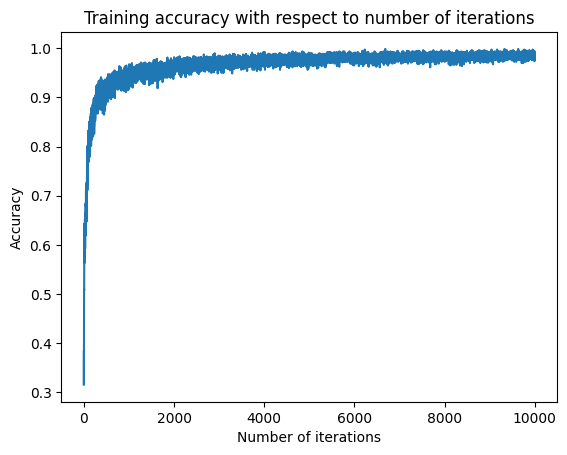

In [11]:
plt.plot(no_of_iternation, meta_train_acc)
plt.title('Training accuracy with respect to number of iterations')
plt.xlabel('Number of iterations')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Error')

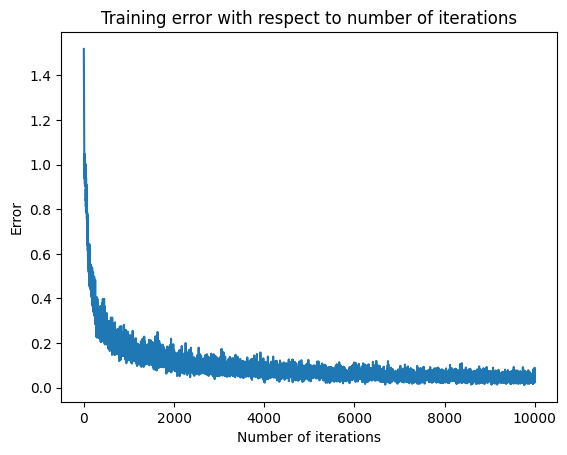

In [12]:
plt.plot(no_of_iternation, meta_train_err)
plt.title('Training error with respect to number of iterations')
plt.xlabel('Number of iterations')
plt.ylabel('Error')

Text(0, 0.5, 'Error')

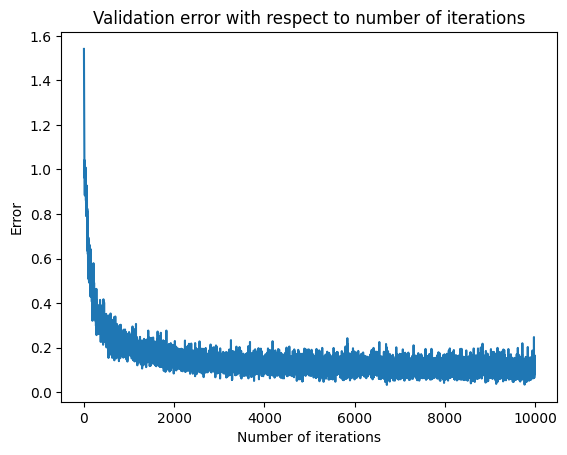

In [13]:
plt.plot(no_of_iternation, meta_val_err)
plt.title('Validation error with respect to number of iterations')
plt.xlabel('Number of iterations')
plt.ylabel('Error')

Text(0, 0.5, 'Accuracy')

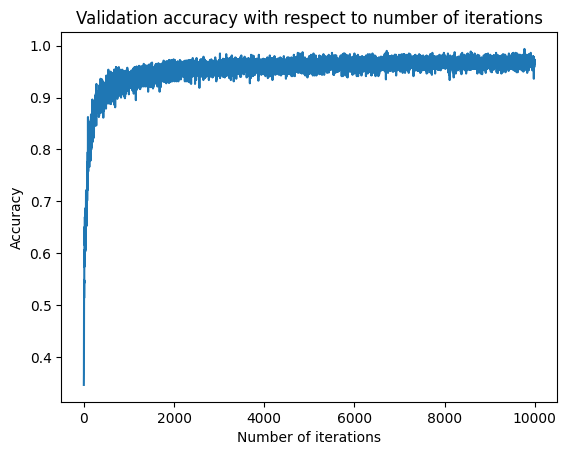

In [14]:
plt.plot(no_of_iternation, meta_val_acc)
plt.title('Validation accuracy with respect to number of iterations')
plt.xlabel('Number of iterations')
plt.ylabel('Accuracy')